# **2D Self supervision pipeline**
___  
  
In this notebook we show how to apply a [BiaPy](https://biapyx.github.io/) pipeline for **2D self supervision** of microscopy data.

<figure>
<center>
<img src='https://biapy.readthedocs.io/en/latest/_images/lucchi_train_0.png' width='300px'/>
<img src='https://biapy.readthedocs.io/en/latest/_images/lucchi_train_0_crap.png' width='300px'/>
<figcaption><b>Figure 1</b>: Example of a 2D self supervision problem. From left to right: 2D electron microscopy image and its worstened version (for 'crappify' pretext task.</figcaption></center>
</figure>

**Without any coding**, we explain step by step how to
1. **upload a set of training and test images** without any label, as this is unsupervised,
2. **train a deep neural network (DNN)** model on the training set,
3. **apply the model** to the test images, and
4. **download the model's weigths** to your local machine.

**Disclaimer:** The structure of the notebook is heavily inspired in the fantastic [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

**Contact:** This notebook was created by [Ignacio Arganda-Carreras](mailto:ignacio.arganda@ehu.eus), [Lenka Backová](mailto:lenka.backova@ehu.eus), [Daniel Franco-Barranco](mailto:daniel.franco@dipc.org) and [Ane Paniagua](mailto:anepaniagua@gmail.com). For suggestions, comments, or issues, please reach out to us via email or [create an issue in BiaPy's repository](https://github.com/BiaPyX/BiaPy/issues). Thank you!


## **Expected inputs and outputs**
___
**Inputs**

This notebook expects two folders as input:
* **Training raw images**: with the raw 2D images to train the model.
* **Output folder**: a path to store the workflow results.

**Outputs**

If the execution is successful, a folder will be created containing the workflow results.

<font color='red'><b>Note</b></font>: for testing purposes, you can also run this notebook with the **example datasets provided in 'Manage file(s) source > Option 3'**.

**Data structure**

To ensure the proper operation of the library the data directory tree should be something like this:

```
dataset/
└── train
    ├── training-0001.tif
    ├── training-0002.tif
    ├── . . .
    └── training-9999.tif

```

**Input Format Support**

This notebook is compatible with a range of input formats. You can use the following file extensions: `.tif`, `.png`, `.jpg`, `.npy`, `.h5`, `.hdf5` (every extension supported by [scikit-image](https://scikit-image.org/docs/stable/api/skimage.io.html#skimage.io.imread)).





## **Prepare the environment**
___

Establish connection with Google services. You **must be logged in to Google** to continue.
Since this is not Google's own code, you will probably see a message warning you of the dangers of running unfamiliar code. This is completely normal.



## **Check for GPU access**
---

By default, the session should be using Python 3 and GPU acceleration, but it is possible to ensure that these are set properly by doing the following:

Go to **Runtime -> Change the Runtime type**

**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

**Accelerator: GPU** *(Graphics processing unit)*

## **Manage file(s) source**
---
The input folder can be provided using three different options: by directly uploading the folder (option 1), by using a folder stored in Google Drive (option 2) or by using a few samples of our data (option 3).

Depending on the option chosen, different steps will have to be taken, as explained in the following cells.


### **Option 1: Upload Local Files to the Notebook**
---
You will be prompted to upload your files to Colab and they will be stored under `/content/input/`.

In [ ]:
#@markdown ##Play the cell to upload local files (train raw images)
from google.colab import files
!mkdir -p /content/input/train/x
%cd /content/input/train/x
uploaded = files.upload()
%cd /content

### **Option 2: Mount Your Google Drive**
---
To use this notebook on your own data from Google Drive, you need to mount Google Drive first.

Play the cell below to mount your Google Drive and follow the link that will be shown. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter. This will give Colab access to the data on the drive.

Once this is done, your data are available in the **Files** tab on the top left of notebook.

In [ ]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

### **Option 3: Download an Example Dataset**
---
If you do not have data at hand but would like to test the notebook, no worries! You can run the following cell to download an example dataset.

In particular, we will use the [Electron Microscopy Dataset (EPFL - CVLAB)](https://www.epfl.ch/labs/cvlab/data/data-em/) publicly available online.

In [ ]:
#@markdown ##Play to download an example dataset
!pip install gdown==5.1.0 --quiet
import gdown
import os

os.chdir('/content/')
gdown.download("https://drive.google.com/uc?id=1DfUoVHf__xk-s4BWSKbkfKYMnES-9RJt", "fibsem_epfl.zip", quiet=True)

!unzip -q fibsem_epfl.zip
!rm fibsem_epfl.zip

print( 'Dataset downloaded and unzipped under /content/data')


Dataset downloaded and unzipped under /content/data


## **Paths for Input Images and Output Files**
___

Depending on the option you chose for managing file sources, you'll set your paths differently:

- **Option 1 (Upload from Local Machine)**:
  - Set `train_data_path` to `/content/input/train`
  - Set `output_path` to `/content/out`
  
- **Option 2 (Use Google Drive Data)**:
  - Insert the paths to your input files and your desired output directory here, i.e., `/content/gdrive/MyDrive/...`.
  
- **Option 3 (Use Our Sample Data)**:
  - Set `train_data_path` to `/content/data/train`
  - Set `output_path` to `/content/out`

  **Note**: Ensure you download your results from the `/content/out` directory after the process!

**Helpful Tip**: If you're unsure about the paths to your folders, look at the top left of this notebook for a small folder icon. Navigate through the directories until you locate your desired folder. Right-click on it and select "Copy Path" to copy the folder's path.

In [ ]:
#@markdown #####Path to train images
train_data_path = '/content/data/train/x' #@param {type:"string"}
#@markdown #####Path to store the resulting images (it'll be created if not existing):
output_path = '/content/output' #@param {type:"string"}

## **Dataset Visualization**
---

In [ ]:
# @markdown ## Play to visualize some data samples
%matplotlib inline
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
import os
from ipywidgets import interact, IntSlider, Layout, Dropdown, HBox, Output

# Initialize paths and image IDs
input_path = train_data_path
ids_input = sorted(next(os.walk(input_path))[2])

# Slider widget to choose instance
slider= IntSlider(
    value=0,
    min=1,
    max=len(ids_input),
    step=1,
    description='Image index:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    layout=Layout(width='500px', margin = '0 0 0 10px')
)

slider.style.description_width = 'initial'
slider.style.handle_color='blue'

# Initialize Output instance to handle code output cell
output = Output()

# Function to display images depending on slider value
def display_images(change):
    with output:
        output.clear_output(wait=True)
        index = change['new']

        global input_path, ids_input
        input_img_path = os.path.join(input_path, ids_input[index-1])

        # # Print sample path to ensure the image displayed is correct
        # print(f"Instance path: {input_img_path}")

        input_img = imread(input_img_path)

        # Display images
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.title(f"Input image: {index}")
        plt.imshow(input_img, cmap='gray', interpolation='nearest')
        # plt.axis('off')

        plt.show()

# Create an HBox to hold the slider
controls = HBox([slider])
display(controls, output)

# Link slider to display_images function
slider.observe(display_images, names='value')

# Initial display
display_images({'new': slider.value})

Output()

## **Install BiaPy**
___
This might take some minutes depending on the current installed libraries in Colab.

In [ ]:
#@markdown ##Play to install BiaPy and its dependences

import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from skimage.io import imread
import ipywidgets as widgets
from ipywidgets import Output

# Uninstall some packages already installed in Colab for Pytorch 2.1.0
!pip uninstall -y torchtext

!pip install biapy==3.5.3

# Then install Pytorch + CUDA 11.8
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu118
!pip install 'timm>=0.9.12' torchmetrics[image] pytorch-msssim

from biapy import BiaPy

changed_source = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.0/365.0 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.

## **Configure and train the DNN model**
In this workflow, any of the models implemented in [BiaPy](https://biapy.readthedocs.io/en/latest/) can be used. In this notebook we configure the networks of semantic/instance segmentation.

The idea of this workflow is to pretrain the backbone model by solving a so-called pretext task without labels. This way, the model learns a representation that can be later transferred to solve a downstream task in a labeled (but smaller) dataset. In BiaPy we adopt two pretext tasks that you will need to choose with **pretext_task** variable below. The pretext tasks implemented in BiaPy are these:

* 'crappify': To recover a worstened version of the input image as in (see [Franco-Barranco et al., 2022](https://www.sciencedirect.com/science/article/pii/S0169260722003315)).
* 'masking': Random patches of the input image are masked and the network needs to reconstruct the missing pixels (see [He et al., 2022](https://openaccess.thecvf.com/content/CVPR2022/papers/He_Masked_Autoencoders_Are_Scalable_Vision_Learners_CVPR_2022_paper.pdf)).

The selection of the model and the pipeline hyperparameters can be configured by editing the YAML configuration file or (easier) by running the next cell.



In [ ]:
# @markdown ###OPTIONAL: Check BioImage Model Zoo (BMZ) models compatible with BiaPy
# @markdown Use this option to generate a full list of the available BiaPy-compatible models in the BMZ.

# @markdown **Important:** To select one of the listed models (if any), you will have to run the next cell and select "BioImage Model Zoo" as the source of the model. Then, paste the corresponding model's nickname into the created field.
# @markdown <div><img src="https://bioimage.io/static/img/bioimage-io-logo.svg" width="600"/></div>

import json
from pathlib import Path
import pooch
import yaml
from IPython.display import HTML, display
import logging
from biapy.models import check_bmz_model_compatibility
from packaging.version import Version
from typing import Optional, Dict, Tuple, List, Literal

# Change pooch verbosity
logger = pooch.get_logger()
logger.setLevel("WARNING")

# Extracted from BiaPy-GUI.
# Adapted from BiaPy commit: 284ec3838766392c9a333ac9d27b55816a267bb9 (3.5.2)
def check_model_restrictions(
    model_rdf,
    workflow_specs,
):
    """
    Checks model restrictions to be applied into the current configuration.

    Parameters
    ----------
    model_rdf : dict
        BMZ model RDF that contains all the information of the model.

    workflow_specs : dict
        Specifications of the workflow. If not provided all possible models will be considered.

    Returns
    -------
    option_list: dict
        Variables and values to change in current configuration. These changes
        are imposed by the selected model.
    """
    specific_workflow = workflow_specs["workflow_type"]

    # Version of the model
    model_version = Version(model_rdf["format_version"])
    opts = {}

    # 1) Change PATCH_SIZE with the one stored in the model description. This differs from the code of BiaPy where
    # get_test_inputs() is simply used as there a ModelDescr is build out of the RDF. Here we try to do it manually
    # to avoid fetching files using the network as it may be slow.
    input_image_shape = []
    if "shape" in model_rdf["inputs"][0]:
        input_image_shape = model_rdf["inputs"][0]["shape"]
        # "CebraNET Cellular Membranes in Volume SEM" ('format_version': '0.4.10')
        #   have: {'min': [1, 1, 64, 64, 64], 'step': [0, 0, 16, 16, 16]}
        if isinstance(input_image_shape, dict) and "min" in input_image_shape:
            input_image_shape = input_image_shape["min"]
    else:
        # Check axes and dimension
        input_image_shape = []
        for axis in model_rdf["inputs"][0]["axes"]:
            if 'type' in axis:
                if axis['type'] == "batch":
                    input_image_shape += [1,]
                elif axis['type'] == "channel":
                    input_image_shape += [1,]
                elif 'id' in axis and 'size' in axis:
                    if isinstance(axis['size'], int):
                        input_image_shape += [axis['size'],]
                    elif 'min' in axis['size']:
                        input_image_shape += [axis['size']['min'],]
            elif 'id' in axis:
                if axis['id'] == "channel":
                    input_image_shape += [1,]
                else:
                    if isinstance(axis['size'], int):
                        input_image_shape += [axis['size'],]
                    elif 'min' in axis['size']:
                        input_image_shape += [axis['size']['min'],]
    if len(input_image_shape) == 0:
        raise ValueError("Couldn't load input info from BMZ model's RDF: {}".format(model_rdf["inputs"][0]))
    opts["DATA.PATCH_SIZE"] = tuple(input_image_shape[2:]) + (input_image_shape[1],)

    # Capture model kwargs
    if "kwargs" in model_rdf["weights"]["pytorch_state_dict"]:
        model_kwargs = model_rdf["weights"]["pytorch_state_dict"]["kwargs"]
    elif (
        "architecture" in model_rdf["weights"]["pytorch_state_dict"]
        and "kwargs" in model_rdf["weights"]["pytorch_state_dict"]["architecture"]
    ):
        model_kwargs = model_rdf["weights"]["pytorch_state_dict"]["architecture"]["kwargs"]
    else:
        raise ValueError(f"Couldn't extract kwargs from model description.")

    # 2) Workflow specific restrictions
    # Classes in semantic segmentation
    if specific_workflow in ["SEMANTIC_SEG"]:
        # Check number of classes
        classes = -1
        if "n_classes" in model_kwargs: # BiaPy
            classes = model_kwargs["n_classes"]
        elif "out_channels" in model_kwargs:
            classes = model_kwargs["out_channels"]
        elif "classes" in model_kwargs:
            classes = model_kwargs["classes"]

        if isinstance(classes, list):
            classes = classes[0]
        if not isinstance(classes, int):
            raise ValueError(f"Classes not extracted correctly. Obtained {classes}")

        if specific_workflow == "SEMANTIC_SEG" and classes == -1:
            raise ValueError("Classes not found for semantic segmentation dir. ")
        opts["MODEL.N_CLASSES"] = max(2,classes)
    elif specific_workflow in ["INSTANCE_SEG"]:
        # Assumed it's BC. This needs a more elaborated process. Still deciding this:
        # https://github.com/bioimage-io/spec-bioimage-io/issues/621
        channels = 2
        if "out_channels" in model_kwargs:
            channels = model_kwargs["out_channels"]
        if channels == 1:
            channel_code = "C"
        elif channels == 2:
            channel_code = "BC"
        elif channels == 3:
            channel_code = "BCM"
        if channels > 3:
            raise ValueError(f"Not recognized number of channels for instance segmentation. Obtained {channels}")

        opts["PROBLEM.INSTANCE_SEG.DATA_CHANNELS"] = channel_code

    if "preprocessing" not in model_rdf["inputs"][0]:
        return opts

    preproc_info = model_rdf["inputs"][0]["preprocessing"]
    if len(preproc_info) == 0:
        return opts
    preproc_info = preproc_info[0]

    # 3) Change preprocessing to the one stablished by BMZ by translate BMZ keywords into BiaPy's
    # 'zero_mean_unit_variance' and 'fixed_zero_mean_unit_variance' norms of BMZ can be translated to our 'custom' norm
    # providing mean and std
    key_to_find = "id" if model_version > Version("0.5.0") else "name"
    if key_to_find in preproc_info:
        if preproc_info[key_to_find] in ["fixed_zero_mean_unit_variance", "zero_mean_unit_variance"]:
            if (
                "kwargs" in preproc_info
                and "mean" in preproc_info["kwargs"]
            ):
                mean = preproc_info["kwargs"]["mean"]
                std = preproc_info["kwargs"]["std"]
            elif "mean" in preproc_info:
                mean = preproc_info["mean"]
                std = preproc_info["std"]
            else:
                mean, std = -1., -1.

            opts["DATA.NORMALIZATION.TYPE"] = "custom"
            opts["DATA.NORMALIZATION.CUSTOM_MEAN"] = mean
            opts["DATA.NORMALIZATION.CUSTOM_STD"] = std

        # 'scale_linear' norm of BMZ is close to our 'div' norm (TODO: we need to control the "gain" arg)
        elif preproc_info[key_to_find] == "scale_linear":
            opts["DATA.NORMALIZATION.TYPE"] = "div"

        # 'scale_range' norm of BMZ is as our PERC_CLIP + 'scale_range' norm
        elif preproc_info[key_to_find] == "scale_range":
            opts["DATA.NORMALIZATION.TYPE"] = "scale_range"
            if (
                float(preproc_info["kwargs"]["min_percentile"]) != 0
                or float(preproc_info["kwargs"]["max_percentile"]) != 100
            ):
                opts["DATA.NORMALIZATION.PERC_CLIP"] = True
                opts["DATA.NORMALIZATION.PERC_LOWER"] = float(preproc_info["kwargs"]["min_percentile"])
                opts["DATA.NORMALIZATION.PERC_UPPER"] = float(preproc_info["kwargs"]["max_percentile"])

    return opts

# Check the models that BiaPy can consume
COLLECTION_URL = "https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/collection.json"
collection_path = Path(pooch.retrieve(COLLECTION_URL, known_hash=None))
with collection_path.open() as f:
    collection = json.load(f)

model_urls = [entry["rdf_source"] for entry in collection["collection"] if entry["type"] == "model"]

model_rdfs = []
for mu in model_urls:
    with open(Path(pooch.retrieve(mu, known_hash=None)), 'rt', encoding='utf8') as stream:
        try:
            model_rdfs.append(yaml.safe_load(stream))
        except yaml.YAMLError as exc:
            print(exc)

# Check axes, preprocessing functions used and postprocessing.
pytorch_models = []
imposed_vars = []

workflow_specs = {
    "workflow_type": "SELF_SUPERVISED",
    "ndim": "2D",
    "nclasses": "all",
}
for model_rdf in model_rdfs:
    (
        preproc_info,
        error,
        error_message
    ) = check_bmz_model_compatibility(model_rdf, workflow_specs=workflow_specs)

    if not error:
        model_imposed_vars = check_model_restrictions(model_rdf, workflow_specs=workflow_specs)
        imposed_vars.append(model_imposed_vars)
        pytorch_models.append(model_rdf)

# Print the possible models
html = "<table style='width:100%''>"
c = 0
for i, model in enumerate(pytorch_models):

    if 'nickname' in model['config']['bioimageio']:
        nickname = model['config']['bioimageio']['nickname']
        nickname_icon = model['config']['bioimageio']['nickname_icon']
    elif 'id' in model['config']['bioimageio']:
        nickname = model['config']['bioimageio']['id']
        nickname_icon = model['config']['bioimageio']['id_emoji']
    else:
        doi = "/".join(model['id'].split("/")[:2])
        nickname = doi
        nickname_icon = doi
    cover_url = "https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/"+nickname+"/"+str(model["version"])+"/files/"+model['covers'][0]
    restrictions = ""
    for key, val in imposed_vars[i].items():
        if key == 'MODEL.N_CLASSES':
            restrictions += "<p>number_of_classes: {}</p>".format(val)
        elif key == "PROBLEM.INSTANCE_SEG.DATA_CHANNELS":
            problem_channels = 'Binary mask + Contours'
            if val == "BC":
                problem_channels = "Binary mask + Contours"
            elif val == 'BP':
                problem_channels = "Binary mask + Central points"
            elif val == 'BD':
                problem_channels = "Binary mask + Distance map"
            elif val == 'BCM':
                problem_channels = "Binary mask + Contours + Foreground mask"
            elif val == 'BCD':
                problem_channels = "Binary mask + Contours + Distance map"
            elif val == 'BCDv2':
                problem_channels = "Binary mask + Contours + Distance map with background"
            elif val == 'Dv2':
                problem_channels = "Distance map with background"
            restrictions += "<p>problem_representation: {}</p>".format(problem_channels)
    if c == 0:
        html += "<tr>"
    html += "<td style='width:33%'>"
    html += "<p style='color:#2196f3'>%s</p><p>Nickname: %s (%s)</p>%s<img src='%s' height='200'></td>"%(
        model['name'],
        nickname,
        nickname_icon,
        restrictions,
        cover_url,
    )
    c +=1
    if c == 3:
        html += "</tr>"
        c=0
html += "</table>"
if len( pytorch_models ) == 0:
    display(HTML('<h1>No BMZ models compatible with BiaPy were found for this task.</h1><br>'))
else:
    display(HTML('<h1>List of models that can be used in BiaPy:</h1><br>'))
    display(HTML(html))


In [ ]:
#@markdown ###Play to select the source to build the model (BiaPy or BioImage Model Zoo) { run: "auto", vertical-output: true, display-mode: "form" }

#@markdown **BiaPy**: to use the models implemented in BiaPy.

#@markdown **Bioimage Model Zoo (BMZ)**: to use models from the [BMZ repository](https://bioimage.io/#/). You can run the above cell to generate an updated list of the models that can be used with BiaPy. Copy the nickname from the model and paste it below.
import ipywidgets as widgets
from ipywidgets import Output

changed_source = True
exists_bmz = False
# create widgets
source = widgets.ToggleButtons(
    options=['BiaPy', 'BioImage Model Zoo'],
    description='Source:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Models created during this workflow', 'BioImage Model Zoo model'],
#     icons=['check'] * 3
)

bmz = widgets.Text(
    # value='10.5281/zenodo.5764892',
    placeholder='Nickname of BMZ model',
    description='ID:',
    disabled=False
)

# display the first widget
display(source)

# intialize the output - second widget
out = Output()

def changed(change):
    '''
    Monitor change in the first widget
    '''
    global out
    global exists_bmz
    if source.value == 'BiaPy':
        bmz.layout.display = 'none'
        out.clear_output() #clear output
        out = Output() # redefine output
    else:
        bmz.layout.display = 'none'
        bmz.layout.display = 'flex'
        if not exists_bmz:
          out.append_display_data(bmz)
          display(out)
        exists_bmz = True

# monitor the source widget for changes
source.observe(changed, 'value')

ToggleButtons(description='Source:', options=('BiaPy', 'BioImage Model Zoo'), tooltips=('Models created during…

### **Select your parameters**
---
#### **Name of the model**
* **`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.

#### **Data management**
* **`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during the training. **Default value: 10**

#### **Basic training parameters**
* **`pretext_task`:** Pretext task to use to train the model. Options: 'crappify' to recover a worstened version of the input image as in (see [Franco-Barranco et al., 2022](https://www.sciencedirect.com/science/article/pii/S0169260722003315)) and 'masking', where random patches of the input image are masked and the network needs to reconstruct the missing pixels (see [He et al., 2022](https://openaccess.thecvf.com/content/CVPR2022/papers/He_Masked_Autoencoders_Are_Scalable_Vision_Learners_CVPR_2022_paper.pdf)). **Default value: 'crappify'**

* **`input_channels`:** Input the number of channels of your images (grayscale = 1, RGB = 3). **Default value: 1**

* **`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. In this example we only use 100 epochs, but if 'masking' pretext task as selected thousand epochs are necessary to obtain good data representations.The MAE method represents a cutting-edge technique in the realm of semi-supervised learning (SSL), albeit with the trade-off of increased computational requirements and time constraints. With 'crappify' less better representations can be obtained but require less epochs too. **Default value: 100**

* **`patience`:**  Input how many epochs you want to wait without the model improving its results in the validation set to stop training. **Default value: 20**

#### **Advanced Parameters - experienced users only**
* **`model_architecture`:**  Select the architecture of the DNN used as backbone of the pipeline. Options: MAE, EDSR, RCAN, WDSR, DFCAN, U-Net, Residual U-Net, Attention U-Net, SEUNet, MultiResUNet, ResUNet++ (see [Franco-Barranco et al., 2021](https://link.springer.com/article/10.1007/s12021-021-09556-1)), UNETR-Mini, UNETR-Small and UNETR-Base. **Default value: U-Net**

* **`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 6**

* **`patch_size`:** Input the size of the patches use to train your model (length in pixels in X and Y). The value should be smaller or equal to the dimensions of the image. **Default value: 256**

* **`optimizer`:** Select the optimizer used to train your model. Options: ADAM, ADAMW, Stochastic Gradient Descent (SGD). ADAM usually converges faster, while ADAMW provides a balance between fast convergence and better handling of weight decay regularization. SGD is known for better generalization. **Default value: ADAMW**

* **`initial_learning_rate`:** Input the initial value to be used as learning rate. If you select ADAM as optimizer, this value should be around 10e-4. **Default value: 0.0001**

* **`learning_rate_scheduler`:** Select to adjust the learning rate between epochs. Options: "None", "Reduce on plateau", "One cycle", "Warm-up cosine decay". **Default value: None**


In [ ]:
#@markdown ###Name of the model:
model_name = "my_2d_self_supervision" #@param {type:"string"}

#@markdown ### Data management:
percentage_validation =  10 #@param {type:"number"}

#@markdown ### Basic training parameters:
pretext_task = "crappify" #@param ["crappify", "masking"]
input_channels = 1 #@param {type:"number"}
number_of_epochs =  100#@param {type:"number"}
patience =  20#@param {type:"number"}

#@markdown ### Advanced training parameters:

model_architecture = "U-Net" #@param ["MAE", "U-Net", "Residual U-Net", "Attention U-Net", 'MultiResUNet', 'SEUNet', 'ResUNet++', "UNETR-Mini", "UNETR-Small", "UNETR-Base", "EDSR", "RCAN", "WDSR", "DFCAN"]

batch_size =  6#@param {type:"number"}
patch_size = 256 #@param {type:"number"}

optimizer = "ADAMW" #@param ["ADAM", "SGD","ADAMW"]
initial_learning_rate = 0.0001 #@param {type:"number"}
learning_rate_scheduler = "None" #@param ["None", "Reduce on plateau","One cycle", "Warm-up cosine decay"]

checkpoint_path = ''


In [ ]:
#@markdown ##OPTIONAL: Play the cell to upload initial model weights
#@markdown Use this option to start the training from a **pre-trained model** if you have one. Otherwise, skip this cell.

#@markdown **Important**: remember the weights must correspond to the selected architecture, patch size and number of input channels. Otherwise, an error will be shown when training.
from google.colab import files

#s.chdir('/content/')

uploaded = files.upload()

checkpoint_path = '/content/' + list(uploaded.keys())[0]

# open previously configured file, if exists
job_name = model_name
yaml_file = "/content/"+str(job_name)+".yaml"

# edit previous configuration file if it exists to load the checkpoint model
if os.path.exists( yaml_file ):
    import yaml
    with open( yaml_file, 'r') as stream:
        try:
            biapy_config = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    biapy_config['PATHS'] = {}
    biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path
    biapy_config['MODEL'] = {}
    biapy_config['MODEL']['LOAD_CHECKPOINT'] = True

    # save file
    with open( yaml_file, 'w') as outfile:
        yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Pre-trained model loaded and ready to re-train.")

### **Train the model**
---

In [ ]:
#@markdown ##Play to train the model
import os
import errno

os.chdir('/content/')

job_name = model_name
yaml_file = "/content/"+str(job_name)+".yaml"

# remove previous configuration file if it exists with the same name
if os.path.exists( yaml_file ):
    os.remove( yaml_file )

# remove template file it is exists
template_file = '2d_self-supervised.yaml'
if os.path.exists( template_file ):
    os.remove( template_file )

# Download template file
!wget https://raw.githubusercontent.com/BiaPyX/BiaPy/master/templates/self-supervised/2d_self-supervised.yaml &> /dev/null

# Check folders before modifying the .yaml file
if not os.path.exists(train_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_data_path)
ids = sorted(next(os.walk(train_data_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(train_data_path))

# open template configuration file
import yaml
with open( template_file, 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# update paths to data
biapy_config['DATA']['TRAIN']['PATH'] = train_data_path
biapy_config['DATA']['TEST']['PATH'] = train_data_path

# update data patch size
biapy_config['DATA']['PATCH_SIZE'] = '('+str(patch_size)+', '+ str(patch_size)+', ' + str(input_channels)+')'
# adjust test padding accordingly
padding = patch_size // 8
biapy_config['DATA']['TEST']['PADDING'] = '('+ str(padding)+', '+ str(padding)+')'

# update training parameters
biapy_config['DATA']['VAL']['FROM_TRAIN'] = True
biapy_config['DATA']['VAL']['SPLIT_TRAIN'] = percentage_validation/100.0
biapy_config['TRAIN']['EPOCHS'] = number_of_epochs
if number_of_epochs < 10:
    biapy_config['LOG'] = {}
    biapy_config['LOG']['CHART_CREATION_FREQ'] = 1
biapy_config['TRAIN']['PATIENCE'] = patience
biapy_config['TRAIN']['BATCH_SIZE'] = batch_size
biapy_config['TRAIN']['OPTIMIZER'] = optimizer
biapy_config['TRAIN']['LR'] = initial_learning_rate

# learning rate scheduler
if learning_rate_scheduler == 'One cycle':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'onecycle'
elif learning_rate_scheduler == 'Warm-up cosine decay':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'warmupcosine'
    biapy_config['TRAIN']['LR_SCHEDULER']['MIN_LR'] = 0.0
    biapy_config['TRAIN']['LR_SCHEDULER']['WARMUP_COSINE_DECAY_EPOCHS'] = 0
elif learning_rate_scheduler == 'Reduce on plateau':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'reduceonplateau'
    biapy_config['TRAIN']['LR_SCHEDULER']['REDUCEONPLATEAU_FACTOR'] = 0.5
    biapy_config['TRAIN']['LR_SCHEDULER']['REDUCEONPLATEAU_PATIENCE'] = 5
    biapy_config['TRAIN']['LR_SCHEDULER']['MIN_LR'] = 0.00001

# change source to build model - biapy, torchvision or bmz
if changed_source:
    if source.value == "BiaPy":
        biapy_config['MODEL']['SOURCE'] = "biapy"
    elif source.value == 'BioImage Model Zoo':
        biapy_config['MODEL']['SOURCE'] = "bmz"
        biapy_config['MODEL']['BMZ'] = {}
        biapy_config['MODEL']['BMZ']['SOURCE_MODEL_ID'] = str(bmz.value).strip()
else:
    biapy_config['MODEL']['SOURCE'] = "biapy"


# Transcribe model architecture
# Available models: "MAE", "U-Net", "Residual U-Net", "Attention U-Net",
# 'MultiResUNet', 'SEUNet', 'ResUNet++', "UNETR-Mini", "UNETR-Small",
# "UNETR-Base", "EDSR", "RCAN", "WDSR", "DFCAN"
architecture = 'unet'
if model_architecture == "MAE":
    architecture = 'mae'
elif model_architecture == "U-Net":
    architecture = 'unet'
elif model_architecture == "Residual U-Net":
    architecture = 'resunet'
elif model_architecture == "Attention U-Net":
    architecture = 'attention_unet'
elif model_architecture == "MultiResUNet":
    architecture = 'multiresunet'
elif model_architecture == "SEUNet":
    architecture = 'seunet'
elif model_architecture == "ResUNet++":
    architecture = 'resunet++'
elif model_architecture == "RCAN":
    architecture = 'rcan'
elif model_architecture == "WDSR":
    architecture = 'wdsr'
elif model_architecture == "SRUNET":
    architecture = 'srunet'
elif model_architecture == "DFCAN":
    architecture = 'dfcan'
elif model_architecture == "UNETR-Mini":
    architecture = 'unetr'
    biapy_config['MODEL']['VIT_TOKEN_SIZE'] = 16
    biapy_config['MODEL']['VIT_EMBED_DIM'] = 64
    biapy_config['MODEL']['VIT_NUM_LAYERS'] = 4
    biapy_config['MODEL']['VIT_MLP_RATIO'] = 4. # to get 256
    biapy_config['MODEL']['VIT_NUM_HEADS'] = 4
    biapy_config['MODEL']['UNETR_VIT_HIDD_MULT'] = 1
    biapy_config['TEST']['FULL_IMG'] = False
elif model_architecture == "UNETR-Small":
    architecture = 'unetr'
    biapy_config['MODEL']['VIT_TOKEN_SIZE'] = 16
    biapy_config['MODEL']['VIT_EMBED_DIM'] = 128
    biapy_config['MODEL']['VIT_NUM_LAYERS'] = 8
    biapy_config['MODEL']['VIT_MLP_RATIO'] = 4. # to get 512
    biapy_config['MODEL']['VIT_NUM_HEADS'] = 8
    biapy_config['MODEL']['UNETR_VIT_HIDD_MULT'] = 2
    biapy_config['TEST']['FULL_IMG'] = False
else: # UNETR-Base
    architecture = 'unetr'
    biapy_config['MODEL']['VIT_TOKEN_SIZE'] = 16
    biapy_config['MODEL']['VIT_EMBED_DIM'] = 256
    biapy_config['MODEL']['VIT_NUM_LAYERS'] = 12
    biapy_config['MODEL']['VIT_MLP_RATIO'] = 3. # to get 768
    biapy_config['MODEL']['VIT_NUM_HEADS'] = 12
    biapy_config['MODEL']['UNETR_VIT_HIDD_MULT'] = 3
    biapy_config['TEST']['FULL_IMG'] = False

biapy_config['MODEL']['ARCHITECTURE'] = architecture

# update test parameters
biapy_config['TEST']['ENABLE'] = True

# SSL configuration
biapy_config['PROBLEM']['SELF_SUPERVISED'] = {}
biapy_config['PROBLEM']['SELF_SUPERVISED']['PRETEXT_TASK'] = pretext_task

# Make sure random rotations are set to false
biapy_config['AUGMENTOR']['RANDOM_ROT'] = False
biapy_config['AUGMENTOR']['ROT90'] = True

# model weights
if checkpoint_path != '':
    biapy_config['PATHS'] = {}
    biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path
    biapy_config['MODEL'] = {}
    biapy_config['MODEL']['LOAD_CHECKPOINT'] = True

# save file
with open( yaml_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Training configuration finished.")

# Run the code
biapy = BiaPy(f'/content/{job_name}.yaml', result_dir=output_path, name=job_name, run_id=1, gpu=0)
biapy.run_job()

Training configuration finished.
Date: 2024-08-27 09:13:25
Arguments: Namespace(config='/content/my_2d_self_supervision.yaml', result_dir='/content/output', name='my_2d_self_supervision', run_id=1, gpu=0, world_size=1, local_rank=-1, dist_on_itp=False, dist_url='env://', dist_backend='nccl')
Job: my_2d_self_supervision_1
Python       : 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
PyTorch:  2.4.0+cu121
Not using distributed mode
[09:13:25.532530] Configuration details:
[09:13:25.533312] AUGMENTOR:
  AFFINE_MODE: reflect
  AUG_NUM_SAMPLES: 10
  AUG_SAMPLES: True
  BRIGHTNESS: False
  BRIGHTNESS_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_MODE: 3D
  CBLUR_DOWN_RANGE: (2, 8)
  CBLUR_INSIDE: True
  CBLUR_SIZE: (0.2, 0.4)
  CHANNEL_SHUFFLE: False
  CMIX_SIZE: (0.2, 0.4)
  CNOISE_NB_ITERATIONS: (1, 3)
  CNOISE_SCALE: (0.05, 0.1)
  CNOISE_SIZE: (0.2, 0.4)
  CONTRAST: False
  CONTRAST_FACTOR: (-0.1, 0.1)
  CONTRAST_MODE: 3D
  COUT_APPLY_TO_MASK: False
  COUT_CVAL: 0.0
  COUT_NB_ITERATIONS: (1, 3)
  

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:07<00:00, 629kB/s] 
/usr/local/lib/python3.10/dist-packages/torchmetrics/functional/image/lpips.py:325: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for 

[09:13:41.322691] ############################
[09:13:41.322845] #  PREPARE DETECTION DATA  #
[09:13:41.322892] ############################
[09:13:41.325520] You select to create detection masks from given .csv files but no file is detected in /content/data/train/x_ssl_source. So let's prepare the data. Notice that, if you do not modify 'DATA.TRAIN.SSL_SOURCE_DIR' path, this process will be done just once!
[09:13:41.326735] Creating train SSL source. . .
[09:13:41.327594] Crappifying file /content/data/train/x/training-0001.tif to create SSL source
[09:13:41.523518] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:41.577051] Crappifying file /content/data/train/x/training-0002.tif to create SSL source


[09:13:41.767080] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:41.813013] Crappifying file /content/data/train/x/training-0003.tif to create SSL source


[09:13:42.000079] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:42.052493] Crappifying file /content/data/train/x/training-0004.tif to create SSL source


[09:13:42.232599] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:42.280112] Crappifying file /content/data/train/x/training-0005.tif to create SSL source


[09:13:42.461992] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:42.506174] Crappifying file /content/data/train/x/training-0006.tif to create SSL source
[09:13:42.620963] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:42.659184] Crappifying file /content/data/train/x/training-0007.tif to create SSL source


[09:13:42.764533] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:42.798233] Crappifying file /content/data/train/x/training-0008.tif to create SSL source
[09:13:42.902345] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:42.935554] Crappifying file /content/data/train/x/training-0009.tif to create SSL source


[09:13:43.056139] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:43.089462] Crappifying file /content/data/train/x/training-0010.tif to create SSL source


[09:13:43.197451] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:43.231324] Crappifying file /content/data/train/x/training-0011.tif to create SSL source


[09:13:43.338846] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:43.373594] Crappifying file /content/data/train/x/training-0012.tif to create SSL source


[09:13:43.485005] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:43.528054] Crappifying file /content/data/train/x/training-0013.tif to create SSL source


[09:13:43.645040] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:43.681236] Crappifying file /content/data/train/x/training-0014.tif to create SSL source


[09:13:43.789846] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:43.828948] Crappifying file /content/data/train/x/training-0015.tif to create SSL source


[09:13:43.933482] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:43.968889] Crappifying file /content/data/train/x/training-0016.tif to create SSL source


[09:13:44.085921] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:44.121025] Crappifying file /content/data/train/x/training-0017.tif to create SSL source


[09:13:44.226525] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:44.265638] Crappifying file /content/data/train/x/training-0018.tif to create SSL source


[09:13:44.377820] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:44.413736] Crappifying file /content/data/train/x/training-0019.tif to create SSL source


[09:13:44.539993] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:44.578146] Crappifying file /content/data/train/x/training-0020.tif to create SSL source


[09:13:44.682424] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:44.718914] Crappifying file /content/data/train/x/training-0021.tif to create SSL source


[09:13:44.825619] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:44.860286] Crappifying file /content/data/train/x/training-0022.tif to create SSL source


[09:13:44.965827] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:45.001409] Crappifying file /content/data/train/x/training-0023.tif to create SSL source


[09:13:45.119214] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:45.155705] Crappifying file /content/data/train/x/training-0024.tif to create SSL source


[09:13:45.260697] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:45.295915] Crappifying file /content/data/train/x/training-0025.tif to create SSL source


[09:13:45.403719] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:45.440659] Crappifying file /content/data/train/x/training-0026.tif to create SSL source


[09:13:45.581748] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:45.619261] Crappifying file /content/data/train/x/training-0027.tif to create SSL source
[09:13:45.732031] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:45.769925] Crappifying file /content/data/train/x/training-0028.tif to create SSL source


[09:13:45.877746] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:45.914347] Crappifying file /content/data/train/x/training-0029.tif to create SSL source


[09:13:46.028780] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:46.065870] Crappifying file /content/data/train/x/training-0030.tif to create SSL source


[09:13:46.187923] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:46.224145] Crappifying file /content/data/train/x/training-0031.tif to create SSL source


[09:13:46.334060] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:46.374675] Crappifying file /content/data/train/x/training-0032.tif to create SSL source


[09:13:46.493563] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:46.539135] Crappifying file /content/data/train/x/training-0033.tif to create SSL source
[09:13:46.652766] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:46.688236] Crappifying file /content/data/train/x/training-0034.tif to create SSL source


[09:13:46.795652] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:46.831936] Crappifying file /content/data/train/x/training-0035.tif to create SSL source


[09:13:46.939708] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:46.975880] Crappifying file /content/data/train/x/training-0036.tif to create SSL source


[09:13:47.083222] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:47.119873] Crappifying file /content/data/train/x/training-0037.tif to create SSL source


[09:13:47.246931] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:47.282643] Crappifying file /content/data/train/x/training-0038.tif to create SSL source


[09:13:47.389072] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:47.425212] Crappifying file /content/data/train/x/training-0039.tif to create SSL source


[09:13:47.559706] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:47.596210] Crappifying file /content/data/train/x/training-0040.tif to create SSL source
[09:13:47.706176] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:47.742002] Crappifying file /content/data/train/x/training-0041.tif to create SSL source


[09:13:47.850243] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:47.885225] Crappifying file /content/data/train/x/training-0042.tif to create SSL source


[09:13:47.992462] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:48.029222] Crappifying file /content/data/train/x/training-0043.tif to create SSL source


[09:13:48.147190] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:48.198357] Crappifying file /content/data/train/x/training-0044.tif to create SSL source
[09:13:48.309100] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:48.343529] Crappifying file /content/data/train/x/training-0045.tif to create SSL source


[09:13:48.453506] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:48.500626] Crappifying file /content/data/train/x/training-0046.tif to create SSL source


[09:13:48.626688] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:48.663342] Crappifying file /content/data/train/x/training-0047.tif to create SSL source
[09:13:48.771557] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:48.808686] Crappifying file /content/data/train/x/training-0048.tif to create SSL source


[09:13:48.916535] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:48.951504] Crappifying file /content/data/train/x/training-0049.tif to create SSL source


[09:13:49.057938] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:49.092622] Crappifying file /content/data/train/x/training-0050.tif to create SSL source


[09:13:49.210203] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:49.246240] Crappifying file /content/data/train/x/training-0051.tif to create SSL source


[09:13:49.358329] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:49.394158] Crappifying file /content/data/train/x/training-0052.tif to create SSL source


[09:13:49.554043] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:49.592980] Crappifying file /content/data/train/x/training-0053.tif to create SSL source
[09:13:49.698371] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:49.734857] Crappifying file /content/data/train/x/training-0054.tif to create SSL source


[09:13:49.841493] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:49.879144] Crappifying file /content/data/train/x/training-0055.tif to create SSL source


[09:13:49.991857] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:50.027041] Crappifying file /content/data/train/x/training-0056.tif to create SSL source


[09:13:50.132544] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:50.168402] Crappifying file /content/data/train/x/training-0057.tif to create SSL source


[09:13:50.288042] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:50.324251] Crappifying file /content/data/train/x/training-0058.tif to create SSL source


[09:13:50.435939] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:50.473512] Crappifying file /content/data/train/x/training-0059.tif to create SSL source


[09:13:50.606212] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:50.645361] Crappifying file /content/data/train/x/training-0060.tif to create SSL source
[09:13:50.753865] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:50.790144] Crappifying file /content/data/train/x/training-0061.tif to create SSL source


[09:13:50.896816] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:50.931425] Crappifying file /content/data/train/x/training-0062.tif to create SSL source


[09:13:51.042284] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:51.078208] Crappifying file /content/data/train/x/training-0063.tif to create SSL source


[09:13:51.183312] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:51.220238] Crappifying file /content/data/train/x/training-0064.tif to create SSL source


[09:13:51.338619] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:51.375349] Crappifying file /content/data/train/x/training-0065.tif to create SSL source


[09:13:51.499104] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:51.543091] Crappifying file /content/data/train/x/training-0066.tif to create SSL source
[09:13:51.656783] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:51.692771] Crappifying file /content/data/train/x/training-0067.tif to create SSL source


[09:13:51.798976] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:51.834054] Crappifying file /content/data/train/x/training-0068.tif to create SSL source


[09:13:51.945246] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:51.982187] Crappifying file /content/data/train/x/training-0069.tif to create SSL source


[09:13:52.092656] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:52.127816] Crappifying file /content/data/train/x/training-0070.tif to create SSL source


[09:13:52.236697] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:52.279783] Crappifying file /content/data/train/x/training-0071.tif to create SSL source


[09:13:52.389310] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:52.425069] Crappifying file /content/data/train/x/training-0072.tif to create SSL source


[09:13:52.583095] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:52.640143] Crappifying file /content/data/train/x/training-0073.tif to create SSL source


[09:13:52.821530] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:52.866846] Crappifying file /content/data/train/x/training-0074.tif to create SSL source


[09:13:53.040561] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:53.085805] Crappifying file /content/data/train/x/training-0075.tif to create SSL source


[09:13:53.258060] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:53.311870] Crappifying file /content/data/train/x/training-0076.tif to create SSL source


[09:13:53.488263] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:53.534833] Crappifying file /content/data/train/x/training-0077.tif to create SSL source


[09:13:53.715454] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:53.762197] Crappifying file /content/data/train/x/training-0078.tif to create SSL source


[09:13:53.932244] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:53.978079] Crappifying file /content/data/train/x/training-0079.tif to create SSL source


[09:13:54.162147] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:54.213563] Crappifying file /content/data/train/x/training-0080.tif to create SSL source


[09:13:54.405679] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:54.458416] Crappifying file /content/data/train/x/training-0081.tif to create SSL source


[09:13:54.660176] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:54.715184] Crappifying file /content/data/train/x/training-0082.tif to create SSL source


[09:13:54.898368] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:54.953818] Crappifying file /content/data/train/x/training-0083.tif to create SSL source


[09:13:55.142563] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:55.190933] Crappifying file /content/data/train/x/training-0084.tif to create SSL source


[09:13:55.389348] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:55.455706] Crappifying file /content/data/train/x/training-0085.tif to create SSL source


[09:13:55.647925] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:55.693638] Crappifying file /content/data/train/x/training-0086.tif to create SSL source


[09:13:55.873431] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:55.920131] Crappifying file /content/data/train/x/training-0087.tif to create SSL source


[09:13:56.106712] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:56.146434] Crappifying file /content/data/train/x/training-0088.tif to create SSL source
[09:13:56.247908] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:56.284241] Crappifying file /content/data/train/x/training-0089.tif to create SSL source


[09:13:56.396009] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:56.433299] Crappifying file /content/data/train/x/training-0090.tif to create SSL source
[09:13:56.572914] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:56.613659] Crappifying file /content/data/train/x/training-0091.tif to create SSL source
[09:13:56.719123] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:56.755618] Crappifying file /content/data/train/x/training-0092.tif to create SSL source


[09:13:56.860986] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:56.897648] Crappifying file /content/data/train/x/training-0093.tif to create SSL source


[09:13:57.005912] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:57.042883] Crappifying file /content/data/train/x/training-0094.tif to create SSL source


[09:13:57.153862] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:57.189537] Crappifying file /content/data/train/x/training-0095.tif to create SSL source


[09:13:57.297250] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:57.334817] Crappifying file /content/data/train/x/training-0096.tif to create SSL source


[09:13:57.443008] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:57.485486] Crappifying file /content/data/train/x/training-0097.tif to create SSL source


[09:13:57.641965] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:57.679503] Crappifying file /content/data/train/x/training-0098.tif to create SSL source
[09:13:57.790469] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:57.826383] Crappifying file /content/data/train/x/training-0099.tif to create SSL source


[09:13:57.935446] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:57.970498] Crappifying file /content/data/train/x/training-0100.tif to create SSL source


[09:13:58.077828] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:58.113846] Crappifying file /content/data/train/x/training-0101.tif to create SSL source


[09:13:58.222817] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:58.258979] Crappifying file /content/data/train/x/training-0102.tif to create SSL source


[09:13:58.368549] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:58.405481] Crappifying file /content/data/train/x/training-0103.tif to create SSL source


[09:13:58.535728] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:58.589260] Crappifying file /content/data/train/x/training-0104.tif to create SSL source
[09:13:58.698641] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:58.734388] Crappifying file /content/data/train/x/training-0105.tif to create SSL source


[09:13:58.843931] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:58.878789] Crappifying file /content/data/train/x/training-0106.tif to create SSL source


[09:13:58.986121] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:59.022370] Crappifying file /content/data/train/x/training-0107.tif to create SSL source


[09:13:59.133940] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:59.170955] Crappifying file /content/data/train/x/training-0108.tif to create SSL source


[09:13:59.279114] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:59.317763] Crappifying file /content/data/train/x/training-0109.tif to create SSL source


[09:13:59.426374] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:59.467526] Crappifying file /content/data/train/x/training-0110.tif to create SSL source


[09:13:59.608045] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:59.644209] Crappifying file /content/data/train/x/training-0111.tif to create SSL source
[09:13:59.751387] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:59.792381] Crappifying file /content/data/train/x/training-0112.tif to create SSL source


[09:13:59.897633] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:13:59.935485] Crappifying file /content/data/train/x/training-0113.tif to create SSL source


[09:14:00.043813] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:00.079638] Crappifying file /content/data/train/x/training-0114.tif to create SSL source


[09:14:00.190490] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:00.227886] Crappifying file /content/data/train/x/training-0115.tif to create SSL source


[09:14:00.338563] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:00.381431] Crappifying file /content/data/train/x/training-0116.tif to create SSL source


[09:14:00.503150] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:00.550078] Crappifying file /content/data/train/x/training-0117.tif to create SSL source
[09:14:00.676918] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:00.713702] Crappifying file /content/data/train/x/training-0118.tif to create SSL source
[09:14:00.825169] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:00.861247] Crappifying file /content/data/train/x/training-0119.tif to create SSL source


[09:14:00.968463] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:01.003612] Crappifying file /content/data/train/x/training-0120.tif to create SSL source


[09:14:01.114946] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:01.152693] Crappifying file /content/data/train/x/training-0121.tif to create SSL source


[09:14:01.264350] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:01.300751] Crappifying file /content/data/train/x/training-0122.tif to create SSL source


[09:14:01.413089] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:01.452724] Crappifying file /content/data/train/x/training-0123.tif to create SSL source


[09:14:01.583666] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:01.620362] Crappifying file /content/data/train/x/training-0124.tif to create SSL source
[09:14:01.739342] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:01.778470] Crappifying file /content/data/train/x/training-0125.tif to create SSL source


[09:14:01.885912] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:01.923005] Crappifying file /content/data/train/x/training-0126.tif to create SSL source


[09:14:02.036889] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:02.075415] Crappifying file /content/data/train/x/training-0127.tif to create SSL source


[09:14:02.182827] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:02.220311] Crappifying file /content/data/train/x/training-0128.tif to create SSL source


[09:14:02.334938] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:02.371801] Crappifying file /content/data/train/x/training-0129.tif to create SSL source


[09:14:02.491665] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:02.534754] Crappifying file /content/data/train/x/training-0130.tif to create SSL source


[09:14:02.647504] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:02.689394] Crappifying file /content/data/train/x/training-0131.tif to create SSL source


[09:14:02.802866] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:02.841722] Crappifying file /content/data/train/x/training-0132.tif to create SSL source


[09:14:02.948887] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:02.986434] Crappifying file /content/data/train/x/training-0133.tif to create SSL source


[09:14:03.096090] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:03.133222] Crappifying file /content/data/train/x/training-0134.tif to create SSL source


[09:14:03.241921] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:03.281846] Crappifying file /content/data/train/x/training-0135.tif to create SSL source


[09:14:03.393464] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:03.431539] Crappifying file /content/data/train/x/training-0136.tif to create SSL source


[09:14:03.570054] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:03.607843] Crappifying file /content/data/train/x/training-0137.tif to create SSL source
[09:14:03.730179] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:03.768538] Crappifying file /content/data/train/x/training-0138.tif to create SSL source


[09:14:03.881099] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:03.919231] Crappifying file /content/data/train/x/training-0139.tif to create SSL source


[09:14:04.031874] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:04.069674] Crappifying file /content/data/train/x/training-0140.tif to create SSL source


[09:14:04.178536] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:04.216161] Crappifying file /content/data/train/x/training-0141.tif to create SSL source


[09:14:04.326766] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:04.363643] Crappifying file /content/data/train/x/training-0142.tif to create SSL source


[09:14:04.485230] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:04.531038] Crappifying file /content/data/train/x/training-0143.tif to create SSL source
[09:14:04.647505] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:04.686176] 

Crappifying file /content/data/train/x/training-0144.tif to create SSL source
[09:14:04.813204] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:04.852210] Crappifying file /content/data/train/x/training-0145.tif to create SSL source
[09:14:04.970095] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:05.008648] Crappifying file /content/data/train/x/training-0146.tif to create SSL source


[09:14:05.128677] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:05.172184] Crappifying file /content/data/train/x/training-0147.tif to create SSL source
[09:14:05.296621] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:05.347171] Crappifying file /content/data/train/x/training-0148.tif to create SSL source
[09:14:05.457063] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:05.500234] Crappifying file /content/data/train/x/training-0149.tif to create SSL source
[09:14:05.653970] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:05.690951] Crappifying file /content/data/train/x/training-0150.tif to create SSL source
[09:14:05.814965] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:05.851452] Crappifying file /content/data/train/x/training-0151.tif to create SSL source


[09:14:05.961840] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:06.000445] Crappifying file /content/data/train/x/training-0152.tif to create SSL source


[09:14:06.111103] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:06.155424] Crappifying file /content/data/train/x/training-0153.tif to create SSL source


[09:14:06.328347] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:06.375237] Crappifying file /content/data/train/x/training-0154.tif to create SSL source


[09:14:06.559005] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:06.604927] Crappifying file /content/data/train/x/training-0155.tif to create SSL source


[09:14:06.791052] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:06.843175] Crappifying file /content/data/train/x/training-0156.tif to create SSL source


[09:14:07.016464] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:07.060388] Crappifying file /content/data/train/x/training-0157.tif to create SSL source


[09:14:07.229599] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:07.273900] Crappifying file /content/data/train/x/training-0158.tif to create SSL source


[09:14:07.444627] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:07.501077] Crappifying file /content/data/train/x/training-0159.tif to create SSL source


[09:14:07.674629] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:07.725447] Crappifying file /content/data/train/x/training-0160.tif to create SSL source


[09:14:07.915510] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:07.964156] Crappifying file /content/data/train/x/training-0161.tif to create SSL source


[09:14:08.163486] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:08.219886] Crappifying file /content/data/train/x/training-0162.tif to create SSL source


[09:14:08.412378] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:08.465641] Crappifying file /content/data/train/x/training-0163.tif to create SSL source


[09:14:08.656401] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:08.721757] Crappifying file /content/data/train/x/training-0164.tif to create SSL source


[09:14:08.907675] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:08.961336] Crappifying file /content/data/train/x/training-0165.tif to create SSL source


[09:14:09.152858] Saving (1, 768, 1024, 1) data as .tif in folder: /content/data/train/x_ssl_source


[09:14:09.197967] Test source data found in /content/data/train/x_ssl_source
[09:14:09.199298] DATA.TRAIN.PATH changed from /content/data/train/x to /content/data/train/x_ssl_source
[09:14:09.200056] DATA.TRAIN.GT_PATH changed from user_data/train/y to /content/data/train/x
[09:14:09.200794] DATA.TEST.PATH changed from /content/data/train/x to /content/data/train/x_ssl_source
[09:14:09.201515] DATA.TEST.GT_PATH changed from user_data/test/y to /content/data/train/x
[09:14:09.202776] ##########################
[09:14:09.202839] #   LOAD TRAINING DATA   #
[09:14:09.202871] ##########################
[09:14:09.202995] ### LOAD ###
[09:14:09.203033] 0) Loading train images . . .
[09:14:09.203079] Loading data from /content/data/train/x_ssl_source


100%|██████████| 165/165 [00:01<00:00, 147.53it/s]


[09:14:10.408291] *** Loaded data shape is (1980, 256, 256, 1)
[09:14:10.408424] 1) Loading train GT . . .
[09:14:10.410053] Loading data from /content/data/train/x


100%|██████████| 165/165 [00:00<00:00, 918.02it/s]


[09:14:10.639818] *** Loaded data shape is (1980, 256, 256, 1)
[09:14:10.640003] Creating validation data
[09:14:10.715967] Not all samples seem to have the same shape. Number of samples: 1782
[09:14:10.716107] *** Loaded train data shape is: (1782, 256, 256, 1)
[09:14:10.716160] *** Loaded train GT shape is: (1782, 256, 256, 1)
[09:14:10.716202] *** Loaded validation data shape is: (198, 256, 256, 1)
[09:14:10.716247] *** Loaded validation GT shape is: (198, 256, 256, 1)
[09:14:10.716290] ### END LOAD ###
[09:14:10.716403] ###############
[09:14:10.720602] # Build model #
[09:14:10.720666] ###############
[09:14:12.337714] ##############################
[09:14:12.337829] #  PREPARE TRAIN GENERATORS  #
[09:14:12.339407] ##############################
[09:14:12.339750] Initializing train data generator . . .
[09:14:12.342305] Normalization config used for X: {'type': 'div', 'mask_norm': 'as_image', 'application_mode': 'image', 'enable': True, 'orig_dtype': dtype('uint8'), 'div': 1}
[09:

  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|       

[09:14:13.267837] Number of workers: 5
[09:14:13.267888] Accumulate grad iterations: 1
[09:14:13.267920] Effective batch size: 6
[09:14:13.267967] Sampler_train = <torch.utils.data.distributed.DistributedSampler object at 0x7a682a967dc0>
[09:14:13.271618] #######################
[09:14:13.271686] # Prepare logging tool #
[09:14:13.271718] #######################
[09:14:13.275412] AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.02
)
[09:14:13.275680] #####################
[09:14:13.275721] #  TRAIN THE MODEL  #
[09:14:13.275754] #####################
[09:14:13.275790] Start training in epoch 1 - Total: 10

/usr/local/lib/python3.10/dist-packages/biapy/engine/train_engine.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


[09:14:19.638773] Epoch: [1]  [  0/297]  eta: 0:31:28  loss: 0.7896 (0.7896)  MAE: 0.7896 (0.7896)  PSNR: 13.2850 (13.2850)  MSE: 0.9840 (0.9840)  SSIM: 0.0623 (0.0623)  lr: 0.000100  iter-time: 6.3576
[09:14:20.699036] Epoch: [1]  [ 10/297]  eta: 0:03:13  loss: 0.6281 (0.6411)  MAE: 0.6281 (0.6411)  PSNR: 13.6196 (13.6231)  MSE: 0.6222 (0.6599)  SSIM: 0.0723 (0.0728)  lr: 0.000100  iter-time: 0.6742
[09:14:21.783280] Epoch: [1]  [ 20/297]  eta: 0:01:52  loss: 0.5069 (0.5495)  MAE: 0.5069 (0.5495)  PSNR: 13.9475 (14.0610)  MSE: 0.4069 (0.4982)  SSIM: 0.0770 (0.0753)  lr: 0.000100  iter-time: 0.1068
[09:14:22.992894] Epoch: [1]  [ 30/297]  eta: 0:01:23  loss: 0.3852 (0.4872)  MAE: 0.3852 (0.4872)  PSNR: 15.0996 (14.4561)  MSE: 0.2361 (0.4023)  SSIM: 0.0795 (0.0805)  lr: 0.000100  iter-time: 0.1142
[09:14:24.249912] Epoch: [1]  [ 40/297]  eta: 0:01:08  loss: 0.3302 (0.4442)  MAE: 0.3302 (0.4442)  PSNR: 15.4965 (14.7472)  MSE: 0.1723 (0.3409)  SSIM: 0.1009 (0.0892)  lr: 0.000100  iter-tim

/usr/local/lib/python3.10/dist-packages/biapy/engine/train_engine.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


[09:14:48.653294] Epoch: [1]  [ 0/33]  eta: 0:00:08  loss: 0.0545 (0.0545)  MAE: 0.0545 (0.0545)  PSNR: 18.5347 (18.5347)  MSE: 0.0048 (0.0048)  SSIM: 0.4392 (0.4392)  iter-time: 0.2604
[09:14:48.914030] Epoch: [1]  [10/33]  eta: 0:00:01  loss: 0.0538 (0.0537)  MAE: 0.0538 (0.0537)  PSNR: 18.3795 (18.3644)  MSE: 0.0047 (0.0047)  SSIM: 0.4296 (0.4283)  iter-time: 0.0473
[09:14:49.175311] Epoch: [1]  [20/33]  eta: 0:00:00  loss: 0.0533 (0.0535)  MAE: 0.0533 (0.0535)  PSNR: 18.6846 (18.5385)  MSE: 0.0047 (0.0047)  SSIM: 0.4280 (0.4288)  iter-time: 0.0260
[09:14:49.424713] Epoch: [1]  [30/33]  eta: 0:00:00  loss: 0.0533 (0.0535)  MAE: 0.0533 (0.0535)  PSNR: 18.6951 (18.5647)  MSE: 0.0047 (0.0047)  SSIM: 0.4322 (0.4315)  iter-time: 0.0254
[09:14:49.475752] Epoch: [1]  [32/33]  eta: 0:00:00  loss: 0.0533 (0.0535)  MAE: 0.0533 (0.0535)  PSNR: 18.6068 (18.5349)  MSE: 0.0047 (0.0047)  SSIM: 0.4329 (0.4319)  iter-time: 0.0253
[09:14:49.559404] Epoch: [1] Total time: 0:00:01 (0.0354 s / it)
[09:1

100%|██████████| 165/165 [00:01<00:00, 142.27it/s]
/usr/local/lib/python3.10/dist-packages/biapy/utils/misc.py:230: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint 

[09:55:34.470010] *** Loaded data shape is (165, 768, 1024, 1)
[09:55:34.490084] ############################
[09:55:34.490178] #  PREPARE TEST GENERATOR  #
[09:55:34.490250] ############################
[09:55:34.503832] Loading checkpoint from file /content/output/my_2d_self_supervision/checkpoints/my_2d_self_supervision_1-checkpoint-best.pth
[09:55:34.595138] Model weights loaded!
[09:55:34.596718] ###############
[09:55:34.596789] #  INFERENCE  #
[09:55:34.596829] ###############
[09:55:34.596869] Making predictions on test data . . .


  0%|          | 0/165 [00:00<?, ?it/s]

[09:55:34.604595] Processing image: training-0001.tif
[09:55:34.605784] ### OV-CROP ###
[09:55:34.605847] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:34.605878] Minimum overlap selected: (0, 0)
[09:55:34.605909] Padding: (32, 32)
[09:55:34.609153] Real overlapping (%): 0.13020833333333334
[09:55:34.609231] Real overlapping (pixels): 25.0
[09:55:34.609263] 6 patches per (x,y) axis
[09:55:34.611481] **** New data shape is: (24, 256, 256, 1)
[09:55:34.611535] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/biapy/engine/self_supervised.py:373: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():

 25%|██▌       | 1/4 [00:00<00:01,  1.88it/s]
                                             

[09:55:35.202893] ### MERGE-OV-CROP ###
[09:55:35.203226] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:35.204124] Minimum overlap selected: (0, 0)
[09:55:35.204164] Padding: (32, 32)
[09:55:35.206380] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:35.206449] Real overlapping (pixels): (25.0, 0.0)
[09:55:35.206488] (6, 4) patches per (x,y) axis
[09:55:35.225872] **** New data shape is: (1, 768, 1024, 1)
[09:55:35.226714] ### END MERGE-OV-CROP ###
[09:55:35.229255] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



  1%|          | 1/165 [00:00<01:50,  1.49it/s]

[09:55:35.278017] Processing image: training-0002.tif
[09:55:35.279027] ### OV-CROP ###
[09:55:35.279711] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:35.280065] Minimum overlap selected: (0, 0)
[09:55:35.280097] Padding: (32, 32)
[09:55:35.281104] Real overlapping (%): 0.13020833333333334
[09:55:35.281165] Real overlapping (pixels): 25.0
[09:55:35.281195] 6 patches per (x,y) axis
[09:55:35.282669] **** New data shape is: (24, 256, 256, 1)
[09:55:35.282722] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:35.349779] ### MERGE-OV-CROP ###
[09:55:35.350077] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:35.350118] Minimum overlap selected: (0, 0)
[09:55:35.350150] Padding: (32, 32)
[09:55:35.353250] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:35.353296] Real overlapping (pixels): (25.0, 0.0)
[09:55:35.353325] (6, 4) patches per (x,y) axis
[09:55:35.365090] **** New data shape is: (1, 768, 1024, 1)
[09:55:35.365910] ### END MERGE-OV-CROP ###
[09:55:35.368414] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



  1%|          | 2/165 [00:00<00:58,  2.79it/s]

[09:55:35.416465] Processing image: training-0003.tif
[09:55:35.418585] ### OV-CROP ###
[09:55:35.419329] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:35.421145] Minimum overlap selected: (0, 0)
[09:55:35.421366] Padding: (32, 32)
[09:55:35.423541] Real overlapping (%): 0.13020833333333334
[09:55:35.426226] Real overlapping (pixels): 25.0
[09:55:35.426263] 6 patches per (x,y) axis
[09:55:35.429434] **** New data shape is: (24, 256, 256, 1)
[09:55:35.429515] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:35.508293] ### MERGE-OV-CROP ###
[09:55:35.508365] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:35.508395] Minimum overlap selected: (0, 0)
[09:55:35.508424] Padding: (32, 32)
[09:55:35.513681] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:35.513774] Real overlapping (pixels): (25.0, 0.0)
[09:55:35.513808] (6, 4) patches per (x,y) axis
[09:55:35.521598] **** New data shape is: (1, 768, 1024, 1)
[09:55:35.522032] ### END MERGE-OV-CROP ###
[09:55:35.523798] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



  2%|▏         | 3/165 [00:00<00:43,  3.73it/s]

[09:55:35.578729] Processing image: training-0004.tif
[09:55:35.579934] ### OV-CROP ###
[09:55:35.580541] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:35.580603] Minimum overlap selected: (0, 0)
[09:55:35.580636] Padding: (32, 32)
[09:55:35.583659] Real overlapping (%): 0.13020833333333334
[09:55:35.583749] Real overlapping (pixels): 25.0
[09:55:35.583783] 6 patches per (x,y) axis
[09:55:35.587781] **** New data shape is: (24, 256, 256, 1)
[09:55:35.587853] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:35.652524] ### MERGE-OV-CROP ###
[09:55:35.652812] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:35.652854] Minimum overlap selected: (0, 0)
[09:55:35.652886] Padding: (32, 32)
[09:55:35.656192] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:35.656260] Real overlapping (pixels): (25.0, 0.0)
[09:55:35.656290] (6, 4) patches per (x,y) axis
[09:55:35.665428] **** New data shape is: (1, 768, 1024, 1)
[09:55:35.666159] ### END MERGE-OV-CROP ###
[09:55:35.668480] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



  2%|▏         | 4/165 [00:01<00:34,  4.61it/s]

[09:55:35.716935] Processing image: training-0005.tif
[09:55:35.717922] ### OV-CROP ###
[09:55:35.718563] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:35.719279] Minimum overlap selected: (0, 0)
[09:55:35.719637] Padding: (32, 32)
[09:55:35.720631] Real overlapping (%): 0.13020833333333334
[09:55:35.720691] Real overlapping (pixels): 25.0
[09:55:35.720720] 6 patches per (x,y) axis
[09:55:35.725458] **** New data shape is: (24, 256, 256, 1)
[09:55:35.726084] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:35.787710] ### MERGE-OV-CROP ###
[09:55:35.788510] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:35.788543] Minimum overlap selected: (0, 0)
[09:55:35.788583] Padding: (32, 32)
[09:55:35.789455] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:35.789492] Real overlapping (pixels): (25.0, 0.0)
[09:55:35.789517] (6, 4) patches per (x,y) axis
[09:55:35.799078] **** New data shape is: (1, 768, 1024, 1)
[09:55:35.799157] ### END MERGE-OV-CROP ###
[09:55:35.802113] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



  3%|▎         | 5/165 [00:01<00:29,  5.35it/s]

[09:55:35.850770] Processing image: training-0006.tif
[09:55:35.851794] ### OV-CROP ###
[09:55:35.852429] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:35.852636] Minimum overlap selected: (0, 0)
[09:55:35.852668] Padding: (32, 32)
[09:55:35.853423] Real overlapping (%): 0.13020833333333334
[09:55:35.853480] Real overlapping (pixels): 25.0
[09:55:35.853509] 6 patches per (x,y) axis
[09:55:35.855322] **** New data shape is: (24, 256, 256, 1)
[09:55:35.855378] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:35.922103] ### MERGE-OV-CROP ###
[09:55:35.922563] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:35.922630] Minimum overlap selected: (0, 0)
[09:55:35.922678] Padding: (32, 32)
[09:55:35.926437] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:35.926502] Real overlapping (pixels): (25.0, 0.0)
[09:55:35.926532] (6, 4) patches per (x,y) axis
[09:55:35.934318] **** New data shape is: (1, 768, 1024, 1)
[09:55:35.935159] ### END MERGE-OV-CROP ###
[09:55:35.938553] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



  4%|▎         | 6/165 [00:01<00:27,  5.76it/s]

[09:55:35.997841] Processing image: training-0007.tif
[09:55:35.999800] ### OV-CROP ###
[09:55:36.000443] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:36.001095] Minimum overlap selected: (0, 0)
[09:55:36.001139] Padding: (32, 32)
[09:55:36.002138] Real overlapping (%): 0.13020833333333334
[09:55:36.002200] Real overlapping (pixels): 25.0
[09:55:36.002238] 6 patches per (x,y) axis
[09:55:36.004323] **** New data shape is: (24, 256, 256, 1)
[09:55:36.004384] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:36.075240] ### MERGE-OV-CROP ###
[09:55:36.075717] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:36.075754] Minimum overlap selected: (0, 0)
[09:55:36.075794] Padding: (32, 32)
[09:55:36.076647] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:36.076692] Real overlapping (pixels): (25.0, 0.0)
[09:55:36.076721] (6, 4) patches per (x,y) axis
[09:55:36.086691] **** New data shape is: (1, 768, 1024, 1)
[09:55:36.087408] ### END MERGE-OV-CROP ###
[09:55:36.089738] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



  4%|▍         | 7/165 [00:01<00:25,  6.11it/s]

[09:55:36.143177] Processing image: training-0008.tif
[09:55:36.144299] ### OV-CROP ###
[09:55:36.145063] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:36.145765] Minimum overlap selected: (0, 0)
[09:55:36.146117] Padding: (32, 32)
[09:55:36.147132] Real overlapping (%): 0.13020833333333334
[09:55:36.147191] Real overlapping (pixels): 25.0
[09:55:36.147232] 6 patches per (x,y) axis
[09:55:36.148981] **** New data shape is: (24, 256, 256, 1)
[09:55:36.149036] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:36.215767] ### MERGE-OV-CROP ###
[09:55:36.215835] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:36.215876] Minimum overlap selected: (0, 0)
[09:55:36.215904] Padding: (32, 32)
[09:55:36.216835] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:36.216920] Real overlapping (pixels): (25.0, 0.0)
[09:55:36.216953] (6, 4) patches per (x,y) axis
[09:55:36.231764] **** New data shape is: (1, 768, 1024, 1)
[09:55:36.232518] ### END MERGE-OV-CROP ###
[09:55:36.234886] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



  5%|▍         | 8/165 [00:01<00:24,  6.36it/s]

[09:55:36.284944] Processing image: training-0009.tif
[09:55:36.285924] ### OV-CROP ###
[09:55:36.286557] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:36.287095] Minimum overlap selected: (0, 0)
[09:55:36.287132] Padding: (32, 32)
[09:55:36.289881] Real overlapping (%): 0.13020833333333334
[09:55:36.289955] Real overlapping (pixels): 25.0
[09:55:36.289985] 6 patches per (x,y) axis
[09:55:36.292009] **** New data shape is: (24, 256, 256, 1)
[09:55:36.292067] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:36.356042] ### MERGE-OV-CROP ###
[09:55:36.356131] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:36.356173] Minimum overlap selected: (0, 0)
[09:55:36.356222] Padding: (32, 32)
[09:55:36.359938] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:36.360004] Real overlapping (pixels): (25.0, 0.0)
[09:55:36.360033] (6, 4) patches per (x,y) axis
[09:55:36.367904] **** New data shape is: (1, 768, 1024, 1)
[09:55:36.368716] ### END MERGE-OV-CROP ###
[09:55:36.371025] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



  5%|▌         | 9/165 [00:01<00:23,  6.60it/s]

[09:55:36.424399] Processing image: training-0010.tif
[09:55:36.425312] ### OV-CROP ###
[09:55:36.425897] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:36.425934] Minimum overlap selected: (0, 0)
[09:55:36.425962] Padding: (32, 32)
[09:55:36.426747] Real overlapping (%): 0.13020833333333334
[09:55:36.426800] Real overlapping (pixels): 25.0
[09:55:36.426827] 6 patches per (x,y) axis
[09:55:36.428661] **** New data shape is: (24, 256, 256, 1)
[09:55:36.428718] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:36.499114] ### MERGE-OV-CROP ###
[09:55:36.499184] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:36.499224] Minimum overlap selected: (0, 0)
[09:55:36.499252] Padding: (32, 32)
[09:55:36.500337] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:36.500405] Real overlapping (pixels): (25.0, 0.0)
[09:55:36.500441] (6, 4) patches per (x,y) axis
[09:55:36.512162] **** New data shape is: (1, 768, 1024, 1)
[09:55:36.513171] ### END MERGE-OV-CROP ###
[09:55:36.515631] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



  6%|▌         | 10/165 [00:01<00:23,  6.62it/s]

[09:55:36.573828] Processing image: training-0011.tif
[09:55:36.575037] ### OV-CROP ###
[09:55:36.575919] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:36.576762] Minimum overlap selected: (0, 0)
[09:55:36.576801] Padding: (32, 32)
[09:55:36.577547] Real overlapping (%): 0.13020833333333334
[09:55:36.579182] Real overlapping (pixels): 25.0
[09:55:36.579232] 6 patches per (x,y) axis
[09:55:36.581109] **** New data shape is: (24, 256, 256, 1)
[09:55:36.581172] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:36.651677] ### MERGE-OV-CROP ###
[09:55:36.651769] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:36.651809] Minimum overlap selected: (0, 0)
[09:55:36.651847] Padding: (32, 32)
[09:55:36.655791] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:36.655863] Real overlapping (pixels): (25.0, 0.0)
[09:55:36.655895] (6, 4) patches per (x,y) axis
[09:55:36.664020] **** New data shape is: (1, 768, 1024, 1)
[09:55:36.664877] ### END MERGE-OV-CROP ###
[09:55:36.667385] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



  7%|▋         | 11/165 [00:02<00:23,  6.64it/s]

[09:55:36.724537] Processing image: training-0012.tif
[09:55:36.725974] ### OV-CROP ###
[09:55:36.726855] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:36.727102] Minimum overlap selected: (0, 0)
[09:55:36.727137] Padding: (32, 32)
[09:55:36.730299] Real overlapping (%): 0.13020833333333334
[09:55:36.730370] Real overlapping (pixels): 25.0
[09:55:36.730401] 6 patches per (x,y) axis
[09:55:36.734275] **** New data shape is: (24, 256, 256, 1)
[09:55:36.734347] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:36.831420] ### MERGE-OV-CROP ###
[09:55:36.831508] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:36.831545] Minimum overlap selected: (0, 0)
[09:55:36.831598] Padding: (32, 32)
[09:55:36.836968] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:36.837032] Real overlapping (pixels): (25.0, 0.0)
[09:55:36.837063] (6, 4) patches per (x,y) axis
[09:55:36.849323] **** New data shape is: (1, 768, 1024, 1)
[09:55:36.850779] ### END MERGE-OV-CROP ###
[09:55:36.857463] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



  7%|▋         | 12/165 [00:02<00:25,  6.10it/s]

[09:55:36.917242] Processing image: training-0013.tif
[09:55:36.918477] ### OV-CROP ###
[09:55:36.919350] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:36.919637] Minimum overlap selected: (0, 0)
[09:55:36.920671] Padding: (32, 32)
[09:55:36.921694] Real overlapping (%): 0.13020833333333334
[09:55:36.921752] Real overlapping (pixels): 25.0
[09:55:36.921781] 6 patches per (x,y) axis
[09:55:36.923725] **** New data shape is: (24, 256, 256, 1)
[09:55:36.923780] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:36.995681] ### MERGE-OV-CROP ###
[09:55:36.995950] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:36.995987] Minimum overlap selected: (0, 0)
[09:55:36.996018] Padding: (32, 32)
[09:55:36.996978] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:36.997035] Real overlapping (pixels): (25.0, 0.0)
[09:55:36.997068] (6, 4) patches per (x,y) axis
[09:55:37.012897] **** New data shape is: (1, 768, 1024, 1)
[09:55:37.013754] ### END MERGE-OV-CROP ###
[09:55:37.016164] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



  8%|▊         | 13/165 [00:02<00:24,  6.27it/s]

[09:55:37.067614] Processing image: training-0014.tif
[09:55:37.068621] ### OV-CROP ###
[09:55:37.069280] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:37.070022] Minimum overlap selected: (0, 0)
[09:55:37.070647] Padding: (32, 32)
[09:55:37.071542] Real overlapping (%): 0.13020833333333334
[09:55:37.071631] Real overlapping (pixels): 25.0
[09:55:37.071669] 6 patches per (x,y) axis
[09:55:37.073517] **** New data shape is: (24, 256, 256, 1)
[09:55:37.073592] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:37.143734] ### MERGE-OV-CROP ###
[09:55:37.143975] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:37.144009] Minimum overlap selected: (0, 0)
[09:55:37.144038] Padding: (32, 32)
[09:55:37.145011] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:37.145074] Real overlapping (pixels): (25.0, 0.0)
[09:55:37.145142] (6, 4) patches per (x,y) axis
[09:55:37.156005] **** New data shape is: (1, 768, 1024, 1)
[09:55:37.156831] ### END MERGE-OV-CROP ###
[09:55:37.159189] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



  8%|▊         | 14/165 [00:02<00:23,  6.44it/s]

[09:55:37.213577] Processing image: training-0015.tif
[09:55:37.213842] ### OV-CROP ###
[09:55:37.213899] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:37.213932] Minimum overlap selected: (0, 0)
[09:55:37.213961] Padding: (32, 32)
[09:55:37.214713] Real overlapping (%): 0.13020833333333334
[09:55:37.214779] Real overlapping (pixels): 25.0
[09:55:37.214810] 6 patches per (x,y) axis
[09:55:37.221449] **** New data shape is: (24, 256, 256, 1)
[09:55:37.221528] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:37.295374] ### MERGE-OV-CROP ###
[09:55:37.295815] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:37.295850] Minimum overlap selected: (0, 0)
[09:55:37.295878] Padding: (32, 32)
[09:55:37.300174] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:37.300242] Real overlapping (pixels): (25.0, 0.0)
[09:55:37.300273] (6, 4) patches per (x,y) axis
[09:55:37.308796] **** New data shape is: (1, 768, 1024, 1)
[09:55:37.309928] ### END MERGE-OV-CROP ###
[09:55:37.313140] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



  9%|▉         | 15/165 [00:02<00:23,  6.46it/s]

[09:55:37.368125] Processing image: training-0016.tif
[09:55:37.369368] ### OV-CROP ###
[09:55:37.370121] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:37.370772] Minimum overlap selected: (0, 0)
[09:55:37.370812] Padding: (32, 32)
[09:55:37.371877] Real overlapping (%): 0.13020833333333334
[09:55:37.371946] Real overlapping (pixels): 25.0
[09:55:37.371981] 6 patches per (x,y) axis
[09:55:37.376590] **** New data shape is: (24, 256, 256, 1)
[09:55:37.377025] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:37.451073] ### MERGE-OV-CROP ###
[09:55:37.451710] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:37.451756] Minimum overlap selected: (0, 0)
[09:55:37.451793] Padding: (32, 32)
[09:55:37.456195] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:37.456281] Real overlapping (pixels): (25.0, 0.0)
[09:55:37.456312] (6, 4) patches per (x,y) axis
[09:55:37.465895] **** New data shape is: (1, 768, 1024, 1)
[09:55:37.466703] ### END MERGE-OV-CROP ###
[09:55:37.469051] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 10%|▉         | 16/165 [00:02<00:23,  6.44it/s]

[09:55:37.523287] Processing image: training-0017.tif
[09:55:37.524441] ### OV-CROP ###
[09:55:37.524941] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:37.524981] Minimum overlap selected: (0, 0)
[09:55:37.525013] Padding: (32, 32)
[09:55:37.529066] Real overlapping (%): 0.13020833333333334
[09:55:37.529146] Real overlapping (pixels): 25.0
[09:55:37.529182] 6 patches per (x,y) axis
[09:55:37.533973] **** New data shape is: (24, 256, 256, 1)
[09:55:37.534043] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:37.616640] ### MERGE-OV-CROP ###
[09:55:37.616713] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:37.616747] Minimum overlap selected: (0, 0)
[09:55:37.616775] Padding: (32, 32)
[09:55:37.617719] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:37.617776] Real overlapping (pixels): (25.0, 0.0)
[09:55:37.617805] (6, 4) patches per (x,y) axis
[09:55:37.632992] **** New data shape is: (1, 768, 1024, 1)
[09:55:37.634377] ### END MERGE-OV-CROP ###
[09:55:37.637911] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 10%|█         | 17/165 [00:03<00:24,  6.06it/s]

[09:55:37.711548] Processing image: training-0018.tif
[09:55:37.715142] ### OV-CROP ###
[09:55:37.715924] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:37.716746] Minimum overlap selected: (0, 0)
[09:55:37.716952] Padding: (32, 32)
[09:55:37.719454] Real overlapping (%): 0.13020833333333334
[09:55:37.719528] Real overlapping (pixels): 25.0
[09:55:37.719557] 6 patches per (x,y) axis
[09:55:37.727722] **** New data shape is: (24, 256, 256, 1)
[09:55:37.727800] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:37.832988] ### MERGE-OV-CROP ###
[09:55:37.833059] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:37.833090] Minimum overlap selected: (0, 0)
[09:55:37.833119] Padding: (32, 32)
[09:55:37.834131] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:37.834190] Real overlapping (pixels): (25.0, 0.0)
[09:55:37.834220] (6, 4) patches per (x,y) axis
[09:55:37.844274] **** New data shape is: (1, 768, 1024, 1)
[09:55:37.845123] ### END MERGE-OV-CROP ###
[09:55:37.847488] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 11%|█         | 18/165 [00:03<00:25,  5.81it/s]

[09:55:37.899026] Processing image: training-0019.tif
[09:55:37.900010] ### OV-CROP ###
[09:55:37.900670] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:37.901004] Minimum overlap selected: (0, 0)
[09:55:37.901036] Padding: (32, 32)
[09:55:37.901751] Real overlapping (%): 0.13020833333333334
[09:55:37.901808] Real overlapping (pixels): 25.0
[09:55:37.901837] 6 patches per (x,y) axis
[09:55:37.903615] **** New data shape is: (24, 256, 256, 1)
[09:55:37.903672] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:37.975582] ### MERGE-OV-CROP ###
[09:55:37.975873] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:37.975913] Minimum overlap selected: (0, 0)
[09:55:37.975946] Padding: (32, 32)
[09:55:37.976909] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:37.976971] Real overlapping (pixels): (25.0, 0.0)
[09:55:37.977008] (6, 4) patches per (x,y) axis
[09:55:37.987101] **** New data shape is: (1, 768, 1024, 1)
[09:55:37.987889] ### END MERGE-OV-CROP ###
[09:55:37.990406] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 12%|█▏        | 19/165 [00:03<00:23,  6.11it/s]

[09:55:38.042839] Processing image: training-0020.tif
[09:55:38.044187] ### OV-CROP ###
[09:55:38.044994] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:38.045362] Minimum overlap selected: (0, 0)
[09:55:38.045395] Padding: (32, 32)
[09:55:38.048624] Real overlapping (%): 0.13020833333333334
[09:55:38.048697] Real overlapping (pixels): 25.0
[09:55:38.048731] 6 patches per (x,y) axis
[09:55:38.052907] **** New data shape is: (24, 256, 256, 1)
[09:55:38.052978] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:38.123449] ### MERGE-OV-CROP ###
[09:55:38.124541] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:38.124828] Minimum overlap selected: (0, 0)
[09:55:38.124869] Padding: (32, 32)
[09:55:38.127823] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:38.127890] Real overlapping (pixels): (25.0, 0.0)
[09:55:38.127922] (6, 4) patches per (x,y) axis
[09:55:38.135485] **** New data shape is: (1, 768, 1024, 1)
[09:55:38.136231] ### END MERGE-OV-CROP ###
[09:55:38.138561] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 12%|█▏        | 20/165 [00:03<00:23,  6.25it/s]

[09:55:38.195521] Processing image: training-0021.tif
[09:55:38.195676] ### OV-CROP ###
[09:55:38.195723] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:38.195758] Minimum overlap selected: (0, 0)
[09:55:38.195793] Padding: (32, 32)
[09:55:38.200774] Real overlapping (%): 0.13020833333333334
[09:55:38.200856] Real overlapping (pixels): 25.0
[09:55:38.200891] 6 patches per (x,y) axis
[09:55:38.202945] **** New data shape is: (24, 256, 256, 1)
[09:55:38.203006] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:38.278639] ### MERGE-OV-CROP ###
[09:55:38.279495] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:38.279539] Minimum overlap selected: (0, 0)
[09:55:38.279594] Padding: (32, 32)
[09:55:38.282803] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:38.282868] Real overlapping (pixels): (25.0, 0.0)
[09:55:38.282898] (6, 4) patches per (x,y) axis
[09:55:38.290565] **** New data shape is: (1, 768, 1024, 1)
[09:55:38.291323] ### END MERGE-OV-CROP ###
[09:55:38.293712] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 13%|█▎        | 21/165 [00:03<00:22,  6.39it/s]

[09:55:38.342724] Processing image: training-0022.tif
[09:55:38.344082] ### OV-CROP ###
[09:55:38.344794] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:38.345508] Minimum overlap selected: (0, 0)
[09:55:38.345553] Padding: (32, 32)
[09:55:38.346357] Real overlapping (%): 0.13020833333333334
[09:55:38.346418] Real overlapping (pixels): 25.0
[09:55:38.346449] 6 patches per (x,y) axis
[09:55:38.348257] **** New data shape is: (24, 256, 256, 1)
[09:55:38.348314] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:38.424196] ### MERGE-OV-CROP ###
[09:55:38.425102] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:38.425144] Minimum overlap selected: (0, 0)
[09:55:38.425175] Padding: (32, 32)
[09:55:38.428955] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:38.429026] Real overlapping (pixels): (25.0, 0.0)
[09:55:38.429061] (6, 4) patches per (x,y) axis
[09:55:38.436798] **** New data shape is: (1, 768, 1024, 1)
[09:55:38.437548] ### END MERGE-OV-CROP ###
[09:55:38.439894] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 13%|█▎        | 22/165 [00:03<00:22,  6.23it/s]

[09:55:38.515259] Processing image: training-0023.tif
[09:55:38.516329] ### OV-CROP ###
[09:55:38.516982] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:38.517615] Minimum overlap selected: (0, 0)
[09:55:38.518234] Padding: (32, 32)
[09:55:38.519089] Real overlapping (%): 0.13020833333333334
[09:55:38.519149] Real overlapping (pixels): 25.0
[09:55:38.519179] 6 patches per (x,y) axis
[09:55:38.523938] **** New data shape is: (24, 256, 256, 1)
[09:55:38.524632] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:38.603393] ### MERGE-OV-CROP ###
[09:55:38.603724] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:38.603767] Minimum overlap selected: (0, 0)
[09:55:38.603798] Padding: (32, 32)
[09:55:38.608229] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:38.608300] Real overlapping (pixels): (25.0, 0.0)
[09:55:38.608331] (6, 4) patches per (x,y) axis
[09:55:38.616942] **** New data shape is: (1, 768, 1024, 1)
[09:55:38.618433] ### END MERGE-OV-CROP ###
[09:55:38.621215] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 14%|█▍        | 23/165 [00:04<00:23,  6.15it/s]

[09:55:38.681542] Processing image: training-0024.tif
[09:55:38.683377] ### OV-CROP ###
[09:55:38.684216] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:38.684665] Minimum overlap selected: (0, 0)
[09:55:38.684702] Padding: (32, 32)
[09:55:38.688000] Real overlapping (%): 0.13020833333333334
[09:55:38.688076] Real overlapping (pixels): 25.0
[09:55:38.688107] 6 patches per (x,y) axis
[09:55:38.692333] **** New data shape is: (24, 256, 256, 1)
[09:55:38.692405] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:38.776494] ### MERGE-OV-CROP ###
[09:55:38.776566] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:38.776611] Minimum overlap selected: (0, 0)
[09:55:38.776697] Padding: (32, 32)
[09:55:38.781815] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:38.781897] Real overlapping (pixels): (25.0, 0.0)
[09:55:38.781935] (6, 4) patches per (x,y) axis
[09:55:38.789869] **** New data shape is: (1, 768, 1024, 1)
[09:55:38.790719] ### END MERGE-OV-CROP ###
[09:55:38.793127] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 15%|█▍        | 24/165 [00:04<00:23,  6.10it/s]

[09:55:38.848545] Processing image: training-0025.tif
[09:55:38.849519] ### OV-CROP ###
[09:55:38.850234] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:38.850875] Minimum overlap selected: (0, 0)
[09:55:38.851557] Padding: (32, 32)
[09:55:38.853588] Real overlapping (%): 0.13020833333333334
[09:55:38.854180] Real overlapping (pixels): 25.0
[09:55:38.854219] 6 patches per (x,y) axis
[09:55:38.857843] **** New data shape is: (24, 256, 256, 1)
[09:55:38.858648] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:38.936925] ### MERGE-OV-CROP ###
[09:55:38.936991] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:38.937021] Minimum overlap selected: (0, 0)
[09:55:38.937050] Padding: (32, 32)
[09:55:38.938046] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:38.938092] Real overlapping (pixels): (25.0, 0.0)
[09:55:38.938123] (6, 4) patches per (x,y) axis
[09:55:38.947982] **** New data shape is: (1, 768, 1024, 1)
[09:55:38.948820] ### END MERGE-OV-CROP ###
[09:55:38.951353] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 15%|█▌        | 25/165 [00:04<00:22,  6.20it/s]

[09:55:39.002194] Processing image: training-0026.tif
[09:55:39.003357] ### OV-CROP ###
[09:55:39.004255] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:39.004905] Minimum overlap selected: (0, 0)
[09:55:39.004945] Padding: (32, 32)
[09:55:39.005802] Real overlapping (%): 0.13020833333333334
[09:55:39.005865] Real overlapping (pixels): 25.0
[09:55:39.005894] 6 patches per (x,y) axis
[09:55:39.007841] **** New data shape is: (24, 256, 256, 1)
[09:55:39.007906] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:39.080952] ### MERGE-OV-CROP ###
[09:55:39.081220] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:39.081260] Minimum overlap selected: (0, 0)
[09:55:39.081292] Padding: (32, 32)
[09:55:39.082296] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:39.082350] Real overlapping (pixels): (25.0, 0.0)
[09:55:39.082380] (6, 4) patches per (x,y) axis
[09:55:39.093108] **** New data shape is: (1, 768, 1024, 1)
[09:55:39.093957] ### END MERGE-OV-CROP ###
[09:55:39.096834] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 16%|█▌        | 26/165 [00:04<00:21,  6.40it/s]

[09:55:39.146698] Processing image: training-0027.tif
[09:55:39.147779] ### OV-CROP ###
[09:55:39.148467] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:39.149141] Minimum overlap selected: (0, 0)
[09:55:39.149819] Padding: (32, 32)
[09:55:39.151407] Real overlapping (%): 0.13020833333333334
[09:55:39.152287] Real overlapping (pixels): 25.0
[09:55:39.152510] 6 patches per (x,y) axis
[09:55:39.154218] **** New data shape is: (24, 256, 256, 1)
[09:55:39.154271] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:39.227777] ### MERGE-OV-CROP ###
[09:55:39.228008] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:39.228040] Minimum overlap selected: (0, 0)
[09:55:39.228068] Padding: (32, 32)
[09:55:39.232049] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:39.232311] Real overlapping (pixels): (25.0, 0.0)
[09:55:39.232349] (6, 4) patches per (x,y) axis
[09:55:39.239635] **** New data shape is: (1, 768, 1024, 1)
[09:55:39.239715] ### END MERGE-OV-CROP ###
[09:55:39.241478] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 16%|█▋        | 27/165 [00:04<00:21,  6.53it/s]

[09:55:39.292915] Processing image: training-0028.tif
[09:55:39.293953] ### OV-CROP ###
[09:55:39.294598] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:39.295210] Minimum overlap selected: (0, 0)
[09:55:39.295399] Padding: (32, 32)
[09:55:39.297805] Real overlapping (%): 0.13020833333333334
[09:55:39.297872] Real overlapping (pixels): 25.0
[09:55:39.297902] 6 patches per (x,y) axis
[09:55:39.299598] **** New data shape is: (24, 256, 256, 1)
[09:55:39.299652] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:39.372161] ### MERGE-OV-CROP ###
[09:55:39.372247] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:39.372284] Minimum overlap selected: (0, 0)
[09:55:39.372316] Padding: (32, 32)
[09:55:39.375972] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:39.376046] Real overlapping (pixels): (25.0, 0.0)
[09:55:39.376077] (6, 4) patches per (x,y) axis
[09:55:39.381512] **** New data shape is: (1, 768, 1024, 1)
[09:55:39.384152] ### END MERGE-OV-CROP ###
[09:55:39.386620] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 17%|█▋        | 28/165 [00:04<00:20,  6.66it/s]

[09:55:39.436063] Processing image: training-0029.tif
[09:55:39.437124] ### OV-CROP ###
[09:55:39.438019] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:39.438283] Minimum overlap selected: (0, 0)
[09:55:39.438318] Padding: (32, 32)
[09:55:39.441004] Real overlapping (%): 0.13020833333333334
[09:55:39.441077] Real overlapping (pixels): 25.0
[09:55:39.441107] 6 patches per (x,y) axis
[09:55:39.444823] **** New data shape is: (24, 256, 256, 1)
[09:55:39.444889] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:39.537874] ### MERGE-OV-CROP ###
[09:55:39.537961] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:39.537996] Minimum overlap selected: (0, 0)
[09:55:39.538028] Padding: (32, 32)
[09:55:39.542228] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:39.542316] Real overlapping (pixels): (25.0, 0.0)
[09:55:39.542351] (6, 4) patches per (x,y) axis
[09:55:39.551021] **** New data shape is: (1, 768, 1024, 1)
[09:55:39.552083] ### END MERGE-OV-CROP ###
[09:55:39.554587] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 18%|█▊        | 29/165 [00:05<00:21,  6.33it/s]

[09:55:39.612973] Processing image: training-0030.tif
[09:55:39.614242] ### OV-CROP ###
[09:55:39.615120] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:39.615614] Minimum overlap selected: (0, 0)
[09:55:39.615654] Padding: (32, 32)
[09:55:39.618514] Real overlapping (%): 0.13020833333333334
[09:55:39.618620] Real overlapping (pixels): 25.0
[09:55:39.618685] 6 patches per (x,y) axis
[09:55:39.622790] **** New data shape is: (24, 256, 256, 1)
[09:55:39.622862] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:39.698853] ### MERGE-OV-CROP ###
[09:55:39.698959] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:39.698997] Minimum overlap selected: (0, 0)
[09:55:39.699029] Padding: (32, 32)
[09:55:39.703282] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:39.703371] Real overlapping (pixels): (25.0, 0.0)
[09:55:39.703413] (6, 4) patches per (x,y) axis
[09:55:39.711916] **** New data shape is: (1, 768, 1024, 1)
[09:55:39.712854] ### END MERGE-OV-CROP ###
[09:55:39.715557] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 18%|█▊        | 30/165 [00:05<00:21,  6.35it/s]

[09:55:39.768670] Processing image: training-0031.tif
[09:55:39.769789] ### OV-CROP ###
[09:55:39.770611] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:39.770662] Minimum overlap selected: (0, 0)
[09:55:39.770691] Padding: (32, 32)
[09:55:39.773539] Real overlapping (%): 0.13020833333333334
[09:55:39.773631] Real overlapping (pixels): 25.0
[09:55:39.773666] 6 patches per (x,y) axis
[09:55:39.777671] **** New data shape is: (24, 256, 256, 1)
[09:55:39.777746] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:39.853679] ### MERGE-OV-CROP ###
[09:55:39.853773] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:39.853823] Minimum overlap selected: (0, 0)
[09:55:39.853870] Padding: (32, 32)
[09:55:39.857910] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:39.857982] Real overlapping (pixels): (25.0, 0.0)
[09:55:39.858013] (6, 4) patches per (x,y) axis
[09:55:39.865829] **** New data shape is: (1, 768, 1024, 1)
[09:55:39.866774] ### END MERGE-OV-CROP ###
[09:55:39.869097] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 19%|█▉        | 31/165 [00:05<00:20,  6.42it/s]

[09:55:39.920721] Processing image: training-0032.tif
[09:55:39.921780] ### OV-CROP ###
[09:55:39.922460] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:39.923234] Minimum overlap selected: (0, 0)
[09:55:39.923443] Padding: (32, 32)
[09:55:39.924513] Real overlapping (%): 0.13020833333333334
[09:55:39.924587] Real overlapping (pixels): 25.0
[09:55:39.924619] 6 patches per (x,y) axis
[09:55:39.926419] **** New data shape is: (24, 256, 256, 1)
[09:55:39.926472] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:40.000062] ### MERGE-OV-CROP ###
[09:55:40.000141] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:40.000177] Minimum overlap selected: (0, 0)
[09:55:40.000209] Padding: (32, 32)
[09:55:40.001281] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:40.001344] Real overlapping (pixels): (25.0, 0.0)
[09:55:40.001376] (6, 4) patches per (x,y) axis
[09:55:40.010782] **** New data shape is: (1, 768, 1024, 1)
[09:55:40.011537] ### END MERGE-OV-CROP ###
[09:55:40.013909] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 19%|█▉        | 32/165 [00:05<00:20,  6.59it/s]

[09:55:40.063024] Processing image: training-0033.tif
[09:55:40.064022] ### OV-CROP ###
[09:55:40.064674] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:40.065288] Minimum overlap selected: (0, 0)
[09:55:40.065628] Padding: (32, 32)
[09:55:40.066615] Real overlapping (%): 0.13020833333333334
[09:55:40.066674] Real overlapping (pixels): 25.0
[09:55:40.066704] 6 patches per (x,y) axis
[09:55:40.068700] **** New data shape is: (24, 256, 256, 1)
[09:55:40.068762] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:40.144065] ### MERGE-OV-CROP ###
[09:55:40.144515] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:40.144550] Minimum overlap selected: (0, 0)
[09:55:40.144591] Padding: (32, 32)
[09:55:40.145526] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:40.145578] Real overlapping (pixels): (25.0, 0.0)
[09:55:40.145609] (6, 4) patches per (x,y) axis
[09:55:40.157727] **** New data shape is: (1, 768, 1024, 1)
[09:55:40.158473] ### END MERGE-OV-CROP ###
[09:55:40.160777] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 20%|██        | 33/165 [00:05<00:19,  6.65it/s]

[09:55:40.209834] Processing image: training-0034.tif
[09:55:40.211028] ### OV-CROP ###
[09:55:40.211821] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:40.212499] Minimum overlap selected: (0, 0)
[09:55:40.212539] Padding: (32, 32)
[09:55:40.213405] Real overlapping (%): 0.13020833333333334
[09:55:40.213467] Real overlapping (pixels): 25.0
[09:55:40.213498] 6 patches per (x,y) axis
[09:55:40.215280] **** New data shape is: (24, 256, 256, 1)
[09:55:40.215334] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:40.288817] ### MERGE-OV-CROP ###
[09:55:40.289343] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:40.289384] Minimum overlap selected: (0, 0)
[09:55:40.289417] Padding: (32, 32)
[09:55:40.290477] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:40.290547] Real overlapping (pixels): (25.0, 0.0)
[09:55:40.290593] (6, 4) patches per (x,y) axis
[09:55:40.300376] **** New data shape is: (1, 768, 1024, 1)
[09:55:40.301217] ### END MERGE-OV-CROP ###
[09:55:40.303520] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 21%|██        | 34/165 [00:05<00:19,  6.78it/s]

[09:55:40.350725] Processing image: training-0035.tif
[09:55:40.352000] ### OV-CROP ###
[09:55:40.352730] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:40.353208] Minimum overlap selected: (0, 0)
[09:55:40.353256] Padding: (32, 32)
[09:55:40.353943] Real overlapping (%): 0.13020833333333334
[09:55:40.354001] Real overlapping (pixels): 25.0
[09:55:40.354029] 6 patches per (x,y) axis
[09:55:40.355713] **** New data shape is: (24, 256, 256, 1)
[09:55:40.355767] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:40.439403] ### MERGE-OV-CROP ###
[09:55:40.439489] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:40.439522] Minimum overlap selected: (0, 0)
[09:55:40.439550] Padding: (32, 32)
[09:55:40.440638] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:40.440706] Real overlapping (pixels): (25.0, 0.0)
[09:55:40.440740] (6, 4) patches per (x,y) axis
[09:55:40.455875] **** New data shape is: (1, 768, 1024, 1)
[09:55:40.456916] ### END MERGE-OV-CROP ###
[09:55:40.459712] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 21%|██        | 35/165 [00:05<00:19,  6.60it/s]

[09:55:40.511539] Processing image: training-0036.tif
[09:55:40.512726] ### OV-CROP ###
[09:55:40.513551] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:40.514354] Minimum overlap selected: (0, 0)
[09:55:40.514587] Padding: (32, 32)
[09:55:40.515708] Real overlapping (%): 0.13020833333333334
[09:55:40.515771] Real overlapping (pixels): 25.0
[09:55:40.515800] 6 patches per (x,y) axis
[09:55:40.517635] **** New data shape is: (24, 256, 256, 1)
[09:55:40.517691] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:40.596090] ### MERGE-OV-CROP ###
[09:55:40.596172] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:40.596205] Minimum overlap selected: (0, 0)
[09:55:40.596235] Padding: (32, 32)
[09:55:40.597274] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:40.597335] Real overlapping (pixels): (25.0, 0.0)
[09:55:40.597367] (6, 4) patches per (x,y) axis
[09:55:40.608648] **** New data shape is: (1, 768, 1024, 1)
[09:55:40.609557] ### END MERGE-OV-CROP ###
[09:55:40.612240] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 22%|██▏       | 36/165 [00:06<00:19,  6.51it/s]

[09:55:40.670840] Processing image: training-0037.tif
[09:55:40.672209] ### OV-CROP ###
[09:55:40.673140] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:40.673200] Minimum overlap selected: (0, 0)
[09:55:40.673234] Padding: (32, 32)
[09:55:40.676917] Real overlapping (%): 0.13020833333333334
[09:55:40.676992] Real overlapping (pixels): 25.0
[09:55:40.677025] 6 patches per (x,y) axis
[09:55:40.681187] **** New data shape is: (24, 256, 256, 1)
[09:55:40.681283] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:40.763430] ### MERGE-OV-CROP ###
[09:55:40.764137] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:40.764179] Minimum overlap selected: (0, 0)
[09:55:40.764210] Padding: (32, 32)
[09:55:40.765203] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:40.765250] Real overlapping (pixels): (25.0, 0.0)
[09:55:40.765293] (6, 4) patches per (x,y) axis
[09:55:40.775294] **** New data shape is: (1, 768, 1024, 1)
[09:55:40.776121] ### END MERGE-OV-CROP ###
[09:55:40.778339] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 22%|██▏       | 37/165 [00:06<00:20,  6.39it/s]

[09:55:40.836605] Processing image: training-0038.tif
[09:55:40.837664] ### OV-CROP ###
[09:55:40.838367] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:40.839163] Minimum overlap selected: (0, 0)
[09:55:40.839552] Padding: (32, 32)
[09:55:40.840495] Real overlapping (%): 0.13020833333333334
[09:55:40.840553] Real overlapping (pixels): 25.0
[09:55:40.840599] 6 patches per (x,y) axis
[09:55:40.842478] **** New data shape is: (24, 256, 256, 1)
[09:55:40.842533] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:40.919985] ### MERGE-OV-CROP ###
[09:55:40.920284] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:40.920324] Minimum overlap selected: (0, 0)
[09:55:40.920355] Padding: (32, 32)
[09:55:40.921375] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:40.921434] Real overlapping (pixels): (25.0, 0.0)
[09:55:40.921505] (6, 4) patches per (x,y) axis
[09:55:40.931737] **** New data shape is: (1, 768, 1024, 1)
[09:55:40.932544] ### END MERGE-OV-CROP ###
[09:55:40.934939] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 23%|██▎       | 38/165 [00:06<00:20,  6.32it/s]

[09:55:40.995762] Processing image: training-0039.tif
[09:55:40.996776] ### OV-CROP ###
[09:55:40.997514] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:41.000075] Minimum overlap selected: (0, 0)
[09:55:41.000116] Padding: (32, 32)
[09:55:41.000857] Real overlapping (%): 0.13020833333333334
[09:55:41.000914] Real overlapping (pixels): 25.0
[09:55:41.000944] 6 patches per (x,y) axis
[09:55:41.007602] **** New data shape is: (24, 256, 256, 1)
[09:55:41.007670] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:41.087008] ### MERGE-OV-CROP ###
[09:55:41.087596] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:41.087633] Minimum overlap selected: (0, 0)
[09:55:41.087663] Padding: (32, 32)
[09:55:41.088514] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:41.088556] Real overlapping (pixels): (25.0, 0.0)
[09:55:41.088600] (6, 4) patches per (x,y) axis
[09:55:41.098092] **** New data shape is: (1, 768, 1024, 1)
[09:55:41.098862] ### END MERGE-OV-CROP ###
[09:55:41.101178] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 24%|██▎       | 39/165 [00:06<00:19,  6.33it/s]

[09:55:41.152672] Processing image: training-0040.tif
[09:55:41.153924] ### OV-CROP ###
[09:55:41.154743] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:41.155157] Minimum overlap selected: (0, 0)
[09:55:41.155197] Padding: (32, 32)
[09:55:41.156176] Real overlapping (%): 0.13020833333333334
[09:55:41.156239] Real overlapping (pixels): 25.0
[09:55:41.156269] 6 patches per (x,y) axis
[09:55:41.157864] **** New data shape is: (24, 256, 256, 1)
[09:55:41.157915] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:41.244563] ### MERGE-OV-CROP ###
[09:55:41.245235] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:41.245274] Minimum overlap selected: (0, 0)
[09:55:41.245304] Padding: (32, 32)
[09:55:41.246377] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:41.246445] Real overlapping (pixels): (25.0, 0.0)
[09:55:41.246492] (6, 4) patches per (x,y) axis
[09:55:41.256164] **** New data shape is: (1, 768, 1024, 1)
[09:55:41.256930] ### END MERGE-OV-CROP ###
[09:55:41.259332] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 24%|██▍       | 40/165 [00:06<00:19,  6.37it/s]

[09:55:41.307123] Processing image: training-0041.tif
[09:55:41.308358] ### OV-CROP ###
[09:55:41.309234] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:41.309506] Minimum overlap selected: (0, 0)
[09:55:41.309544] Padding: (32, 32)
[09:55:41.310559] Real overlapping (%): 0.13020833333333334
[09:55:41.310635] Real overlapping (pixels): 25.0
[09:55:41.310665] 6 patches per (x,y) axis
[09:55:41.312837] **** New data shape is: (24, 256, 256, 1)
[09:55:41.312900] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:41.388299] ### MERGE-OV-CROP ###
[09:55:41.388620] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:41.388658] Minimum overlap selected: (0, 0)
[09:55:41.388688] Padding: (32, 32)
[09:55:41.389639] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:41.389698] Real overlapping (pixels): (25.0, 0.0)
[09:55:41.389730] (6, 4) patches per (x,y) axis
[09:55:41.399731] **** New data shape is: (1, 768, 1024, 1)
[09:55:41.400547] ### END MERGE-OV-CROP ###
[09:55:41.402850] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 25%|██▍       | 41/165 [00:06<00:18,  6.55it/s]

[09:55:41.449826] Processing image: training-0042.tif
[09:55:41.450958] ### OV-CROP ###
[09:55:41.451767] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:41.452387] Minimum overlap selected: (0, 0)
[09:55:41.452424] Padding: (32, 32)
[09:55:41.455006] Real overlapping (%): 0.13020833333333334
[09:55:41.455081] Real overlapping (pixels): 25.0
[09:55:41.455148] 6 patches per (x,y) axis
[09:55:41.459447] **** New data shape is: (24, 256, 256, 1)
[09:55:41.459532] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:41.535037] ### MERGE-OV-CROP ###
[09:55:41.535286] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:41.535321] Minimum overlap selected: (0, 0)
[09:55:41.535347] Padding: (32, 32)
[09:55:41.536344] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:41.536404] Real overlapping (pixels): (25.0, 0.0)
[09:55:41.536434] (6, 4) patches per (x,y) axis
[09:55:41.545900] **** New data shape is: (1, 768, 1024, 1)
[09:55:41.546781] ### END MERGE-OV-CROP ###
[09:55:41.549277] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 25%|██▌       | 42/165 [00:06<00:18,  6.59it/s]

[09:55:41.600139] Processing image: training-0043.tif
[09:55:41.601503] ### OV-CROP ###
[09:55:41.602422] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:41.602493] Minimum overlap selected: (0, 0)
[09:55:41.602527] Padding: (32, 32)
[09:55:41.605566] Real overlapping (%): 0.13020833333333334
[09:55:41.605651] Real overlapping (pixels): 25.0
[09:55:41.605680] 6 patches per (x,y) axis
[09:55:41.609948] **** New data shape is: (24, 256, 256, 1)
[09:55:41.610016] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:41.699114] ### MERGE-OV-CROP ###
[09:55:41.699192] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:41.699240] Minimum overlap selected: (0, 0)
[09:55:41.699272] Padding: (32, 32)
[09:55:41.706818] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:41.706899] Real overlapping (pixels): (25.0, 0.0)
[09:55:41.706935] (6, 4) patches per (x,y) axis
[09:55:41.718000] **** New data shape is: (1, 768, 1024, 1)
[09:55:41.718862] ### END MERGE-OV-CROP ###
[09:55:41.721271] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 26%|██▌       | 43/165 [00:07<00:20,  6.04it/s]

[09:55:41.797287] Processing image: training-0044.tif
[09:55:41.798844] ### OV-CROP ###
[09:55:41.799917] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:41.800613] Minimum overlap selected: (0, 0)
[09:55:41.800664] Padding: (32, 32)
[09:55:41.801687] Real overlapping (%): 0.13020833333333334
[09:55:41.801747] Real overlapping (pixels): 25.0
[09:55:41.801777] 6 patches per (x,y) axis
[09:55:41.803505] **** New data shape is: (24, 256, 256, 1)
[09:55:41.803563] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:41.874841] ### MERGE-OV-CROP ###
[09:55:41.875384] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:41.875425] Minimum overlap selected: (0, 0)
[09:55:41.875457] Padding: (32, 32)
[09:55:41.878645] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:41.878717] Real overlapping (pixels): (25.0, 0.0)
[09:55:41.878752] (6, 4) patches per (x,y) axis
[09:55:41.886474] **** New data shape is: (1, 768, 1024, 1)
[09:55:41.887292] ### END MERGE-OV-CROP ###
[09:55:41.891680] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 27%|██▋       | 44/165 [00:07<00:19,  6.17it/s]

[09:55:41.950857] Processing image: training-0045.tif
[09:55:41.951975] ### OV-CROP ###
[09:55:41.952672] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:41.953160] Minimum overlap selected: (0, 0)
[09:55:41.953194] Padding: (32, 32)
[09:55:41.954216] Real overlapping (%): 0.13020833333333334
[09:55:41.954278] Real overlapping (pixels): 25.0
[09:55:41.954308] 6 patches per (x,y) axis
[09:55:41.959761] **** New data shape is: (24, 256, 256, 1)
[09:55:41.960035] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:42.029521] ### MERGE-OV-CROP ###
[09:55:42.029833] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:42.029872] Minimum overlap selected: (0, 0)
[09:55:42.029903] Padding: (32, 32)
[09:55:42.033335] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:42.033402] Real overlapping (pixels): (25.0, 0.0)
[09:55:42.033433] (6, 4) patches per (x,y) axis
[09:55:42.040599] **** New data shape is: (1, 768, 1024, 1)
[09:55:42.041319] ### END MERGE-OV-CROP ###
[09:55:42.043769] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 27%|██▋       | 45/165 [00:07<00:18,  6.42it/s]

[09:55:42.092728] Processing image: training-0046.tif
[09:55:42.093760] ### OV-CROP ###
[09:55:42.094415] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:42.095049] Minimum overlap selected: (0, 0)
[09:55:42.095385] Padding: (32, 32)
[09:55:42.096195] Real overlapping (%): 0.13020833333333334
[09:55:42.096266] Real overlapping (pixels): 25.0
[09:55:42.096298] 6 patches per (x,y) axis
[09:55:42.097996] **** New data shape is: (24, 256, 256, 1)
[09:55:42.098054] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:42.169302] ### MERGE-OV-CROP ###
[09:55:42.169617] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:42.169658] Minimum overlap selected: (0, 0)
[09:55:42.169689] Padding: (32, 32)
[09:55:42.170736] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:42.170804] Real overlapping (pixels): (25.0, 0.0)
[09:55:42.170840] (6, 4) patches per (x,y) axis
[09:55:42.181439] **** New data shape is: (1, 768, 1024, 1)
[09:55:42.182264] ### END MERGE-OV-CROP ###
[09:55:42.184676] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 28%|██▊       | 46/165 [00:07<00:18,  6.56it/s]

[09:55:42.237078] Processing image: training-0047.tif
[09:55:42.238061] ### OV-CROP ###
[09:55:42.238721] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:42.239203] Minimum overlap selected: (0, 0)
[09:55:42.239245] Padding: (32, 32)
[09:55:42.241561] Real overlapping (%): 0.13020833333333334
[09:55:42.241650] Real overlapping (pixels): 25.0
[09:55:42.241684] 6 patches per (x,y) axis
[09:55:42.243529] **** New data shape is: (24, 256, 256, 1)
[09:55:42.246411] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:42.326894] ### MERGE-OV-CROP ###
[09:55:42.327203] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:42.327267] Minimum overlap selected: (0, 0)
[09:55:42.327300] Padding: (32, 32)
[09:55:42.328457] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:42.331226] Real overlapping (pixels): (25.0, 0.0)
[09:55:42.331263] (6, 4) patches per (x,y) axis
[09:55:42.338419] **** New data shape is: (1, 768, 1024, 1)
[09:55:42.339111] ### END MERGE-OV-CROP ###
[09:55:42.341437] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 28%|██▊       | 47/165 [00:07<00:18,  6.55it/s]

[09:55:42.390936] Processing image: training-0048.tif
[09:55:42.394116] ### OV-CROP ###
[09:55:42.394829] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:42.394890] Minimum overlap selected: (0, 0)
[09:55:42.394922] Padding: (32, 32)
[09:55:42.395967] Real overlapping (%): 0.13020833333333334
[09:55:42.396030] Real overlapping (pixels): 25.0
[09:55:42.396060] 6 patches per (x,y) axis
[09:55:42.401818] **** New data shape is: (24, 256, 256, 1)
[09:55:42.401887] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:42.474998] ### MERGE-OV-CROP ###
[09:55:42.475294] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:42.475336] Minimum overlap selected: (0, 0)
[09:55:42.475365] Padding: (32, 32)
[09:55:42.476334] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:42.476393] Real overlapping (pixels): (25.0, 0.0)
[09:55:42.476424] (6, 4) patches per (x,y) axis
[09:55:42.491528] **** New data shape is: (1, 768, 1024, 1)
[09:55:42.492350] ### END MERGE-OV-CROP ###
[09:55:42.494886] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 29%|██▉       | 48/165 [00:07<00:18,  6.32it/s]

[09:55:42.561824] Processing image: training-0049.tif
[09:55:42.566549] ### OV-CROP ###
[09:55:42.567330] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:42.568082] Minimum overlap selected: (0, 0)
[09:55:42.568443] Padding: (32, 32)
[09:55:42.573021] Real overlapping (%): 0.13020833333333334
[09:55:42.573303] Real overlapping (pixels): 25.0
[09:55:42.573339] 6 patches per (x,y) axis
[09:55:42.578582] **** New data shape is: (24, 256, 256, 1)
[09:55:42.579296] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:42.673262] ### MERGE-OV-CROP ###
[09:55:42.673894] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:42.673931] Minimum overlap selected: (0, 0)
[09:55:42.673959] Padding: (32, 32)
[09:55:42.674874] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:42.674920] Real overlapping (pixels): (25.0, 0.0)
[09:55:42.674949] (6, 4) patches per (x,y) axis
[09:55:42.689558] **** New data shape is: (1, 768, 1024, 1)
[09:55:42.690484] ### END MERGE-OV-CROP ###
[09:55:42.695898] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 30%|██▉       | 49/165 [00:08<00:19,  5.95it/s]

[09:55:42.757306] Processing image: training-0050.tif
[09:55:42.758357] ### OV-CROP ###
[09:55:42.759019] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:42.759652] Minimum overlap selected: (0, 0)
[09:55:42.759845] Padding: (32, 32)
[09:55:42.760600] Real overlapping (%): 0.13020833333333334
[09:55:42.760660] Real overlapping (pixels): 25.0
[09:55:42.760690] 6 patches per (x,y) axis
[09:55:42.762364] **** New data shape is: (24, 256, 256, 1)
[09:55:42.762416] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:42.843696] ### MERGE-OV-CROP ###
[09:55:42.843936] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:42.843988] Minimum overlap selected: (0, 0)
[09:55:42.844018] Padding: (32, 32)
[09:55:42.844975] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:42.845023] Real overlapping (pixels): (25.0, 0.0)
[09:55:42.845054] (6, 4) patches per (x,y) axis
[09:55:42.857671] **** New data shape is: (1, 768, 1024, 1)
[09:55:42.858428] ### END MERGE-OV-CROP ###
[09:55:42.860940] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 30%|███       | 50/165 [00:08<00:19,  5.85it/s]

[09:55:42.932342] Processing image: training-0051.tif
[09:55:42.933769] ### OV-CROP ###
[09:55:42.934428] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:42.934488] Minimum overlap selected: (0, 0)
[09:55:42.934518] Padding: (32, 32)
[09:55:42.937626] Real overlapping (%): 0.13020833333333334
[09:55:42.937712] Real overlapping (pixels): 25.0
[09:55:42.937742] 6 patches per (x,y) axis
[09:55:42.941285] **** New data shape is: (24, 256, 256, 1)
[09:55:42.941350] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:43.027001] ### MERGE-OV-CROP ###
[09:55:43.027072] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:43.027105] Minimum overlap selected: (0, 0)
[09:55:43.027135] Padding: (32, 32)
[09:55:43.028140] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:43.028205] Real overlapping (pixels): (25.0, 0.0)
[09:55:43.028238] (6, 4) patches per (x,y) axis
[09:55:43.038562] **** New data shape is: (1, 768, 1024, 1)
[09:55:43.039307] ### END MERGE-OV-CROP ###
[09:55:43.041820] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 31%|███       | 51/165 [00:08<00:19,  5.85it/s]

[09:55:43.100743] Processing image: training-0052.tif
[09:55:43.101921] ### OV-CROP ###
[09:55:43.103038] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:43.103292] Minimum overlap selected: (0, 0)
[09:55:43.103330] Padding: (32, 32)
[09:55:43.104373] Real overlapping (%): 0.13020833333333334
[09:55:43.104440] Real overlapping (pixels): 25.0
[09:55:43.104482] 6 patches per (x,y) axis
[09:55:43.106256] **** New data shape is: (24, 256, 256, 1)
[09:55:43.106318] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:43.190922] ### MERGE-OV-CROP ###
[09:55:43.190999] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:43.191033] Minimum overlap selected: (0, 0)
[09:55:43.191063] Padding: (32, 32)
[09:55:43.192110] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:43.192178] Real overlapping (pixels): (25.0, 0.0)
[09:55:43.192213] (6, 4) patches per (x,y) axis
[09:55:43.204890] **** New data shape is: (1, 768, 1024, 1)
[09:55:43.205717] ### END MERGE-OV-CROP ###
[09:55:43.208061] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 32%|███▏      | 52/165 [00:08<00:19,  5.92it/s]

[09:55:43.265685] Processing image: training-0053.tif
[09:55:43.269724] ### OV-CROP ###
[09:55:43.270856] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:43.271641] Minimum overlap selected: (0, 0)
[09:55:43.271681] Padding: (32, 32)
[09:55:43.274315] Real overlapping (%): 0.13020833333333334
[09:55:43.274387] Real overlapping (pixels): 25.0
[09:55:43.274420] 6 patches per (x,y) axis
[09:55:43.278351] **** New data shape is: (24, 256, 256, 1)
[09:55:43.278422] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:43.380373] ### MERGE-OV-CROP ###
[09:55:43.380446] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:43.380491] Minimum overlap selected: (0, 0)
[09:55:43.380523] Padding: (32, 32)
[09:55:43.383499] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:43.383584] Real overlapping (pixels): (25.0, 0.0)
[09:55:43.383618] (6, 4) patches per (x,y) axis
[09:55:43.399436] **** New data shape is: (1, 768, 1024, 1)
[09:55:43.399524] ### END MERGE-OV-CROP ###
[09:55:43.401293] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 32%|███▏      | 53/165 [00:08<00:19,  5.64it/s]

[09:55:43.466071] Processing image: training-0054.tif
[09:55:43.467261] ### OV-CROP ###
[09:55:43.468068] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:43.468686] Minimum overlap selected: (0, 0)
[09:55:43.468726] Padding: (32, 32)
[09:55:43.469658] Real overlapping (%): 0.13020833333333334
[09:55:43.469725] Real overlapping (pixels): 25.0
[09:55:43.469758] 6 patches per (x,y) axis
[09:55:43.478799] **** New data shape is: (24, 256, 256, 1)
[09:55:43.478874] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:43.585496] ### MERGE-OV-CROP ###
[09:55:43.585597] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:43.585635] Minimum overlap selected: (0, 0)
[09:55:43.585666] Padding: (32, 32)
[09:55:43.586748] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:43.586816] Real overlapping (pixels): (25.0, 0.0)
[09:55:43.586852] (6, 4) patches per (x,y) axis
[09:55:43.600869] **** New data shape is: (1, 768, 1024, 1)
[09:55:43.603224] ### END MERGE-OV-CROP ###
[09:55:43.606175] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 33%|███▎      | 54/165 [00:09<00:20,  5.38it/s]

[09:55:43.669679] Processing image: training-0055.tif
[09:55:43.670743] ### OV-CROP ###
[09:55:43.671449] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:43.672273] Minimum overlap selected: (0, 0)
[09:55:43.672314] Padding: (32, 32)
[09:55:43.677683] Real overlapping (%): 0.13020833333333334
[09:55:43.677756] Real overlapping (pixels): 25.0
[09:55:43.677788] 6 patches per (x,y) axis
[09:55:43.682517] **** New data shape is: (24, 256, 256, 1)
[09:55:43.682613] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:43.776175] ### MERGE-OV-CROP ###
[09:55:43.776255] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:43.776288] Minimum overlap selected: (0, 0)
[09:55:43.776317] Padding: (32, 32)
[09:55:43.781551] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:43.781644] Real overlapping (pixels): (25.0, 0.0)
[09:55:43.781678] (6, 4) patches per (x,y) axis
[09:55:43.794556] **** New data shape is: (1, 768, 1024, 1)
[09:55:43.795971] ### END MERGE-OV-CROP ###
[09:55:43.798442] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 33%|███▎      | 55/165 [00:09<00:21,  5.23it/s]

[09:55:43.873757] Processing image: training-0056.tif
[09:55:43.874942] ### OV-CROP ###
[09:55:43.875749] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:43.876004] Minimum overlap selected: (0, 0)
[09:55:43.876042] Padding: (32, 32)
[09:55:43.877117] Real overlapping (%): 0.13020833333333334
[09:55:43.877184] Real overlapping (pixels): 25.0
[09:55:43.877214] 6 patches per (x,y) axis
[09:55:43.879032] **** New data shape is: (24, 256, 256, 1)
[09:55:43.879090] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:43.964043] ### MERGE-OV-CROP ###
[09:55:43.964331] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:43.964371] Minimum overlap selected: (0, 0)
[09:55:43.964404] Padding: (32, 32)
[09:55:43.968252] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:43.968324] Real overlapping (pixels): (25.0, 0.0)
[09:55:43.968355] (6, 4) patches per (x,y) axis
[09:55:43.976130] **** New data shape is: (1, 768, 1024, 1)
[09:55:43.976896] ### END MERGE-OV-CROP ###
[09:55:43.980056] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 34%|███▍      | 56/165 [00:09<00:20,  5.44it/s]

[09:55:44.039778] Processing image: training-0057.tif
[09:55:44.040795] ### OV-CROP ###
[09:55:44.041450] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:44.042440] Minimum overlap selected: (0, 0)
[09:55:44.042487] Padding: (32, 32)
[09:55:44.043616] Real overlapping (%): 0.13020833333333334
[09:55:44.043683] Real overlapping (pixels): 25.0
[09:55:44.043716] 6 patches per (x,y) axis
[09:55:44.049811] **** New data shape is: (24, 256, 256, 1)
[09:55:44.049882] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:44.132357] ### MERGE-OV-CROP ###
[09:55:44.132433] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:44.132477] Minimum overlap selected: (0, 0)
[09:55:44.132508] Padding: (32, 32)
[09:55:44.133593] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:44.133655] Real overlapping (pixels): (25.0, 0.0)
[09:55:44.133688] (6, 4) patches per (x,y) axis
[09:55:44.144078] **** New data shape is: (1, 768, 1024, 1)
[09:55:44.145037] ### END MERGE-OV-CROP ###
[09:55:44.147619] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 35%|███▍      | 57/165 [00:09<00:19,  5.64it/s]

[09:55:44.200745] Processing image: training-0058.tif
[09:55:44.201875] ### OV-CROP ###
[09:55:44.202750] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:44.203209] Minimum overlap selected: (0, 0)
[09:55:44.203252] Padding: (32, 32)
[09:55:44.204102] Real overlapping (%): 0.13020833333333334
[09:55:44.204163] Real overlapping (pixels): 25.0
[09:55:44.204193] 6 patches per (x,y) axis
[09:55:44.205965] **** New data shape is: (24, 256, 256, 1)
[09:55:44.206027] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:44.285565] ### MERGE-OV-CROP ###
[09:55:44.285870] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:44.285910] Minimum overlap selected: (0, 0)
[09:55:44.285939] Padding: (32, 32)
[09:55:44.287005] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:44.287074] Real overlapping (pixels): (25.0, 0.0)
[09:55:44.287109] (6, 4) patches per (x,y) axis
[09:55:44.297229] **** New data shape is: (1, 768, 1024, 1)
[09:55:44.297963] ### END MERGE-OV-CROP ###
[09:55:44.300334] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 35%|███▌      | 58/165 [00:09<00:18,  5.94it/s]

[09:55:44.350082] Processing image: training-0059.tif
[09:55:44.351248] ### OV-CROP ###
[09:55:44.352078] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:44.352718] Minimum overlap selected: (0, 0)
[09:55:44.352757] Padding: (32, 32)
[09:55:44.353473] Real overlapping (%): 0.13020833333333334
[09:55:44.353535] Real overlapping (pixels): 25.0
[09:55:44.353565] 6 patches per (x,y) axis
[09:55:44.355409] **** New data shape is: (24, 256, 256, 1)
[09:55:44.355479] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:44.438368] ### MERGE-OV-CROP ###
[09:55:44.438437] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:44.438475] Minimum overlap selected: (0, 0)
[09:55:44.438506] Padding: (32, 32)
[09:55:44.439573] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:44.439647] Real overlapping (pixels): (25.0, 0.0)
[09:55:44.439680] (6, 4) patches per (x,y) axis
[09:55:44.450051] **** New data shape is: (1, 768, 1024, 1)
[09:55:44.450900] ### END MERGE-OV-CROP ###
[09:55:44.453430] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 36%|███▌      | 59/165 [00:09<00:17,  6.02it/s]

[09:55:44.509427] Processing image: training-0060.tif
[09:55:44.510679] ### OV-CROP ###
[09:55:44.515244] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:44.515508] Minimum overlap selected: (0, 0)
[09:55:44.515549] Padding: (32, 32)
[09:55:44.516626] Real overlapping (%): 0.13020833333333334
[09:55:44.516689] Real overlapping (pixels): 25.0
[09:55:44.516720] 6 patches per (x,y) axis
[09:55:44.524646] **** New data shape is: (24, 256, 256, 1)
[09:55:44.524718] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:44.627257] ### MERGE-OV-CROP ###
[09:55:44.627337] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:44.627373] Minimum overlap selected: (0, 0)
[09:55:44.627403] Padding: (32, 32)
[09:55:44.634391] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:44.634475] Real overlapping (pixels): (25.0, 0.0)
[09:55:44.634512] (6, 4) patches per (x,y) axis
[09:55:44.647976] **** New data shape is: (1, 768, 1024, 1)
[09:55:44.648056] ### END MERGE-OV-CROP ###
[09:55:44.651153] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 36%|███▋      | 60/165 [00:10<00:18,  5.57it/s]

[09:55:44.722634] Processing image: training-0061.tif
[09:55:44.723696] ### OV-CROP ###
[09:55:44.724390] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:44.727811] Minimum overlap selected: (0, 0)
[09:55:44.727851] Padding: (32, 32)
[09:55:44.728875] Real overlapping (%): 0.13020833333333334
[09:55:44.728938] Real overlapping (pixels): 25.0
[09:55:44.728970] 6 patches per (x,y) axis
[09:55:44.734514] **** New data shape is: (24, 256, 256, 1)
[09:55:44.734598] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:44.826531] ### MERGE-OV-CROP ###
[09:55:44.826623] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:44.826659] Minimum overlap selected: (0, 0)
[09:55:44.826689] Padding: (32, 32)
[09:55:44.827656] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:44.827719] Real overlapping (pixels): (25.0, 0.0)
[09:55:44.827752] (6, 4) patches per (x,y) axis
[09:55:44.840416] **** New data shape is: (1, 768, 1024, 1)
[09:55:44.841427] ### END MERGE-OV-CROP ###
[09:55:44.843776] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 37%|███▋      | 61/165 [00:10<00:18,  5.59it/s]

[09:55:44.897598] Processing image: training-0062.tif
[09:55:44.898682] ### OV-CROP ###
[09:55:44.899482] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:44.900337] Minimum overlap selected: (0, 0)
[09:55:44.900395] Padding: (32, 32)
[09:55:44.902449] Real overlapping (%): 0.13020833333333334
[09:55:44.902529] Real overlapping (pixels): 25.0
[09:55:44.902561] 6 patches per (x,y) axis
[09:55:44.904279] **** New data shape is: (24, 256, 256, 1)
[09:55:44.904335] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:44.984282] ### MERGE-OV-CROP ###
[09:55:44.984603] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:44.984645] Minimum overlap selected: (0, 0)
[09:55:44.984676] Padding: (32, 32)
[09:55:44.985733] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:44.985796] Real overlapping (pixels): (25.0, 0.0)
[09:55:44.985830] (6, 4) patches per (x,y) axis
[09:55:44.995913] **** New data shape is: (1, 768, 1024, 1)
[09:55:44.996866] ### END MERGE-OV-CROP ###
[09:55:44.999335] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 38%|███▊      | 62/165 [00:10<00:17,  5.87it/s]

[09:55:45.047632] Processing image: training-0063.tif
[09:55:45.048681] ### OV-CROP ###
[09:55:45.049431] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:45.050334] Minimum overlap selected: (0, 0)
[09:55:45.050392] Padding: (32, 32)
[09:55:45.052504] Real overlapping (%): 0.13020833333333334
[09:55:45.052586] Real overlapping (pixels): 25.0
[09:55:45.052620] 6 patches per (x,y) axis
[09:55:45.054404] **** New data shape is: (24, 256, 256, 1)
[09:55:45.054473] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:45.132603] ### MERGE-OV-CROP ###
[09:55:45.132873] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:45.132908] Minimum overlap selected: (0, 0)
[09:55:45.132937] Padding: (32, 32)
[09:55:45.136391] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:45.136461] Real overlapping (pixels): (25.0, 0.0)
[09:55:45.136493] (6, 4) patches per (x,y) axis
[09:55:45.144228] **** New data shape is: (1, 768, 1024, 1)
[09:55:45.145152] ### END MERGE-OV-CROP ###
[09:55:45.147470] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 38%|███▊      | 63/165 [00:10<00:16,  6.09it/s]

[09:55:45.197262] Processing image: training-0064.tif
[09:55:45.198343] ### OV-CROP ###
[09:55:45.199075] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:45.199843] Minimum overlap selected: (0, 0)
[09:55:45.199895] Padding: (32, 32)
[09:55:45.202199] Real overlapping (%): 0.13020833333333334
[09:55:45.202274] Real overlapping (pixels): 25.0
[09:55:45.202306] 6 patches per (x,y) axis
[09:55:45.205987] **** New data shape is: (24, 256, 256, 1)
[09:55:45.206057] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:45.282271] ### MERGE-OV-CROP ###
[09:55:45.282340] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:45.282372] Minimum overlap selected: (0, 0)
[09:55:45.282403] Padding: (32, 32)
[09:55:45.283402] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:45.283461] Real overlapping (pixels): (25.0, 0.0)
[09:55:45.283495] (6, 4) patches per (x,y) axis
[09:55:45.293551] **** New data shape is: (1, 768, 1024, 1)
[09:55:45.294391] ### END MERGE-OV-CROP ###
[09:55:45.296677] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 39%|███▉      | 64/165 [00:10<00:16,  6.28it/s]

[09:55:45.344565] Processing image: training-0065.tif
[09:55:45.345769] ### OV-CROP ###
[09:55:45.346587] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:45.347272] Minimum overlap selected: (0, 0)
[09:55:45.347318] Padding: (32, 32)
[09:55:45.348369] Real overlapping (%): 0.13020833333333334
[09:55:45.348434] Real overlapping (pixels): 25.0
[09:55:45.348478] 6 patches per (x,y) axis
[09:55:45.353709] **** New data shape is: (24, 256, 256, 1)
[09:55:45.353793] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:45.428852] ### MERGE-OV-CROP ###
[09:55:45.429130] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:45.429168] Minimum overlap selected: (0, 0)
[09:55:45.429208] Padding: (32, 32)
[09:55:45.430143] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:45.430215] Real overlapping (pixels): (25.0, 0.0)
[09:55:45.430249] (6, 4) patches per (x,y) axis
[09:55:45.440669] **** New data shape is: (1, 768, 1024, 1)
[09:55:45.441510] ### END MERGE-OV-CROP ###
[09:55:45.443876] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 39%|███▉      | 65/165 [00:10<00:15,  6.30it/s]

[09:55:45.504617] Processing image: training-0066.tif
[09:55:45.505855] ### OV-CROP ###
[09:55:45.506708] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:45.507117] Minimum overlap selected: (0, 0)
[09:55:45.507156] Padding: (32, 32)
[09:55:45.510872] Real overlapping (%): 0.13020833333333334
[09:55:45.510947] Real overlapping (pixels): 25.0
[09:55:45.510980] 6 patches per (x,y) axis
[09:55:45.516259] **** New data shape is: (24, 256, 256, 1)
[09:55:45.516332] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:45.615733] ### MERGE-OV-CROP ###
[09:55:45.615809] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:45.615842] Minimum overlap selected: (0, 0)
[09:55:45.615873] Padding: (32, 32)
[09:55:45.622785] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:45.622863] Real overlapping (pixels): (25.0, 0.0)
[09:55:45.622899] (6, 4) patches per (x,y) axis
[09:55:45.635771] **** New data shape is: (1, 768, 1024, 1)
[09:55:45.638133] ### END MERGE-OV-CROP ###
[09:55:45.640544] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 40%|████      | 66/165 [00:11<00:17,  5.66it/s]

[09:55:45.721122] Processing image: training-0067.tif
[09:55:45.723064] ### OV-CROP ###
[09:55:45.723888] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:45.724583] Minimum overlap selected: (0, 0)
[09:55:45.724803] Padding: (32, 32)
[09:55:45.725562] Real overlapping (%): 0.13020833333333334
[09:55:45.725639] Real overlapping (pixels): 25.0
[09:55:45.725670] 6 patches per (x,y) axis
[09:55:45.727477] **** New data shape is: (24, 256, 256, 1)
[09:55:45.727533] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:45.827374] ### MERGE-OV-CROP ###
[09:55:45.827462] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:45.827496] Minimum overlap selected: (0, 0)
[09:55:45.827526] Padding: (32, 32)
[09:55:45.834106] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:45.834177] Real overlapping (pixels): (25.0, 0.0)
[09:55:45.834208] (6, 4) patches per (x,y) axis
[09:55:45.843349] **** New data shape is: (1, 768, 1024, 1)
[09:55:45.844179] ### END MERGE-OV-CROP ###
[09:55:45.846592] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 41%|████      | 67/165 [00:11<00:17,  5.63it/s]

[09:55:45.902081] Processing image: training-0068.tif
[09:55:45.903120] ### OV-CROP ###
[09:55:45.903781] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:45.904401] Minimum overlap selected: (0, 0)
[09:55:45.904764] Padding: (32, 32)
[09:55:45.905809] Real overlapping (%): 0.13020833333333334
[09:55:45.905875] Real overlapping (pixels): 25.0
[09:55:45.905908] 6 patches per (x,y) axis
[09:55:45.907720] **** New data shape is: (24, 256, 256, 1)
[09:55:45.907781] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:45.995863] ### MERGE-OV-CROP ###
[09:55:45.995940] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:45.995974] Minimum overlap selected: (0, 0)
[09:55:45.996005] Padding: (32, 32)
[09:55:45.996993] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:45.997059] Real overlapping (pixels): (25.0, 0.0)
[09:55:45.997095] (6, 4) patches per (x,y) axis
[09:55:46.007434] **** New data shape is: (1, 768, 1024, 1)
[09:55:46.007529] ### END MERGE-OV-CROP ###
[09:55:46.009765] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 41%|████      | 68/165 [00:11<00:17,  5.69it/s]

[09:55:46.071197] Processing image: training-0069.tif
[09:55:46.071344] ### OV-CROP ###
[09:55:46.071403] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:46.071434] Minimum overlap selected: (0, 0)
[09:55:46.071464] Padding: (32, 32)
[09:55:46.072561] Real overlapping (%): 0.13020833333333334
[09:55:46.072646] Real overlapping (pixels): 25.0
[09:55:46.072679] 6 patches per (x,y) axis
[09:55:46.082678] **** New data shape is: (24, 256, 256, 1)
[09:55:46.082755] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:46.180394] ### MERGE-OV-CROP ###
[09:55:46.180469] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:46.180511] Minimum overlap selected: (0, 0)
[09:55:46.180547] Padding: (32, 32)
[09:55:46.181527] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:46.181605] Real overlapping (pixels): (25.0, 0.0)
[09:55:46.181637] (6, 4) patches per (x,y) axis
[09:55:46.192087] **** New data shape is: (1, 768, 1024, 1)
[09:55:46.192164] ### END MERGE-OV-CROP ###
[09:55:46.193904] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 42%|████▏     | 69/165 [00:11<00:16,  5.74it/s]

[09:55:46.242827] Processing image: training-0070.tif
[09:55:46.243888] ### OV-CROP ###
[09:55:46.244599] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:46.245277] Minimum overlap selected: (0, 0)
[09:55:46.245661] Padding: (32, 32)
[09:55:46.246465] Real overlapping (%): 0.13020833333333334
[09:55:46.246524] Real overlapping (pixels): 25.0
[09:55:46.246553] 6 patches per (x,y) axis
[09:55:46.248386] **** New data shape is: (24, 256, 256, 1)
[09:55:46.248440] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:46.324563] ### MERGE-OV-CROP ###
[09:55:46.324889] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:46.324930] Minimum overlap selected: (0, 0)
[09:55:46.324959] Padding: (32, 32)
[09:55:46.325950] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:46.326006] Real overlapping (pixels): (25.0, 0.0)
[09:55:46.326036] (6, 4) patches per (x,y) axis
[09:55:46.336042] **** New data shape is: (1, 768, 1024, 1)
[09:55:46.336782] ### END MERGE-OV-CROP ###
[09:55:46.339081] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 42%|████▏     | 70/165 [00:11<00:15,  6.04it/s]

[09:55:46.388090] Processing image: training-0071.tif
[09:55:46.389233] ### OV-CROP ###
[09:55:46.389943] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:46.390460] Minimum overlap selected: (0, 0)
[09:55:46.390498] Padding: (32, 32)
[09:55:46.391228] Real overlapping (%): 0.13020833333333334
[09:55:46.391314] Real overlapping (pixels): 25.0
[09:55:46.391345] 6 patches per (x,y) axis
[09:55:46.393115] **** New data shape is: (24, 256, 256, 1)
[09:55:46.393169] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:46.474635] ### MERGE-OV-CROP ###
[09:55:46.474728] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:46.474768] Minimum overlap selected: (0, 0)
[09:55:46.474804] Padding: (32, 32)
[09:55:46.475869] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:46.475944] Real overlapping (pixels): (25.0, 0.0)
[09:55:46.475983] (6, 4) patches per (x,y) axis
[09:55:46.487007] **** New data shape is: (1, 768, 1024, 1)
[09:55:46.487891] ### END MERGE-OV-CROP ###
[09:55:46.490036] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 43%|████▎     | 71/165 [00:11<00:15,  6.08it/s]

[09:55:46.553629] Processing image: training-0072.tif
[09:55:46.554883] ### OV-CROP ###
[09:55:46.555681] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:46.555727] Minimum overlap selected: (0, 0)
[09:55:46.555759] Padding: (32, 32)
[09:55:46.561997] Real overlapping (%): 0.13020833333333334
[09:55:46.562070] Real overlapping (pixels): 25.0
[09:55:46.562102] 6 patches per (x,y) axis
[09:55:46.566215] **** New data shape is: (24, 256, 256, 1)
[09:55:46.566293] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:46.654282] ### MERGE-OV-CROP ###
[09:55:46.654354] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:46.654386] Minimum overlap selected: (0, 0)
[09:55:46.654417] Padding: (32, 32)
[09:55:46.658841] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:46.658920] Real overlapping (pixels): (25.0, 0.0)
[09:55:46.658954] (6, 4) patches per (x,y) axis
[09:55:46.667949] **** New data shape is: (1, 768, 1024, 1)
[09:55:46.668853] ### END MERGE-OV-CROP ###
[09:55:46.671369] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 44%|████▎     | 72/165 [00:12<00:15,  5.99it/s]

[09:55:46.723878] Processing image: training-0073.tif
[09:55:46.725063] ### OV-CROP ###
[09:55:46.725897] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:46.725947] Minimum overlap selected: (0, 0)
[09:55:46.725979] Padding: (32, 32)
[09:55:46.727063] Real overlapping (%): 0.13020833333333334
[09:55:46.727130] Real overlapping (pixels): 25.0
[09:55:46.727165] 6 patches per (x,y) axis
[09:55:46.733324] **** New data shape is: (24, 256, 256, 1)
[09:55:46.733400] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:46.813389] ### MERGE-OV-CROP ###
[09:55:46.813468] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:46.813504] Minimum overlap selected: (0, 0)
[09:55:46.813535] Padding: (32, 32)
[09:55:46.814593] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:46.814662] Real overlapping (pixels): (25.0, 0.0)
[09:55:46.814699] (6, 4) patches per (x,y) axis
[09:55:46.825852] **** New data shape is: (1, 768, 1024, 1)
[09:55:46.825927] ### END MERGE-OV-CROP ###
[09:55:46.828536] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 44%|████▍     | 73/165 [00:12<00:15,  6.13it/s]

[09:55:46.877816] Processing image: training-0074.tif
[09:55:46.878952] ### OV-CROP ###
[09:55:46.879703] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:46.880078] Minimum overlap selected: (0, 0)
[09:55:46.880114] Padding: (32, 32)
[09:55:46.880953] Real overlapping (%): 0.13020833333333334
[09:55:46.881016] Real overlapping (pixels): 25.0
[09:55:46.881046] 6 patches per (x,y) axis
[09:55:46.882921] **** New data shape is: (24, 256, 256, 1)
[09:55:46.882977] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:46.956841] ### MERGE-OV-CROP ###
[09:55:46.957157] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:46.957212] Minimum overlap selected: (0, 0)
[09:55:46.957248] Padding: (32, 32)
[09:55:46.960976] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:46.961047] Real overlapping (pixels): (25.0, 0.0)
[09:55:46.961080] (6, 4) patches per (x,y) axis
[09:55:46.968637] **** New data shape is: (1, 768, 1024, 1)
[09:55:46.969343] ### END MERGE-OV-CROP ###
[09:55:46.971876] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 45%|████▍     | 74/165 [00:12<00:14,  6.36it/s]

[09:55:47.021049] Processing image: training-0075.tif
[09:55:47.021170] ### OV-CROP ###
[09:55:47.021221] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:47.021254] Minimum overlap selected: (0, 0)
[09:55:47.021287] Padding: (32, 32)
[09:55:47.022012] Real overlapping (%): 0.13020833333333334
[09:55:47.022074] Real overlapping (pixels): 25.0
[09:55:47.022104] 6 patches per (x,y) axis
[09:55:47.023957] **** New data shape is: (24, 256, 256, 1)
[09:55:47.024018] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:47.098711] ### MERGE-OV-CROP ###
[09:55:47.098787] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:47.098823] Minimum overlap selected: (0, 0)
[09:55:47.098855] Padding: (32, 32)
[09:55:47.102347] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:47.102415] Real overlapping (pixels): (25.0, 0.0)
[09:55:47.102446] (6, 4) patches per (x,y) axis
[09:55:47.108172] **** New data shape is: (1, 768, 1024, 1)
[09:55:47.108245] ### END MERGE-OV-CROP ###
[09:55:47.112880] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 45%|████▌     | 75/165 [00:12<00:13,  6.57it/s]

[09:55:47.160727] Processing image: training-0076.tif
[09:55:47.161710] ### OV-CROP ###
[09:55:47.162354] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:47.162543] Minimum overlap selected: (0, 0)
[09:55:47.162587] Padding: (32, 32)
[09:55:47.163630] Real overlapping (%): 0.13020833333333334
[09:55:47.163693] Real overlapping (pixels): 25.0
[09:55:47.163723] 6 patches per (x,y) axis
[09:55:47.168823] **** New data shape is: (24, 256, 256, 1)
[09:55:47.168894] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:47.243592] ### MERGE-OV-CROP ###
[09:55:47.243670] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:47.243706] Minimum overlap selected: (0, 0)
[09:55:47.243738] Padding: (32, 32)
[09:55:47.245010] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:47.247631] Real overlapping (pixels): (25.0, 0.0)
[09:55:47.247669] (6, 4) patches per (x,y) axis
[09:55:47.255385] **** New data shape is: (1, 768, 1024, 1)
[09:55:47.256198] ### END MERGE-OV-CROP ###
[09:55:47.258553] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 46%|████▌     | 76/165 [00:12<00:13,  6.64it/s]

[09:55:47.308497] Processing image: training-0077.tif
[09:55:47.309469] ### OV-CROP ###
[09:55:47.310149] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:47.310901] Minimum overlap selected: (0, 0)
[09:55:47.310947] Padding: (32, 32)
[09:55:47.313645] Real overlapping (%): 0.13020833333333334
[09:55:47.313714] Real overlapping (pixels): 25.0
[09:55:47.313745] 6 patches per (x,y) axis
[09:55:47.315772] **** New data shape is: (24, 256, 256, 1)
[09:55:47.315829] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:47.392417] ### MERGE-OV-CROP ###
[09:55:47.392488] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:47.392518] Minimum overlap selected: (0, 0)
[09:55:47.392547] Padding: (32, 32)
[09:55:47.393454] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:47.393501] Real overlapping (pixels): (25.0, 0.0)
[09:55:47.393531] (6, 4) patches per (x,y) axis
[09:55:47.400138] **** New data shape is: (1, 768, 1024, 1)
[09:55:47.400214] ### END MERGE-OV-CROP ###
[09:55:47.407908] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 47%|████▋     | 77/165 [00:12<00:13,  6.63it/s]

[09:55:47.459921] Processing image: training-0078.tif
[09:55:47.461155] ### OV-CROP ###
[09:55:47.462021] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:47.462435] Minimum overlap selected: (0, 0)
[09:55:47.462472] Padding: (32, 32)
[09:55:47.464907] Real overlapping (%): 0.13020833333333334
[09:55:47.464982] Real overlapping (pixels): 25.0
[09:55:47.465015] 6 patches per (x,y) axis
[09:55:47.468760] **** New data shape is: (24, 256, 256, 1)
[09:55:47.468834] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:47.553369] ### MERGE-OV-CROP ###
[09:55:47.553453] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:47.553488] Minimum overlap selected: (0, 0)
[09:55:47.553517] Padding: (32, 32)
[09:55:47.558450] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:47.558531] Real overlapping (pixels): (25.0, 0.0)
[09:55:47.558581] (6, 4) patches per (x,y) axis
[09:55:47.566952] **** New data shape is: (1, 768, 1024, 1)
[09:55:47.568432] ### END MERGE-OV-CROP ###
[09:55:47.570969] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 47%|████▋     | 78/165 [00:13<00:13,  6.32it/s]

[09:55:47.637685] Processing image: training-0079.tif
[09:55:47.637808] ### OV-CROP ###
[09:55:47.637846] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:47.637875] Minimum overlap selected: (0, 0)
[09:55:47.637903] Padding: (32, 32)
[09:55:47.639231] Real overlapping (%): 0.13020833333333334
[09:55:47.639303] Real overlapping (pixels): 25.0
[09:55:47.639336] 6 patches per (x,y) axis
[09:55:47.642022] **** New data shape is: (24, 256, 256, 1)
[09:55:47.642085] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:47.732955] ### MERGE-OV-CROP ###
[09:55:47.733042] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:47.733077] Minimum overlap selected: (0, 0)
[09:55:47.733109] Padding: (32, 32)
[09:55:47.737196] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:47.737283] Real overlapping (pixels): (25.0, 0.0)
[09:55:47.737317] (6, 4) patches per (x,y) axis
[09:55:47.745606] **** New data shape is: (1, 768, 1024, 1)
[09:55:47.746471] ### END MERGE-OV-CROP ###
[09:55:47.748963] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 48%|████▊     | 79/165 [00:13<00:13,  6.20it/s]

[09:55:47.803370] Processing image: training-0080.tif
[09:55:47.805156] ### OV-CROP ###
[09:55:47.805871] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:47.806543] Minimum overlap selected: (0, 0)
[09:55:47.806774] Padding: (32, 32)
[09:55:47.807798] Real overlapping (%): 0.13020833333333334
[09:55:47.807864] Real overlapping (pixels): 25.0
[09:55:47.807895] 6 patches per (x,y) axis
[09:55:47.809652] **** New data shape is: (24, 256, 256, 1)
[09:55:47.809706] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:47.882266] ### MERGE-OV-CROP ###
[09:55:47.882341] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:47.882389] Minimum overlap selected: (0, 0)
[09:55:47.882420] Padding: (32, 32)
[09:55:47.883326] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:47.883376] Real overlapping (pixels): (25.0, 0.0)
[09:55:47.883406] (6, 4) patches per (x,y) axis
[09:55:47.896018] **** New data shape is: (1, 768, 1024, 1)
[09:55:47.896090] ### END MERGE-OV-CROP ###
[09:55:47.899006] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 48%|████▊     | 80/165 [00:13<00:13,  6.35it/s]

[09:55:47.952563] Processing image: training-0081.tif
[09:55:47.953556] ### OV-CROP ###
[09:55:47.954223] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:47.954968] Minimum overlap selected: (0, 0)
[09:55:47.955176] Padding: (32, 32)
[09:55:47.957731] Real overlapping (%): 0.13020833333333334
[09:55:47.957805] Real overlapping (pixels): 25.0
[09:55:47.957837] 6 patches per (x,y) axis
[09:55:47.961933] **** New data shape is: (24, 256, 256, 1)
[09:55:47.962202] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:48.038286] ### MERGE-OV-CROP ###
[09:55:48.038374] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:48.038406] Minimum overlap selected: (0, 0)
[09:55:48.038436] Padding: (32, 32)
[09:55:48.042835] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:48.042906] Real overlapping (pixels): (25.0, 0.0)
[09:55:48.042938] (6, 4) patches per (x,y) axis
[09:55:48.050876] **** New data shape is: (1, 768, 1024, 1)
[09:55:48.052099] ### END MERGE-OV-CROP ###
[09:55:48.054667] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 49%|████▉     | 81/165 [00:13<00:13,  6.39it/s]

[09:55:48.106801] Processing image: training-0082.tif
[09:55:48.108138] ### OV-CROP ###
[09:55:48.108891] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:48.109110] Minimum overlap selected: (0, 0)
[09:55:48.109146] Padding: (32, 32)
[09:55:48.111812] Real overlapping (%): 0.13020833333333334
[09:55:48.111885] Real overlapping (pixels): 25.0
[09:55:48.111917] 6 patches per (x,y) axis
[09:55:48.113747] **** New data shape is: (24, 256, 256, 1)
[09:55:48.113803] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:48.183303] ### MERGE-OV-CROP ###
[09:55:48.184124] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:48.184170] Minimum overlap selected: (0, 0)
[09:55:48.184204] Padding: (32, 32)
[09:55:48.185228] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:48.187178] Real overlapping (pixels): (25.0, 0.0)
[09:55:48.187211] (6, 4) patches per (x,y) axis
[09:55:48.194327] **** New data shape is: (1, 768, 1024, 1)
[09:55:48.195062] ### END MERGE-OV-CROP ###
[09:55:48.197388] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 50%|████▉     | 82/165 [00:13<00:12,  6.59it/s]

[09:55:48.246934] Processing image: training-0083.tif
[09:55:48.247961] ### OV-CROP ###
[09:55:48.248648] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:48.249125] Minimum overlap selected: (0, 0)
[09:55:48.249157] Padding: (32, 32)
[09:55:48.249924] Real overlapping (%): 0.13020833333333334
[09:55:48.249986] Real overlapping (pixels): 25.0
[09:55:48.250017] 6 patches per (x,y) axis
[09:55:48.255098] **** New data shape is: (24, 256, 256, 1)
[09:55:48.255168] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:48.328675] ### MERGE-OV-CROP ###
[09:55:48.329439] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:48.329643] Minimum overlap selected: (0, 0)
[09:55:48.329679] Padding: (32, 32)
[09:55:48.332637] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:48.332697] Real overlapping (pixels): (25.0, 0.0)
[09:55:48.332728] (6, 4) patches per (x,y) axis
[09:55:48.340144] **** New data shape is: (1, 768, 1024, 1)
[09:55:48.340950] ### END MERGE-OV-CROP ###
[09:55:48.343428] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 50%|█████     | 83/165 [00:13<00:12,  6.66it/s]

[09:55:48.393506] Processing image: training-0084.tif
[09:55:48.394554] ### OV-CROP ###
[09:55:48.396004] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:48.396240] Minimum overlap selected: (0, 0)
[09:55:48.396276] Padding: (32, 32)
[09:55:48.397313] Real overlapping (%): 0.13020833333333334
[09:55:48.397376] Real overlapping (pixels): 25.0
[09:55:48.397406] 6 patches per (x,y) axis
[09:55:48.402527] **** New data shape is: (24, 256, 256, 1)
[09:55:48.402610] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:48.475779] ### MERGE-OV-CROP ###
[09:55:48.476081] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:48.476119] Minimum overlap selected: (0, 0)
[09:55:48.476151] Padding: (32, 32)
[09:55:48.479877] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:48.479948] Real overlapping (pixels): (25.0, 0.0)
[09:55:48.479981] (6, 4) patches per (x,y) axis
[09:55:48.487985] **** New data shape is: (1, 768, 1024, 1)
[09:55:48.488872] ### END MERGE-OV-CROP ###
[09:55:48.491295] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 51%|█████     | 84/165 [00:13<00:12,  6.64it/s]

[09:55:48.544949] Processing image: training-0085.tif
[09:55:48.545077] ### OV-CROP ###
[09:55:48.545126] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:48.545165] Minimum overlap selected: (0, 0)
[09:55:48.545202] Padding: (32, 32)
[09:55:48.552937] Real overlapping (%): 0.13020833333333334
[09:55:48.553022] Real overlapping (pixels): 25.0
[09:55:48.553058] 6 patches per (x,y) axis
[09:55:48.555167] **** New data shape is: (24, 256, 256, 1)
[09:55:48.555233] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:48.649932] ### MERGE-OV-CROP ###
[09:55:48.650001] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:48.650031] Minimum overlap selected: (0, 0)
[09:55:48.650060] Padding: (32, 32)
[09:55:48.651011] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:48.651068] Real overlapping (pixels): (25.0, 0.0)
[09:55:48.651098] (6, 4) patches per (x,y) axis
[09:55:48.664793] **** New data shape is: (1, 768, 1024, 1)
[09:55:48.665544] ### END MERGE-OV-CROP ###
[09:55:48.667856] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 52%|█████▏    | 85/165 [00:14<00:13,  6.12it/s]

[09:55:48.739129] Processing image: training-0086.tif
[09:55:48.741068] ### OV-CROP ###
[09:55:48.742227] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:48.743349] Minimum overlap selected: (0, 0)
[09:55:48.743389] Padding: (32, 32)
[09:55:48.746731] Real overlapping (%): 0.13020833333333334
[09:55:48.746803] Real overlapping (pixels): 25.0
[09:55:48.746837] 6 patches per (x,y) axis
[09:55:48.756045] **** New data shape is: (24, 256, 256, 1)
[09:55:48.756120] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:48.835873] ### MERGE-OV-CROP ###
[09:55:48.835942] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:48.835973] Minimum overlap selected: (0, 0)
[09:55:48.836004] Padding: (32, 32)
[09:55:48.837060] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:48.837122] Real overlapping (pixels): (25.0, 0.0)
[09:55:48.837155] (6, 4) patches per (x,y) axis
[09:55:48.852793] **** New data shape is: (1, 768, 1024, 1)
[09:55:48.855513] ### END MERGE-OV-CROP ###
[09:55:48.860545] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 52%|█████▏    | 86/165 [00:14<00:13,  5.88it/s]

[09:55:48.925166] Processing image: training-0087.tif
[09:55:48.926510] ### OV-CROP ###
[09:55:48.927301] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:48.928098] Minimum overlap selected: (0, 0)
[09:55:48.928316] Padding: (32, 32)
[09:55:48.930213] Real overlapping (%): 0.13020833333333334
[09:55:48.930285] Real overlapping (pixels): 25.0
[09:55:48.930315] 6 patches per (x,y) axis
[09:55:48.932151] **** New data shape is: (24, 256, 256, 1)
[09:55:48.932206] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:49.012726] ### MERGE-OV-CROP ###
[09:55:49.012807] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:49.012842] Minimum overlap selected: (0, 0)
[09:55:49.012873] Padding: (32, 32)
[09:55:49.013912] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:49.013976] Real overlapping (pixels): (25.0, 0.0)
[09:55:49.014008] (6, 4) patches per (x,y) axis
[09:55:49.024323] **** New data shape is: (1, 768, 1024, 1)
[09:55:49.025501] ### END MERGE-OV-CROP ###
[09:55:49.027978] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 53%|█████▎    | 87/165 [00:14<00:12,  6.01it/s]

[09:55:49.081639] Processing image: training-0088.tif
[09:55:49.084498] ### OV-CROP ###
[09:55:49.085221] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:49.085864] Minimum overlap selected: (0, 0)
[09:55:49.085908] Padding: (32, 32)
[09:55:49.086934] Real overlapping (%): 0.13020833333333334
[09:55:49.086995] Real overlapping (pixels): 25.0
[09:55:49.087024] 6 patches per (x,y) axis
[09:55:49.088781] **** New data shape is: (24, 256, 256, 1)
[09:55:49.088840] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:49.166166] ### MERGE-OV-CROP ###
[09:55:49.166244] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:49.166275] Minimum overlap selected: (0, 0)
[09:55:49.166304] Padding: (32, 32)
[09:55:49.169652] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:49.169716] Real overlapping (pixels): (25.0, 0.0)
[09:55:49.169746] (6, 4) patches per (x,y) axis
[09:55:49.177856] **** New data shape is: (1, 768, 1024, 1)
[09:55:49.178698] ### END MERGE-OV-CROP ###
[09:55:49.181137] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 53%|█████▎    | 88/165 [00:14<00:12,  6.21it/s]

[09:55:49.231364] Processing image: training-0089.tif
[09:55:49.232603] ### OV-CROP ###
[09:55:49.233310] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:49.233968] Minimum overlap selected: (0, 0)
[09:55:49.234012] Padding: (32, 32)
[09:55:49.235055] Real overlapping (%): 0.13020833333333334
[09:55:49.235114] Real overlapping (pixels): 25.0
[09:55:49.235144] 6 patches per (x,y) axis
[09:55:49.237232] **** New data shape is: (24, 256, 256, 1)
[09:55:49.237304] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:49.308277] ### MERGE-OV-CROP ###
[09:55:49.308529] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:49.308563] Minimum overlap selected: (0, 0)
[09:55:49.308608] Padding: (32, 32)
[09:55:49.313110] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:49.313176] Real overlapping (pixels): (25.0, 0.0)
[09:55:49.313225] (6, 4) patches per (x,y) axis
[09:55:49.321049] **** New data shape is: (1, 768, 1024, 1)
[09:55:49.321799] ### END MERGE-OV-CROP ###
[09:55:49.324122] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 54%|█████▍    | 89/165 [00:14<00:12,  6.32it/s]

[09:55:49.382633] Processing image: training-0090.tif
[09:55:49.383602] ### OV-CROP ###
[09:55:49.384280] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:49.384483] Minimum overlap selected: (0, 0)
[09:55:49.384515] Padding: (32, 32)
[09:55:49.387212] Real overlapping (%): 0.13020833333333334
[09:55:49.387286] Real overlapping (pixels): 25.0
[09:55:49.387317] 6 patches per (x,y) axis
[09:55:49.391359] **** New data shape is: (24, 256, 256, 1)
[09:55:49.391430] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:49.465975] ### MERGE-OV-CROP ###
[09:55:49.466064] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:49.466101] Minimum overlap selected: (0, 0)
[09:55:49.466134] Padding: (32, 32)
[09:55:49.467168] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:49.467228] Real overlapping (pixels): (25.0, 0.0)
[09:55:49.467259] (6, 4) patches per (x,y) axis
[09:55:49.478155] **** New data shape is: (1, 768, 1024, 1)
[09:55:49.479124] ### END MERGE-OV-CROP ###
[09:55:49.481488] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 55%|█████▍    | 90/165 [00:14<00:11,  6.37it/s]

[09:55:49.537072] Processing image: training-0091.tif
[09:55:49.538178] ### OV-CROP ###
[09:55:49.539038] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:49.539262] Minimum overlap selected: (0, 0)
[09:55:49.539296] Padding: (32, 32)
[09:55:49.540050] Real overlapping (%): 0.13020833333333334
[09:55:49.540119] Real overlapping (pixels): 25.0
[09:55:49.540154] 6 patches per (x,y) axis
[09:55:49.547294] **** New data shape is: (24, 256, 256, 1)
[09:55:49.547368] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:49.621350] ### MERGE-OV-CROP ###
[09:55:49.621837] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:49.621873] Minimum overlap selected: (0, 0)
[09:55:49.621902] Padding: (32, 32)
[09:55:49.622845] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:49.622905] Real overlapping (pixels): (25.0, 0.0)
[09:55:49.622937] (6, 4) patches per (x,y) axis
[09:55:49.635686] **** New data shape is: (1, 768, 1024, 1)
[09:55:49.635803] ### END MERGE-OV-CROP ###
[09:55:49.637792] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 55%|█████▌    | 91/165 [00:15<00:11,  6.27it/s]

[09:55:49.703511] Processing image: training-0092.tif
[09:55:49.704821] ### OV-CROP ###
[09:55:49.705521] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:49.706059] Minimum overlap selected: (0, 0)
[09:55:49.706097] Padding: (32, 32)
[09:55:49.708785] Real overlapping (%): 0.13020833333333334
[09:55:49.708857] Real overlapping (pixels): 25.0
[09:55:49.708887] 6 patches per (x,y) axis
[09:55:49.710736] **** New data shape is: (24, 256, 256, 1)
[09:55:49.710806] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:49.789021] ### MERGE-OV-CROP ###
[09:55:49.789099] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:49.789133] Minimum overlap selected: (0, 0)
[09:55:49.789163] Padding: (32, 32)
[09:55:49.790152] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:49.790229] Real overlapping (pixels): (25.0, 0.0)
[09:55:49.790262] (6, 4) patches per (x,y) axis
[09:55:49.801427] **** New data shape is: (1, 768, 1024, 1)
[09:55:49.802354] ### END MERGE-OV-CROP ###
[09:55:49.804838] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 56%|█████▌    | 92/165 [00:15<00:11,  6.35it/s]

[09:55:49.855089] Processing image: training-0093.tif
[09:55:49.856583] ### OV-CROP ###
[09:55:49.857740] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:49.858472] Minimum overlap selected: (0, 0)
[09:55:49.858517] Padding: (32, 32)
[09:55:49.859546] Real overlapping (%): 0.13020833333333334
[09:55:49.859627] Real overlapping (pixels): 25.0
[09:55:49.859660] 6 patches per (x,y) axis
[09:55:49.864523] **** New data shape is: (24, 256, 256, 1)
[09:55:49.864948] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:49.937163] ### MERGE-OV-CROP ###
[09:55:49.937485] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:49.937526] Minimum overlap selected: (0, 0)
[09:55:49.937559] Padding: (32, 32)
[09:55:49.941229] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:49.941310] Real overlapping (pixels): (25.0, 0.0)
[09:55:49.941344] (6, 4) patches per (x,y) axis
[09:55:49.950166] **** New data shape is: (1, 768, 1024, 1)
[09:55:49.951010] ### END MERGE-OV-CROP ###
[09:55:49.953397] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 56%|█████▋    | 93/165 [00:15<00:11,  6.45it/s]

[09:55:50.003489] Processing image: training-0094.tif
[09:55:50.004731] ### OV-CROP ###
[09:55:50.005856] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:50.006211] Minimum overlap selected: (0, 0)
[09:55:50.006244] Padding: (32, 32)
[09:55:50.007122] Real overlapping (%): 0.13020833333333334
[09:55:50.007184] Real overlapping (pixels): 25.0
[09:55:50.007225] 6 patches per (x,y) axis
[09:55:50.012159] **** New data shape is: (24, 256, 256, 1)
[09:55:50.012402] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:50.081108] ### MERGE-OV-CROP ###
[09:55:50.081362] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:50.081395] Minimum overlap selected: (0, 0)
[09:55:50.081424] Padding: (32, 32)
[09:55:50.082394] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:50.082452] Real overlapping (pixels): (25.0, 0.0)
[09:55:50.082482] (6, 4) patches per (x,y) axis
[09:55:50.092809] **** New data shape is: (1, 768, 1024, 1)
[09:55:50.093634] ### END MERGE-OV-CROP ###
[09:55:50.096009] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 57%|█████▋    | 94/165 [00:15<00:10,  6.62it/s]

[09:55:50.145057] Processing image: training-0095.tif
[09:55:50.146798] ### OV-CROP ###
[09:55:50.147452] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:50.147672] Minimum overlap selected: (0, 0)
[09:55:50.147705] Padding: (32, 32)
[09:55:50.148585] Real overlapping (%): 0.13020833333333334
[09:55:50.148652] Real overlapping (pixels): 25.0
[09:55:50.148684] 6 patches per (x,y) axis
[09:55:50.154384] **** New data shape is: (24, 256, 256, 1)
[09:55:50.154454] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:50.223874] ### MERGE-OV-CROP ###
[09:55:50.224121] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:50.224154] Minimum overlap selected: (0, 0)
[09:55:50.224183] Padding: (32, 32)
[09:55:50.225132] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:50.225189] Real overlapping (pixels): (25.0, 0.0)
[09:55:50.225219] (6, 4) patches per (x,y) axis
[09:55:50.235804] **** New data shape is: (1, 768, 1024, 1)
[09:55:50.235907] ### END MERGE-OV-CROP ###
[09:55:50.238026] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 58%|█████▊    | 95/165 [00:15<00:10,  6.68it/s]

[09:55:50.292839] Processing image: training-0096.tif
[09:55:50.293853] ### OV-CROP ###
[09:55:50.294491] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:50.295129] Minimum overlap selected: (0, 0)
[09:55:50.295168] Padding: (32, 32)
[09:55:50.296141] Real overlapping (%): 0.13020833333333334
[09:55:50.296200] Real overlapping (pixels): 25.0
[09:55:50.296230] 6 patches per (x,y) axis
[09:55:50.297918] **** New data shape is: (24, 256, 256, 1)
[09:55:50.297974] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:50.371354] ### MERGE-OV-CROP ###
[09:55:50.371424] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:50.371461] Minimum overlap selected: (0, 0)
[09:55:50.371491] Padding: (32, 32)
[09:55:50.375448] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:50.375516] Real overlapping (pixels): (25.0, 0.0)
[09:55:50.375546] (6, 4) patches per (x,y) axis
[09:55:50.383527] **** New data shape is: (1, 768, 1024, 1)
[09:55:50.384359] ### END MERGE-OV-CROP ###
[09:55:50.386919] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 58%|█████▊    | 96/165 [00:15<00:10,  6.71it/s]

[09:55:50.440009] Processing image: training-0097.tif
[09:55:50.441062] ### OV-CROP ###
[09:55:50.441776] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:50.441967] Minimum overlap selected: (0, 0)
[09:55:50.441998] Padding: (32, 32)
[09:55:50.442984] Real overlapping (%): 0.13020833333333334
[09:55:50.443054] Real overlapping (pixels): 25.0
[09:55:50.443083] 6 patches per (x,y) axis
[09:55:50.445074] **** New data shape is: (24, 256, 256, 1)
[09:55:50.445131] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:50.519240] ### MERGE-OV-CROP ###
[09:55:50.519320] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:50.519358] Minimum overlap selected: (0, 0)
[09:55:50.519389] Padding: (32, 32)
[09:55:50.523745] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:50.523811] Real overlapping (pixels): (25.0, 0.0)
[09:55:50.523842] (6, 4) patches per (x,y) axis
[09:55:50.531698] **** New data shape is: (1, 768, 1024, 1)
[09:55:50.531772] ### END MERGE-OV-CROP ###
[09:55:50.533688] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 59%|█████▉    | 97/165 [00:15<00:10,  6.63it/s]

[09:55:50.596849] Processing image: training-0098.tif
[09:55:50.598290] ### OV-CROP ###
[09:55:50.598999] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:50.599039] Minimum overlap selected: (0, 0)
[09:55:50.599068] Padding: (32, 32)
[09:55:50.602199] Real overlapping (%): 0.13020833333333334
[09:55:50.602340] Real overlapping (pixels): 25.0
[09:55:50.602373] 6 patches per (x,y) axis
[09:55:50.606228] **** New data shape is: (24, 256, 256, 1)
[09:55:50.606348] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:50.691504] ### MERGE-OV-CROP ###
[09:55:50.691759] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:50.691793] Minimum overlap selected: (0, 0)
[09:55:50.691822] Padding: (32, 32)
[09:55:50.692775] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:50.692820] Real overlapping (pixels): (25.0, 0.0)
[09:55:50.692850] (6, 4) patches per (x,y) axis
[09:55:50.705622] **** New data shape is: (1, 768, 1024, 1)
[09:55:50.705708] ### END MERGE-OV-CROP ###
[09:55:50.711965] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 59%|█████▉    | 98/165 [00:16<00:10,  6.39it/s]

[09:55:50.765565] Processing image: training-0099.tif
[09:55:50.766624] ### OV-CROP ###
[09:55:50.767312] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:50.767992] Minimum overlap selected: (0, 0)
[09:55:50.768190] Padding: (32, 32)
[09:55:50.770015] Real overlapping (%): 0.13020833333333334
[09:55:50.770085] Real overlapping (pixels): 25.0
[09:55:50.770115] 6 patches per (x,y) axis
[09:55:50.771922] **** New data shape is: (24, 256, 256, 1)
[09:55:50.771981] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:50.847661] ### MERGE-OV-CROP ###
[09:55:50.847864] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:50.847892] Minimum overlap selected: (0, 0)
[09:55:50.847917] Padding: (32, 32)
[09:55:50.848899] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:50.848938] Real overlapping (pixels): (25.0, 0.0)
[09:55:50.848965] (6, 4) patches per (x,y) axis
[09:55:50.859655] **** New data shape is: (1, 768, 1024, 1)
[09:55:50.860470] ### END MERGE-OV-CROP ###
[09:55:50.863095] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 60%|██████    | 99/165 [00:16<00:10,  6.44it/s]

[09:55:50.917600] Processing image: training-0100.tif
[09:55:50.918716] ### OV-CROP ###
[09:55:50.919403] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:50.919932] Minimum overlap selected: (0, 0)
[09:55:50.919970] Padding: (32, 32)
[09:55:50.921074] Real overlapping (%): 0.13020833333333334
[09:55:50.921141] Real overlapping (pixels): 25.0
[09:55:50.921172] 6 patches per (x,y) axis
[09:55:50.922833] **** New data shape is: (24, 256, 256, 1)
[09:55:50.922888] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:50.996530] ### MERGE-OV-CROP ###
[09:55:50.996895] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:50.996939] Minimum overlap selected: (0, 0)
[09:55:50.996972] Padding: (32, 32)
[09:55:51.000420] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:51.000488] Real overlapping (pixels): (25.0, 0.0)
[09:55:51.000519] (6, 4) patches per (x,y) axis
[09:55:51.008245] **** New data shape is: (1, 768, 1024, 1)
[09:55:51.009078] ### END MERGE-OV-CROP ###
[09:55:51.011456] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 61%|██████    | 100/165 [00:16<00:09,  6.59it/s]

[09:55:51.060988] Processing image: training-0101.tif
[09:55:51.062235] ### OV-CROP ###
[09:55:51.062956] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:51.063643] Minimum overlap selected: (0, 0)
[09:55:51.063690] Padding: (32, 32)
[09:55:51.064759] Real overlapping (%): 0.13020833333333334
[09:55:51.064825] Real overlapping (pixels): 25.0
[09:55:51.064857] 6 patches per (x,y) axis
[09:55:51.066929] **** New data shape is: (24, 256, 256, 1)
[09:55:51.066984] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:51.139036] ### MERGE-OV-CROP ###
[09:55:51.139336] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:51.139378] Minimum overlap selected: (0, 0)
[09:55:51.139410] Padding: (32, 32)
[09:55:51.142733] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:51.142802] Real overlapping (pixels): (25.0, 0.0)
[09:55:51.142833] (6, 4) patches per (x,y) axis
[09:55:51.151023] **** New data shape is: (1, 768, 1024, 1)
[09:55:51.151111] ### END MERGE-OV-CROP ###
[09:55:51.153635] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 61%|██████    | 101/165 [00:16<00:09,  6.68it/s]

[09:55:51.207718] Processing image: training-0102.tif
[09:55:51.208761] ### OV-CROP ###
[09:55:51.209435] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:51.210088] Minimum overlap selected: (0, 0)
[09:55:51.210834] Padding: (32, 32)
[09:55:51.211741] Real overlapping (%): 0.13020833333333334
[09:55:51.211799] Real overlapping (pixels): 25.0
[09:55:51.211829] 6 patches per (x,y) axis
[09:55:51.216018] **** New data shape is: (24, 256, 256, 1)
[09:55:51.216716] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:51.289589] ### MERGE-OV-CROP ###
[09:55:51.289889] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:51.289927] Minimum overlap selected: (0, 0)
[09:55:51.289958] Padding: (32, 32)
[09:55:51.291041] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:51.291109] Real overlapping (pixels): (25.0, 0.0)
[09:55:51.291147] (6, 4) patches per (x,y) axis
[09:55:51.302393] **** New data shape is: (1, 768, 1024, 1)
[09:55:51.303127] ### END MERGE-OV-CROP ###
[09:55:51.305452] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 62%|██████▏   | 102/165 [00:16<00:09,  6.67it/s]

[09:55:51.357799] Processing image: training-0103.tif
[09:55:51.358952] ### OV-CROP ###
[09:55:51.359634] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:51.360277] Minimum overlap selected: (0, 0)
[09:55:51.360320] Padding: (32, 32)
[09:55:51.361129] Real overlapping (%): 0.13020833333333334
[09:55:51.361189] Real overlapping (pixels): 25.0
[09:55:51.361228] 6 patches per (x,y) axis
[09:55:51.362936] **** New data shape is: (24, 256, 256, 1)
[09:55:51.362990] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:51.435954] ### MERGE-OV-CROP ###
[09:55:51.436223] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:51.436259] Minimum overlap selected: (0, 0)
[09:55:51.436289] Padding: (32, 32)
[09:55:51.442116] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:51.442188] Real overlapping (pixels): (25.0, 0.0)
[09:55:51.442228] (6, 4) patches per (x,y) axis
[09:55:51.450016] **** New data shape is: (1, 768, 1024, 1)
[09:55:51.450886] ### END MERGE-OV-CROP ###
[09:55:51.455355] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 62%|██████▏   | 103/165 [00:16<00:09,  6.35it/s]

[09:55:51.531190] Processing image: training-0104.tif
[09:55:51.532208] ### OV-CROP ###
[09:55:51.532865] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:51.533478] Minimum overlap selected: (0, 0)
[09:55:51.534821] Padding: (32, 32)
[09:55:51.535899] Real overlapping (%): 0.13020833333333334
[09:55:51.535961] Real overlapping (pixels): 25.0
[09:55:51.535991] 6 patches per (x,y) axis
[09:55:51.542729] **** New data shape is: (24, 256, 256, 1)
[09:55:51.543213] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:51.638562] ### MERGE-OV-CROP ###
[09:55:51.638668] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:51.638709] Minimum overlap selected: (0, 0)
[09:55:51.638738] Padding: (32, 32)
[09:55:51.644987] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:51.645064] Real overlapping (pixels): (25.0, 0.0)
[09:55:51.645094] (6, 4) patches per (x,y) axis
[09:55:51.657932] **** New data shape is: (1, 768, 1024, 1)
[09:55:51.659325] ### END MERGE-OV-CROP ###
[09:55:51.663023] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 63%|██████▎   | 104/165 [00:17<00:10,  5.78it/s]

[09:55:51.739904] Processing image: training-0105.tif
[09:55:51.744742] ### OV-CROP ###
[09:55:51.745549] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:51.746382] Minimum overlap selected: (0, 0)
[09:55:51.746862] Padding: (32, 32)
[09:55:51.749301] Real overlapping (%): 0.13020833333333334
[09:55:51.749372] Real overlapping (pixels): 25.0
[09:55:51.749404] 6 patches per (x,y) axis
[09:55:51.756806] **** New data shape is: (24, 256, 256, 1)
[09:55:51.757403] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:51.832171] ### MERGE-OV-CROP ###
[09:55:51.832271] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:51.832306] Minimum overlap selected: (0, 0)
[09:55:51.832340] Padding: (32, 32)
[09:55:51.836354] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:51.836439] Real overlapping (pixels): (25.0, 0.0)
[09:55:51.836602] (6, 4) patches per (x,y) axis
[09:55:51.853995] **** New data shape is: (1, 768, 1024, 1)
[09:55:51.855117] ### END MERGE-OV-CROP ###
[09:55:51.858934] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 64%|██████▎   | 105/165 [00:17<00:10,  5.58it/s]

[09:55:51.936724] Processing image: training-0106.tif
[09:55:51.937941] ### OV-CROP ###
[09:55:51.938749] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:51.938982] Minimum overlap selected: (0, 0)
[09:55:51.939020] Padding: (32, 32)
[09:55:51.939910] Real overlapping (%): 0.13020833333333334
[09:55:51.939977] Real overlapping (pixels): 25.0
[09:55:51.940011] 6 patches per (x,y) axis
[09:55:51.947082] **** New data shape is: (24, 256, 256, 1)
[09:55:51.947153] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:52.024635] ### MERGE-OV-CROP ###
[09:55:52.024891] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:52.024925] Minimum overlap selected: (0, 0)
[09:55:52.024955] Padding: (32, 32)
[09:55:52.026018] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:52.026085] Real overlapping (pixels): (25.0, 0.0)
[09:55:52.026119] (6, 4) patches per (x,y) axis
[09:55:52.042183] **** New data shape is: (1, 768, 1024, 1)
[09:55:52.044345] ### END MERGE-OV-CROP ###
[09:55:52.046932] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 64%|██████▍   | 106/165 [00:17<00:10,  5.71it/s]

[09:55:52.099760] Processing image: training-0107.tif
[09:55:52.101303] ### OV-CROP ###
[09:55:52.102433] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:52.103131] Minimum overlap selected: (0, 0)
[09:55:52.103500] Padding: (32, 32)
[09:55:52.104281] Real overlapping (%): 0.13020833333333334
[09:55:52.104344] Real overlapping (pixels): 25.0
[09:55:52.104374] 6 patches per (x,y) axis
[09:55:52.106182] **** New data shape is: (24, 256, 256, 1)
[09:55:52.106250] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:52.182644] ### MERGE-OV-CROP ###
[09:55:52.183005] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:52.183046] Minimum overlap selected: (0, 0)
[09:55:52.183078] Padding: (32, 32)
[09:55:52.187170] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:52.187251] Real overlapping (pixels): (25.0, 0.0)
[09:55:52.187284] (6, 4) patches per (x,y) axis
[09:55:52.194778] **** New data shape is: (1, 768, 1024, 1)
[09:55:52.195480] ### END MERGE-OV-CROP ###
[09:55:52.197813] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 65%|██████▍   | 107/165 [00:17<00:09,  5.97it/s]

[09:55:52.250330] Processing image: training-0108.tif
[09:55:52.251342] ### OV-CROP ###
[09:55:52.252037] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:52.252732] Minimum overlap selected: (0, 0)
[09:55:52.252923] Padding: (32, 32)
[09:55:52.253972] Real overlapping (%): 0.13020833333333334
[09:55:52.255131] Real overlapping (pixels): 25.0
[09:55:52.255165] 6 patches per (x,y) axis
[09:55:52.256977] **** New data shape is: (24, 256, 256, 1)
[09:55:52.257037] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:52.332305] ### MERGE-OV-CROP ###
[09:55:52.332386] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:52.332421] Minimum overlap selected: (0, 0)
[09:55:52.332453] Padding: (32, 32)
[09:55:52.336237] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:52.336302] Real overlapping (pixels): (25.0, 0.0)
[09:55:52.336333] (6, 4) patches per (x,y) axis
[09:55:52.341986] **** New data shape is: (1, 768, 1024, 1)
[09:55:52.342053] ### END MERGE-OV-CROP ###
[09:55:52.346541] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 65%|██████▌   | 108/165 [00:17<00:09,  6.17it/s]

[09:55:52.398975] Processing image: training-0109.tif
[09:55:52.400025] ### OV-CROP ###
[09:55:52.400730] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:52.401878] Minimum overlap selected: (0, 0)
[09:55:52.402256] Padding: (32, 32)
[09:55:52.403307] Real overlapping (%): 0.13020833333333334
[09:55:52.403370] Real overlapping (pixels): 25.0
[09:55:52.403401] 6 patches per (x,y) axis
[09:55:52.405591] **** New data shape is: (24, 256, 256, 1)
[09:55:52.405649] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:52.484225] ### MERGE-OV-CROP ###
[09:55:52.484309] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:52.484344] Minimum overlap selected: (0, 0)
[09:55:52.484376] Padding: (32, 32)
[09:55:52.489125] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:52.489208] Real overlapping (pixels): (25.0, 0.0)
[09:55:52.489244] (6, 4) patches per (x,y) axis
[09:55:52.497645] **** New data shape is: (1, 768, 1024, 1)
[09:55:52.498512] ### END MERGE-OV-CROP ###
[09:55:52.500976] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 66%|██████▌   | 109/165 [00:17<00:09,  6.15it/s]

[09:55:52.562551] Processing image: training-0110.tif
[09:55:52.564436] ### OV-CROP ###
[09:55:52.566251] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:52.566310] Minimum overlap selected: (0, 0)
[09:55:52.566340] Padding: (32, 32)
[09:55:52.570059] Real overlapping (%): 0.13020833333333334
[09:55:52.570132] Real overlapping (pixels): 25.0
[09:55:52.570162] 6 patches per (x,y) axis
[09:55:52.574970] **** New data shape is: (24, 256, 256, 1)
[09:55:52.575044] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:52.659516] ### MERGE-OV-CROP ###
[09:55:52.659766] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:52.659799] Minimum overlap selected: (0, 0)
[09:55:52.659827] Padding: (32, 32)
[09:55:52.664249] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:52.664324] Real overlapping (pixels): (25.0, 0.0)
[09:55:52.664359] (6, 4) patches per (x,y) axis
[09:55:52.675510] **** New data shape is: (1, 768, 1024, 1)
[09:55:52.676333] ### END MERGE-OV-CROP ###
[09:55:52.680838] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 67%|██████▋   | 110/165 [00:18<00:09,  5.75it/s]

[09:55:52.762325] Processing image: training-0111.tif
[09:55:52.767424] ### OV-CROP ###
[09:55:52.768190] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:52.768230] Minimum overlap selected: (0, 0)
[09:55:52.768261] Padding: (32, 32)
[09:55:52.772161] Real overlapping (%): 0.13020833333333334
[09:55:52.772240] Real overlapping (pixels): 25.0
[09:55:52.772273] 6 patches per (x,y) axis
[09:55:52.776427] **** New data shape is: (24, 256, 256, 1)
[09:55:52.776512] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:52.855006] ### MERGE-OV-CROP ###
[09:55:52.855081] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:52.855125] Minimum overlap selected: (0, 0)
[09:55:52.855154] Padding: (32, 32)
[09:55:52.856142] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:52.856191] Real overlapping (pixels): (25.0, 0.0)
[09:55:52.856223] (6, 4) patches per (x,y) axis
[09:55:52.870026] **** New data shape is: (1, 768, 1024, 1)
[09:55:52.871203] ### END MERGE-OV-CROP ###
[09:55:52.873427] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 67%|██████▋   | 111/165 [00:18<00:09,  5.84it/s]

[09:55:52.927878] Processing image: training-0112.tif
[09:55:52.931385] ### OV-CROP ###
[09:55:52.932229] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:52.935715] Minimum overlap selected: (0, 0)
[09:55:52.935755] Padding: (32, 32)
[09:55:52.936830] Real overlapping (%): 0.13020833333333334
[09:55:52.936889] Real overlapping (pixels): 25.0
[09:55:52.936919] 6 patches per (x,y) axis
[09:55:52.943740] **** New data shape is: (24, 256, 256, 1)
[09:55:52.943821] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:53.020319] ### MERGE-OV-CROP ###
[09:55:53.020389] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:53.020421] Minimum overlap selected: (0, 0)
[09:55:53.020459] Padding: (32, 32)
[09:55:53.021490] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:53.021544] Real overlapping (pixels): (25.0, 0.0)
[09:55:53.021587] (6, 4) patches per (x,y) axis
[09:55:53.031062] **** New data shape is: (1, 768, 1024, 1)
[09:55:53.031873] ### END MERGE-OV-CROP ###
[09:55:53.034225] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 68%|██████▊   | 112/165 [00:18<00:08,  5.97it/s]

[09:55:53.087107] Processing image: training-0113.tif
[09:55:53.088668] ### OV-CROP ###
[09:55:53.089866] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:53.090545] Minimum overlap selected: (0, 0)
[09:55:53.090615] Padding: (32, 32)
[09:55:53.091672] Real overlapping (%): 0.13020833333333334
[09:55:53.091733] Real overlapping (pixels): 25.0
[09:55:53.091764] 6 patches per (x,y) axis
[09:55:53.093729] **** New data shape is: (24, 256, 256, 1)
[09:55:53.093810] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:53.168902] ### MERGE-OV-CROP ###
[09:55:53.169126] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:53.169157] Minimum overlap selected: (0, 0)
[09:55:53.169185] Padding: (32, 32)
[09:55:53.170132] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:53.170187] Real overlapping (pixels): (25.0, 0.0)
[09:55:53.170217] (6, 4) patches per (x,y) axis
[09:55:53.180836] **** New data shape is: (1, 768, 1024, 1)
[09:55:53.181580] ### END MERGE-OV-CROP ###
[09:55:53.183930] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 68%|██████▊   | 113/165 [00:18<00:08,  6.19it/s]

[09:55:53.234929] Processing image: training-0114.tif
[09:55:53.236419] ### OV-CROP ###
[09:55:53.237095] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:53.237431] Minimum overlap selected: (0, 0)
[09:55:53.237469] Padding: (32, 32)
[09:55:53.238333] Real overlapping (%): 0.13020833333333334
[09:55:53.238398] Real overlapping (pixels): 25.0
[09:55:53.238429] 6 patches per (x,y) axis
[09:55:53.240223] **** New data shape is: (24, 256, 256, 1)
[09:55:53.240279] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:53.317340] ### MERGE-OV-CROP ###
[09:55:53.317403] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:53.317433] Minimum overlap selected: (0, 0)
[09:55:53.317468] Padding: (32, 32)
[09:55:53.318406] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:53.318448] Real overlapping (pixels): (25.0, 0.0)
[09:55:53.318486] (6, 4) patches per (x,y) axis
[09:55:53.329238] **** New data shape is: (1, 768, 1024, 1)
[09:55:53.330001] ### END MERGE-OV-CROP ###
[09:55:53.332443] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 69%|██████▉   | 114/165 [00:18<00:08,  6.32it/s]

[09:55:53.385287] Processing image: training-0115.tif
[09:55:53.386404] ### OV-CROP ###
[09:55:53.387157] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:53.387384] Minimum overlap selected: (0, 0)
[09:55:53.387418] Padding: (32, 32)
[09:55:53.388146] Real overlapping (%): 0.13020833333333334
[09:55:53.388212] Real overlapping (pixels): 25.0
[09:55:53.388245] 6 patches per (x,y) axis
[09:55:53.390024] **** New data shape is: (24, 256, 256, 1)
[09:55:53.390083] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:53.469296] ### MERGE-OV-CROP ###
[09:55:53.469381] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:53.469414] Minimum overlap selected: (0, 0)
[09:55:53.469444] Padding: (32, 32)
[09:55:53.473948] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:53.474026] Real overlapping (pixels): (25.0, 0.0)
[09:55:53.474060] (6, 4) patches per (x,y) axis
[09:55:53.482531] **** New data shape is: (1, 768, 1024, 1)
[09:55:53.483410] ### END MERGE-OV-CROP ###
[09:55:53.485887] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 70%|██████▉   | 115/165 [00:18<00:08,  6.15it/s]

[09:55:53.559283] Processing image: training-0116.tif
[09:55:53.561551] ### OV-CROP ###
[09:55:53.562274] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:53.562949] Minimum overlap selected: (0, 0)
[09:55:53.562993] Padding: (32, 32)
[09:55:53.564009] Real overlapping (%): 0.13020833333333334
[09:55:53.564072] Real overlapping (pixels): 25.0
[09:55:53.564102] 6 patches per (x,y) axis
[09:55:53.571499] **** New data shape is: (24, 256, 256, 1)
[09:55:53.571619] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:53.666051] ### MERGE-OV-CROP ###
[09:55:53.666109] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:53.666138] Minimum overlap selected: (0, 0)
[09:55:53.666166] Padding: (32, 32)
[09:55:53.667059] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:53.667102] Real overlapping (pixels): (25.0, 0.0)
[09:55:53.667132] (6, 4) patches per (x,y) axis
[09:55:53.683434] **** New data shape is: (1, 768, 1024, 1)
[09:55:53.683497] ### END MERGE-OV-CROP ###
[09:55:53.685268] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 70%|███████   | 116/165 [00:19<00:08,  5.93it/s]

[09:55:53.740887] Processing image: training-0117.tif
[09:55:53.742474] ### OV-CROP ###
[09:55:53.743200] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:53.743929] Minimum overlap selected: (0, 0)
[09:55:53.744130] Padding: (32, 32)
[09:55:53.745105] Real overlapping (%): 0.13020833333333334
[09:55:53.745167] Real overlapping (pixels): 25.0
[09:55:53.745193] 6 patches per (x,y) axis
[09:55:53.747064] **** New data shape is: (24, 256, 256, 1)
[09:55:53.747113] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:53.824245] ### MERGE-OV-CROP ###
[09:55:53.824506] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:53.824543] Minimum overlap selected: (0, 0)
[09:55:53.824587] Padding: (32, 32)
[09:55:53.825516] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:53.825564] Real overlapping (pixels): (25.0, 0.0)
[09:55:53.825620] (6, 4) patches per (x,y) axis
[09:55:53.835526] **** New data shape is: (1, 768, 1024, 1)
[09:55:53.836344] ### END MERGE-OV-CROP ###
[09:55:53.839001] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 71%|███████   | 117/165 [00:19<00:07,  6.15it/s]

[09:55:53.888553] Processing image: training-0118.tif
[09:55:53.889558] ### OV-CROP ###
[09:55:53.890286] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:53.890983] Minimum overlap selected: (0, 0)
[09:55:53.891232] Padding: (32, 32)
[09:55:53.892039] Real overlapping (%): 0.13020833333333334
[09:55:53.892102] Real overlapping (pixels): 25.0
[09:55:53.892133] 6 patches per (x,y) axis
[09:55:53.897107] **** New data shape is: (24, 256, 256, 1)
[09:55:53.897176] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:53.968843] ### MERGE-OV-CROP ###
[09:55:53.969441] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:53.969510] Minimum overlap selected: (0, 0)
[09:55:53.969540] Padding: (32, 32)
[09:55:53.970495] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:53.970540] Real overlapping (pixels): (25.0, 0.0)
[09:55:53.970587] (6, 4) patches per (x,y) axis
[09:55:53.981333] **** New data shape is: (1, 768, 1024, 1)
[09:55:53.982166] ### END MERGE-OV-CROP ###
[09:55:53.984578] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 72%|███████▏  | 118/165 [00:19<00:07,  6.25it/s]

[09:55:54.042854] Processing image: training-0119.tif
[09:55:54.043820] ### OV-CROP ###
[09:55:54.044543] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:54.045237] Minimum overlap selected: (0, 0)
[09:55:54.045290] Padding: (32, 32)
[09:55:54.046041] Real overlapping (%): 0.13020833333333334
[09:55:54.046105] Real overlapping (pixels): 25.0
[09:55:54.046136] 6 patches per (x,y) axis
[09:55:54.051761] **** New data shape is: (24, 256, 256, 1)
[09:55:54.051831] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:54.124407] ### MERGE-OV-CROP ###
[09:55:54.125116] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:54.125154] Minimum overlap selected: (0, 0)
[09:55:54.125183] Padding: (32, 32)
[09:55:54.126124] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:54.126171] Real overlapping (pixels): (25.0, 0.0)
[09:55:54.126201] (6, 4) patches per (x,y) axis
[09:55:54.136478] **** New data shape is: (1, 768, 1024, 1)
[09:55:54.137353] ### END MERGE-OV-CROP ###
[09:55:54.139860] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 72%|███████▏  | 119/165 [00:19<00:07,  6.40it/s]

[09:55:54.190656] Processing image: training-0120.tif
[09:55:54.192168] ### OV-CROP ###
[09:55:54.192865] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:54.193353] Minimum overlap selected: (0, 0)
[09:55:54.193389] Padding: (32, 32)
[09:55:54.194407] Real overlapping (%): 0.13020833333333334
[09:55:54.194476] Real overlapping (pixels): 25.0
[09:55:54.194506] 6 patches per (x,y) axis
[09:55:54.196134] **** New data shape is: (24, 256, 256, 1)
[09:55:54.196188] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:54.273004] ### MERGE-OV-CROP ###
[09:55:54.273886] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:54.273949] Minimum overlap selected: (0, 0)
[09:55:54.273980] Padding: (32, 32)
[09:55:54.274991] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:54.275045] Real overlapping (pixels): (25.0, 0.0)
[09:55:54.275077] (6, 4) patches per (x,y) axis
[09:55:54.286613] **** New data shape is: (1, 768, 1024, 1)
[09:55:54.287371] ### END MERGE-OV-CROP ###
[09:55:54.289710] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 73%|███████▎  | 120/165 [00:19<00:06,  6.44it/s]

[09:55:54.343623] Processing image: training-0121.tif
[09:55:54.344664] ### OV-CROP ###
[09:55:54.345369] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:54.345970] Minimum overlap selected: (0, 0)
[09:55:54.346004] Padding: (32, 32)
[09:55:54.347007] Real overlapping (%): 0.13020833333333334
[09:55:54.347069] Real overlapping (pixels): 25.0
[09:55:54.347098] 6 patches per (x,y) axis
[09:55:54.348994] **** New data shape is: (24, 256, 256, 1)
[09:55:54.349046] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:54.427524] ### MERGE-OV-CROP ###
[09:55:54.427865] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:54.427908] Minimum overlap selected: (0, 0)
[09:55:54.427940] Padding: (32, 32)
[09:55:54.431646] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:54.431753] Real overlapping (pixels): (25.0, 0.0)
[09:55:54.431785] (6, 4) patches per (x,y) axis
[09:55:54.437322] **** New data shape is: (1, 768, 1024, 1)
[09:55:54.437382] ### END MERGE-OV-CROP ###
[09:55:54.442667] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 73%|███████▎  | 121/165 [00:19<00:06,  6.50it/s]

[09:55:54.494540] Processing image: training-0122.tif
[09:55:54.495551] ### OV-CROP ###
[09:55:54.496315] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:54.497215] Minimum overlap selected: (0, 0)
[09:55:54.497256] Padding: (32, 32)
[09:55:54.500215] Real overlapping (%): 0.13020833333333334
[09:55:54.500288] Real overlapping (pixels): 25.0
[09:55:54.500318] 6 patches per (x,y) axis
[09:55:54.504629] **** New data shape is: (24, 256, 256, 1)
[09:55:54.504706] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:54.588830] ### MERGE-OV-CROP ###
[09:55:54.588914] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:54.588949] Minimum overlap selected: (0, 0)
[09:55:54.588979] Padding: (32, 32)
[09:55:54.593602] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:54.593683] Real overlapping (pixels): (25.0, 0.0)
[09:55:54.593719] (6, 4) patches per (x,y) axis
[09:55:54.602207] **** New data shape is: (1, 768, 1024, 1)
[09:55:54.603120] ### END MERGE-OV-CROP ###
[09:55:54.605722] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 74%|███████▍  | 122/165 [00:20<00:06,  6.27it/s]

[09:55:54.668437] Processing image: training-0123.tif
[09:55:54.669681] ### OV-CROP ###
[09:55:54.670516] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:54.670839] Minimum overlap selected: (0, 0)
[09:55:54.671442] Padding: (32, 32)
[09:55:54.672264] Real overlapping (%): 0.13020833333333334
[09:55:54.672325] Real overlapping (pixels): 25.0
[09:55:54.672355] 6 patches per (x,y) axis
[09:55:54.677583] **** New data shape is: (24, 256, 256, 1)
[09:55:54.677651] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:54.758897] ### MERGE-OV-CROP ###
[09:55:54.760698] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:54.760736] Minimum overlap selected: (0, 0)
[09:55:54.760766] Padding: (32, 32)
[09:55:54.761712] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:54.761774] Real overlapping (pixels): (25.0, 0.0)
[09:55:54.761806] (6, 4) patches per (x,y) axis
[09:55:54.772079] **** New data shape is: (1, 768, 1024, 1)
[09:55:54.772832] ### END MERGE-OV-CROP ###
[09:55:54.775202] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 75%|███████▍  | 123/165 [00:20<00:06,  6.20it/s]

[09:55:54.832989] Processing image: training-0124.tif
[09:55:54.834085] ### OV-CROP ###
[09:55:54.834784] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:54.836594] Minimum overlap selected: (0, 0)
[09:55:54.836637] Padding: (32, 32)
[09:55:54.839179] Real overlapping (%): 0.13020833333333334
[09:55:54.839246] Real overlapping (pixels): 25.0
[09:55:54.839277] 6 patches per (x,y) axis
[09:55:54.840985] **** New data shape is: (24, 256, 256, 1)
[09:55:54.841041] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:54.919799] ### MERGE-OV-CROP ###
[09:55:54.920332] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:54.920373] Minimum overlap selected: (0, 0)
[09:55:54.920406] Padding: (32, 32)
[09:55:54.923664] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:54.923730] Real overlapping (pixels): (25.0, 0.0)
[09:55:54.923761] (6, 4) patches per (x,y) axis
[09:55:54.931367] **** New data shape is: (1, 768, 1024, 1)
[09:55:54.932131] ### END MERGE-OV-CROP ###
[09:55:54.934566] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 75%|███████▌  | 124/165 [00:20<00:06,  6.31it/s]

[09:55:54.983364] Processing image: training-0125.tif
[09:55:54.983485] ### OV-CROP ###
[09:55:54.983524] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:54.983554] Minimum overlap selected: (0, 0)
[09:55:54.985997] Padding: (32, 32)
[09:55:54.989806] Real overlapping (%): 0.13020833333333334
[09:55:54.989872] Real overlapping (pixels): 25.0
[09:55:54.989901] 6 patches per (x,y) axis
[09:55:54.995017] **** New data shape is: (24, 256, 256, 1)
[09:55:54.995309] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:55.082694] ### MERGE-OV-CROP ###
[09:55:55.082763] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:55.082793] Minimum overlap selected: (0, 0)
[09:55:55.082821] Padding: (32, 32)
[09:55:55.086146] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:55.086217] Real overlapping (pixels): (25.0, 0.0)
[09:55:55.086248] (6, 4) patches per (x,y) axis
[09:55:55.093606] **** New data shape is: (1, 768, 1024, 1)
[09:55:55.094406] ### END MERGE-OV-CROP ###
[09:55:55.096796] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 76%|███████▌  | 125/165 [00:20<00:06,  6.24it/s]

[09:55:55.147453] Processing image: training-0126.tif
[09:55:55.150443] ### OV-CROP ###
[09:55:55.150528] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:55.150560] Minimum overlap selected: (0, 0)
[09:55:55.150607] Padding: (32, 32)
[09:55:55.151415] Real overlapping (%): 0.13020833333333334
[09:55:55.151482] Real overlapping (pixels): 25.0
[09:55:55.151513] 6 patches per (x,y) axis
[09:55:55.153347] **** New data shape is: (24, 256, 256, 1)
[09:55:55.153402] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:55.232379] ### MERGE-OV-CROP ###
[09:55:55.232931] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:55.232969] Minimum overlap selected: (0, 0)
[09:55:55.232999] Padding: (32, 32)
[09:55:55.233958] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:55.234004] Real overlapping (pixels): (25.0, 0.0)
[09:55:55.234033] (6, 4) patches per (x,y) axis
[09:55:55.243422] **** New data shape is: (1, 768, 1024, 1)
[09:55:55.244246] ### END MERGE-OV-CROP ###
[09:55:55.246588] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 76%|███████▋  | 126/165 [00:20<00:06,  6.36it/s]

[09:55:55.298477] Processing image: training-0127.tif
[09:55:55.299443] ### OV-CROP ###
[09:55:55.300112] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:55.301063] Minimum overlap selected: (0, 0)
[09:55:55.301108] Padding: (32, 32)
[09:55:55.301823] Real overlapping (%): 0.13020833333333334
[09:55:55.301883] Real overlapping (pixels): 25.0
[09:55:55.301912] 6 patches per (x,y) axis
[09:55:55.303607] **** New data shape is: (24, 256, 256, 1)
[09:55:55.303659] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:55.383869] ### MERGE-OV-CROP ###
[09:55:55.384392] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:55.384434] Minimum overlap selected: (0, 0)
[09:55:55.384475] Padding: (32, 32)
[09:55:55.388011] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:55.388087] Real overlapping (pixels): (25.0, 0.0)
[09:55:55.388118] (6, 4) patches per (x,y) axis
[09:55:55.396077] **** New data shape is: (1, 768, 1024, 1)
[09:55:55.396834] ### END MERGE-OV-CROP ###
[09:55:55.399142] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 77%|███████▋  | 127/165 [00:20<00:05,  6.45it/s]

[09:55:55.448093] Processing image: training-0128.tif
[09:55:55.449066] ### OV-CROP ###
[09:55:55.449718] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:55.450235] Minimum overlap selected: (0, 0)
[09:55:55.450269] Padding: (32, 32)
[09:55:55.452985] Real overlapping (%): 0.13020833333333334
[09:55:55.453057] Real overlapping (pixels): 25.0
[09:55:55.453088] 6 patches per (x,y) axis
[09:55:55.457275] **** New data shape is: (24, 256, 256, 1)
[09:55:55.457353] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:55.546587] ### MERGE-OV-CROP ###
[09:55:55.546894] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:55.546938] Minimum overlap selected: (0, 0)
[09:55:55.546971] Padding: (32, 32)
[09:55:55.547993] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:55.548060] Real overlapping (pixels): (25.0, 0.0)
[09:55:55.548095] (6, 4) patches per (x,y) axis
[09:55:55.560091] **** New data shape is: (1, 768, 1024, 1)
[09:55:55.561476] ### END MERGE-OV-CROP ###
[09:55:55.565466] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 78%|███████▊  | 128/165 [00:21<00:06,  6.02it/s]

[09:55:55.642117] Processing image: training-0129.tif
[09:55:55.643449] ### OV-CROP ###
[09:55:55.644328] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:55.644441] Minimum overlap selected: (0, 0)
[09:55:55.644475] Padding: (32, 32)
[09:55:55.648164] Real overlapping (%): 0.13020833333333334
[09:55:55.648257] Real overlapping (pixels): 25.0
[09:55:55.648294] 6 patches per (x,y) axis
[09:55:55.654753] **** New data shape is: (24, 256, 256, 1)
[09:55:55.654827] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:55.738516] ### MERGE-OV-CROP ###
[09:55:55.738594] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:55.738627] Minimum overlap selected: (0, 0)
[09:55:55.738655] Padding: (32, 32)
[09:55:55.739858] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:55.739933] Real overlapping (pixels): (25.0, 0.0)
[09:55:55.739966] (6, 4) patches per (x,y) axis
[09:55:55.760559] **** New data shape is: (1, 768, 1024, 1)
[09:55:55.760641] ### END MERGE-OV-CROP ###
[09:55:55.763282] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 78%|███████▊  | 129/165 [00:21<00:06,  5.93it/s]

[09:55:55.816457] Processing image: training-0130.tif
[09:55:55.817489] ### OV-CROP ###
[09:55:55.818195] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:55.818881] Minimum overlap selected: (0, 0)
[09:55:55.819392] Padding: (32, 32)
[09:55:55.820194] Real overlapping (%): 0.13020833333333334
[09:55:55.820261] Real overlapping (pixels): 25.0
[09:55:55.820291] 6 patches per (x,y) axis
[09:55:55.822111] **** New data shape is: (24, 256, 256, 1)
[09:55:55.822165] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:55.906637] ### MERGE-OV-CROP ###
[09:55:55.907050] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:55.907083] Minimum overlap selected: (0, 0)
[09:55:55.907112] Padding: (32, 32)
[09:55:55.908061] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:55.908105] Real overlapping (pixels): (25.0, 0.0)
[09:55:55.908134] (6, 4) patches per (x,y) axis
[09:55:55.920684] **** New data shape is: (1, 768, 1024, 1)
[09:55:55.921415] ### END MERGE-OV-CROP ###
[09:55:55.923782] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 79%|███████▉  | 130/165 [00:21<00:05,  6.00it/s]

[09:55:55.978384] Processing image: training-0131.tif
[09:55:55.979357] ### OV-CROP ###
[09:55:55.980061] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:55.980705] Minimum overlap selected: (0, 0)
[09:55:55.981039] Padding: (32, 32)
[09:55:55.981773] Real overlapping (%): 0.13020833333333334
[09:55:55.981832] Real overlapping (pixels): 25.0
[09:55:55.981861] 6 patches per (x,y) axis
[09:55:55.983620] **** New data shape is: (24, 256, 256, 1)
[09:55:55.983677] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:56.067054] ### MERGE-OV-CROP ###
[09:55:56.067347] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:56.067384] Minimum overlap selected: (0, 0)
[09:55:56.067415] Padding: (32, 32)
[09:55:56.070897] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:56.070968] Real overlapping (pixels): (25.0, 0.0)
[09:55:56.071002] (6, 4) patches per (x,y) axis
[09:55:56.078471] **** New data shape is: (1, 768, 1024, 1)
[09:55:56.081369] ### END MERGE-OV-CROP ###
[09:55:56.083794] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 79%|███████▉  | 131/165 [00:21<00:05,  6.03it/s]

[09:55:56.141842] Processing image: training-0132.tif
[09:55:56.142826] ### OV-CROP ###
[09:55:56.143461] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:56.144134] Minimum overlap selected: (0, 0)
[09:55:56.144173] Padding: (32, 32)
[09:55:56.145152] Real overlapping (%): 0.13020833333333334
[09:55:56.145212] Real overlapping (pixels): 25.0
[09:55:56.145247] 6 patches per (x,y) axis
[09:55:56.146994] **** New data shape is: (24, 256, 256, 1)
[09:55:56.147051] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:56.229668] ### MERGE-OV-CROP ###
[09:55:56.230198] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:56.230232] Minimum overlap selected: (0, 0)
[09:55:56.230259] Padding: (32, 32)
[09:55:56.233407] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:56.233476] Real overlapping (pixels): (25.0, 0.0)
[09:55:56.233514] (6, 4) patches per (x,y) axis
[09:55:56.241050] **** New data shape is: (1, 768, 1024, 1)
[09:55:56.245608] ### END MERGE-OV-CROP ###
[09:55:56.247973] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 80%|████████  | 132/165 [00:21<00:05,  6.13it/s]

[09:55:56.297596] Processing image: training-0133.tif
[09:55:56.299159] ### OV-CROP ###
[09:55:56.299865] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:56.300821] Minimum overlap selected: (0, 0)
[09:55:56.301052] Padding: (32, 32)
[09:55:56.302075] Real overlapping (%): 0.13020833333333334
[09:55:56.302139] Real overlapping (pixels): 25.0
[09:55:56.302170] 6 patches per (x,y) axis
[09:55:56.306995] **** New data shape is: (24, 256, 256, 1)
[09:55:56.307686] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:56.388887] ### MERGE-OV-CROP ###
[09:55:56.388985] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:56.389032] Minimum overlap selected: (0, 0)
[09:55:56.389063] Padding: (32, 32)
[09:55:56.393637] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:56.393702] Real overlapping (pixels): (25.0, 0.0)
[09:55:56.393732] (6, 4) patches per (x,y) axis
[09:55:56.401365] **** New data shape is: (1, 768, 1024, 1)
[09:55:56.402629] ### END MERGE-OV-CROP ###
[09:55:56.405034] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 81%|████████  | 133/165 [00:21<00:05,  5.99it/s]

[09:55:56.472887] Processing image: training-0134.tif
[09:55:56.473920] ### OV-CROP ###
[09:55:56.474593] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:56.475397] Minimum overlap selected: (0, 0)
[09:55:56.475709] Padding: (32, 32)
[09:55:56.477983] Real overlapping (%): 0.13020833333333334
[09:55:56.478059] Real overlapping (pixels): 25.0
[09:55:56.478093] 6 patches per (x,y) axis
[09:55:56.482148] **** New data shape is: (24, 256, 256, 1)
[09:55:56.482218] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:56.571999] ### MERGE-OV-CROP ###
[09:55:56.572077] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:56.572112] Minimum overlap selected: (0, 0)
[09:55:56.572144] Padding: (32, 32)
[09:55:56.577980] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:56.578061] Real overlapping (pixels): (25.0, 0.0)
[09:55:56.578097] (6, 4) patches per (x,y) axis
[09:55:56.593263] **** New data shape is: (1, 768, 1024, 1)
[09:55:56.594322] ### END MERGE-OV-CROP ###
[09:55:56.596690] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 81%|████████  | 134/165 [00:22<00:05,  5.67it/s]

[09:55:56.673817] Processing image: training-0135.tif
[09:55:56.677728] ### OV-CROP ###
[09:55:56.678218] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:56.678256] Minimum overlap selected: (0, 0)
[09:55:56.678287] Padding: (32, 32)
[09:55:56.679078] Real overlapping (%): 0.13020833333333334
[09:55:56.679147] Real overlapping (pixels): 25.0
[09:55:56.679182] 6 patches per (x,y) axis
[09:55:56.686731] **** New data shape is: (24, 256, 256, 1)
[09:55:56.686801] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:56.784355] ### MERGE-OV-CROP ###
[09:55:56.784792] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:56.784827] Minimum overlap selected: (0, 0)
[09:55:56.784856] Padding: (32, 32)
[09:55:56.785810] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:56.785867] Real overlapping (pixels): (25.0, 0.0)
[09:55:56.785897] (6, 4) patches per (x,y) axis
[09:55:56.800680] **** New data shape is: (1, 768, 1024, 1)
[09:55:56.805708] ### END MERGE-OV-CROP ###
[09:55:56.808162] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 82%|████████▏ | 135/165 [00:22<00:05,  5.60it/s]

[09:55:56.855341] Processing image: training-0136.tif
[09:55:56.856355] ### OV-CROP ###
[09:55:56.857030] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:56.857561] Minimum overlap selected: (0, 0)
[09:55:56.857618] Padding: (32, 32)
[09:55:56.859326] Real overlapping (%): 0.13020833333333334
[09:55:56.859383] Real overlapping (pixels): 25.0
[09:55:56.859414] 6 patches per (x,y) axis
[09:55:56.864048] **** New data shape is: (24, 256, 256, 1)
[09:55:56.864120] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:56.941469] ### MERGE-OV-CROP ###
[09:55:56.941559] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:56.941618] Minimum overlap selected: (0, 0)
[09:55:56.941813] Padding: (32, 32)
[09:55:56.942732] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:56.942784] Real overlapping (pixels): (25.0, 0.0)
[09:55:56.942814] (6, 4) patches per (x,y) axis
[09:55:56.958951] **** New data shape is: (1, 768, 1024, 1)
[09:55:56.959823] ### END MERGE-OV-CROP ###
[09:55:56.962136] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 82%|████████▏ | 136/165 [00:22<00:05,  5.65it/s]

[09:55:57.028831] Processing image: training-0137.tif
[09:55:57.029912] ### OV-CROP ###
[09:55:57.030743] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:57.031311] Minimum overlap selected: (0, 0)
[09:55:57.031347] Padding: (32, 32)
[09:55:57.033656] Real overlapping (%): 0.13020833333333334
[09:55:57.033723] Real overlapping (pixels): 25.0
[09:55:57.033752] 6 patches per (x,y) axis
[09:55:57.035637] **** New data shape is: (24, 256, 256, 1)
[09:55:57.035691] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:57.115644] ### MERGE-OV-CROP ###
[09:55:57.115939] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:57.115980] Minimum overlap selected: (0, 0)
[09:55:57.116012] Padding: (32, 32)
[09:55:57.116921] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:57.116979] Real overlapping (pixels): (25.0, 0.0)
[09:55:57.117009] (6, 4) patches per (x,y) axis
[09:55:57.130019] **** New data shape is: (1, 768, 1024, 1)
[09:55:57.130880] ### END MERGE-OV-CROP ###
[09:55:57.136361] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 83%|████████▎ | 137/165 [00:22<00:04,  5.76it/s]

[09:55:57.194790] Processing image: training-0138.tif
[09:55:57.195833] ### OV-CROP ###
[09:55:57.196704] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:57.197740] Minimum overlap selected: (0, 0)
[09:55:57.197792] Padding: (32, 32)
[09:55:57.198548] Real overlapping (%): 0.13020833333333334
[09:55:57.198619] Real overlapping (pixels): 25.0
[09:55:57.198650] 6 patches per (x,y) axis
[09:55:57.200393] **** New data shape is: (24, 256, 256, 1)
[09:55:57.200446] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:57.278538] ### MERGE-OV-CROP ###
[09:55:57.278954] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:57.278992] Minimum overlap selected: (0, 0)
[09:55:57.279022] Padding: (32, 32)
[09:55:57.280039] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:57.280100] Real overlapping (pixels): (25.0, 0.0)
[09:55:57.280134] (6, 4) patches per (x,y) axis
[09:55:57.291739] **** New data shape is: (1, 768, 1024, 1)
[09:55:57.292566] ### END MERGE-OV-CROP ###
[09:55:57.295039] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 84%|████████▎ | 138/165 [00:22<00:04,  6.00it/s]

[09:55:57.344920] Processing image: training-0139.tif
[09:55:57.345949] ### OV-CROP ###
[09:55:57.346628] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:57.347765] Minimum overlap selected: (0, 0)
[09:55:57.347819] Padding: (32, 32)
[09:55:57.348608] Real overlapping (%): 0.13020833333333334
[09:55:57.348680] Real overlapping (pixels): 25.0
[09:55:57.348710] 6 patches per (x,y) axis
[09:55:57.350488] **** New data shape is: (24, 256, 256, 1)
[09:55:57.350545] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:57.429193] ### MERGE-OV-CROP ###
[09:55:57.429505] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:57.429546] Minimum overlap selected: (0, 0)
[09:55:57.431409] Padding: (32, 32)
[09:55:57.432270] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:57.432315] Real overlapping (pixels): (25.0, 0.0)
[09:55:57.432344] (6, 4) patches per (x,y) axis
[09:55:57.440459] **** New data shape is: (1, 768, 1024, 1)
[09:55:57.441248] ### END MERGE-OV-CROP ###
[09:55:57.443552] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 84%|████████▍ | 139/165 [00:22<00:04,  6.21it/s]

[09:55:57.496163] Processing image: training-0140.tif
[09:55:57.500112] ### OV-CROP ###
[09:55:57.500833] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:57.500877] Minimum overlap selected: (0, 0)
[09:55:57.500909] Padding: (32, 32)
[09:55:57.504019] Real overlapping (%): 0.13020833333333334
[09:55:57.504096] Real overlapping (pixels): 25.0
[09:55:57.504129] 6 patches per (x,y) axis
[09:55:57.511922] **** New data shape is: (24, 256, 256, 1)
[09:55:57.511994] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:57.607874] ### MERGE-OV-CROP ###
[09:55:57.608176] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:57.608218] Minimum overlap selected: (0, 0)
[09:55:57.608251] Padding: (32, 32)
[09:55:57.613785] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:57.613859] Real overlapping (pixels): (25.0, 0.0)
[09:55:57.613890] (6, 4) patches per (x,y) axis
[09:55:57.623851] **** New data shape is: (1, 768, 1024, 1)
[09:55:57.624778] ### END MERGE-OV-CROP ###
[09:55:57.629634] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 85%|████████▍ | 140/165 [00:23<00:04,  5.74it/s]

[09:55:57.700276] Processing image: training-0141.tif
[09:55:57.701301] ### OV-CROP ###
[09:55:57.701991] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:57.702486] Minimum overlap selected: (0, 0)
[09:55:57.702521] Padding: (32, 32)
[09:55:57.703521] Real overlapping (%): 0.13020833333333334
[09:55:57.703596] Real overlapping (pixels): 25.0
[09:55:57.703627] 6 patches per (x,y) axis
[09:55:57.705541] **** New data shape is: (24, 256, 256, 1)
[09:55:57.712803] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:57.802375] ### MERGE-OV-CROP ###
[09:55:57.802457] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:57.802492] Minimum overlap selected: (0, 0)
[09:55:57.802521] Padding: (32, 32)
[09:55:57.806249] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:57.806328] Real overlapping (pixels): (25.0, 0.0)
[09:55:57.806360] (6, 4) patches per (x,y) axis
[09:55:57.814997] **** New data shape is: (1, 768, 1024, 1)
[09:55:57.816555] ### END MERGE-OV-CROP ###
[09:55:57.821525] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 85%|████████▌ | 141/165 [00:23<00:04,  5.71it/s]

[09:55:57.875428] Processing image: training-0142.tif
[09:55:57.876551] ### OV-CROP ###
[09:55:57.877221] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:57.878319] Minimum overlap selected: (0, 0)
[09:55:57.878843] Padding: (32, 32)
[09:55:57.879674] Real overlapping (%): 0.13020833333333334
[09:55:57.879736] Real overlapping (pixels): 25.0
[09:55:57.879766] 6 patches per (x,y) axis
[09:55:57.881496] **** New data shape is: (24, 256, 256, 1)
[09:55:57.881556] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:57.961172] ### MERGE-OV-CROP ###
[09:55:57.961606] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:57.961642] Minimum overlap selected: (0, 0)
[09:55:57.961670] Padding: (32, 32)
[09:55:57.962629] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:57.962683] Real overlapping (pixels): (25.0, 0.0)
[09:55:57.962714] (6, 4) patches per (x,y) axis
[09:55:57.974407] **** New data shape is: (1, 768, 1024, 1)
[09:55:57.975172] ### END MERGE-OV-CROP ###
[09:55:57.977521] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 86%|████████▌ | 142/165 [00:23<00:03,  5.96it/s]

[09:55:58.025969] Processing image: training-0143.tif
[09:55:58.027039] ### OV-CROP ###
[09:55:58.027700] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:58.028170] Minimum overlap selected: (0, 0)
[09:55:58.028202] Padding: (32, 32)
[09:55:58.028992] Real overlapping (%): 0.13020833333333334
[09:55:58.029056] Real overlapping (pixels): 25.0
[09:55:58.029085] 6 patches per (x,y) axis
[09:55:58.030871] **** New data shape is: (24, 256, 256, 1)
[09:55:58.030927] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:58.110988] ### MERGE-OV-CROP ###
[09:55:58.111741] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:58.111784] Minimum overlap selected: (0, 0)
[09:55:58.111816] Padding: (32, 32)
[09:55:58.112778] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:58.112847] Real overlapping (pixels): (25.0, 0.0)
[09:55:58.112881] (6, 4) patches per (x,y) axis
[09:55:58.122265] **** New data shape is: (1, 768, 1024, 1)
[09:55:58.122985] ### END MERGE-OV-CROP ###
[09:55:58.125345] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 87%|████████▋ | 143/165 [00:23<00:03,  6.19it/s]

[09:55:58.172788] Processing image: training-0144.tif
[09:55:58.173956] ### OV-CROP ###
[09:55:58.174654] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:58.175000] Minimum overlap selected: (0, 0)
[09:55:58.175032] Padding: (32, 32)
[09:55:58.175999] Real overlapping (%): 0.13020833333333334
[09:55:58.176061] Real overlapping (pixels): 25.0
[09:55:58.176091] 6 patches per (x,y) axis
[09:55:58.177640] **** New data shape is: (24, 256, 256, 1)
[09:55:58.177693] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:58.264867] ### MERGE-OV-CROP ###
[09:55:58.265124] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:58.265161] Minimum overlap selected: (0, 0)
[09:55:58.265191] Padding: (32, 32)
[09:55:58.266171] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:58.266232] Real overlapping (pixels): (25.0, 0.0)
[09:55:58.266263] (6, 4) patches per (x,y) axis
[09:55:58.276247] **** New data shape is: (1, 768, 1024, 1)
[09:55:58.276982] ### END MERGE-OV-CROP ###
[09:55:58.279318] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 87%|████████▋ | 144/165 [00:23<00:03,  6.29it/s]

[09:55:58.325720] Processing image: training-0145.tif
[09:55:58.326842] ### OV-CROP ###
[09:55:58.327580] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:58.328291] Minimum overlap selected: (0, 0)
[09:55:58.328337] Padding: (32, 32)
[09:55:58.329339] Real overlapping (%): 0.13020833333333334
[09:55:58.329401] Real overlapping (pixels): 25.0
[09:55:58.329429] 6 patches per (x,y) axis
[09:55:58.331331] **** New data shape is: (24, 256, 256, 1)
[09:55:58.331385] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:58.404726] ### MERGE-OV-CROP ###
[09:55:58.405253] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:58.405295] Minimum overlap selected: (0, 0)
[09:55:58.405328] Padding: (32, 32)
[09:55:58.406290] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:58.406354] Real overlapping (pixels): (25.0, 0.0)
[09:55:58.406384] (6, 4) patches per (x,y) axis
[09:55:58.415582] **** New data shape is: (1, 768, 1024, 1)
[09:55:58.416282] ### END MERGE-OV-CROP ###
[09:55:58.418588] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 88%|████████▊ | 145/165 [00:23<00:03,  6.53it/s]

[09:55:58.465542] Processing image: training-0146.tif
[09:55:58.468160] ### OV-CROP ###
[09:55:58.468960] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:58.469178] Minimum overlap selected: (0, 0)
[09:55:58.469210] Padding: (32, 32)
[09:55:58.470070] Real overlapping (%): 0.13020833333333334
[09:55:58.470132] Real overlapping (pixels): 25.0
[09:55:58.470161] 6 patches per (x,y) axis
[09:55:58.477042] **** New data shape is: (24, 256, 256, 1)
[09:55:58.477116] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:58.577111] ### MERGE-OV-CROP ###
[09:55:58.577186] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:58.577217] Minimum overlap selected: (0, 0)
[09:55:58.577249] Padding: (32, 32)
[09:55:58.582785] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:58.582861] Real overlapping (pixels): (25.0, 0.0)
[09:55:58.582893] (6, 4) patches per (x,y) axis
[09:55:58.595016] **** New data shape is: (1, 768, 1024, 1)
[09:55:58.595951] ### END MERGE-OV-CROP ###
[09:55:58.598511] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 88%|████████▊ | 146/165 [00:24<00:03,  6.03it/s]

[09:55:58.660622] Processing image: training-0147.tif
[09:55:58.661708] ### OV-CROP ###
[09:55:58.662447] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:58.665200] Minimum overlap selected: (0, 0)
[09:55:58.665653] Padding: (32, 32)
[09:55:58.666414] Real overlapping (%): 0.13020833333333334
[09:55:58.666484] Real overlapping (pixels): 25.0
[09:55:58.666513] 6 patches per (x,y) axis
[09:55:58.673046] **** New data shape is: (24, 256, 256, 1)
[09:55:58.673121] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:58.765198] ### MERGE-OV-CROP ###
[09:55:58.765638] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:58.765674] Minimum overlap selected: (0, 0)
[09:55:58.765703] Padding: (32, 32)
[09:55:58.766626] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:58.766707] Real overlapping (pixels): (25.0, 0.0)
[09:55:58.766737] (6, 4) patches per (x,y) axis
[09:55:58.780759] **** New data shape is: (1, 768, 1024, 1)
[09:55:58.783545] ### END MERGE-OV-CROP ###
[09:55:58.786447] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 89%|████████▉ | 147/165 [00:24<00:03,  5.79it/s]

[09:55:58.851505] Processing image: training-0148.tif
[09:55:58.853863] ### OV-CROP ###
[09:55:58.854658] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:58.854898] Minimum overlap selected: (0, 0)
[09:55:58.854937] Padding: (32, 32)
[09:55:58.856078] Real overlapping (%): 0.13020833333333334
[09:55:58.856140] Real overlapping (pixels): 25.0
[09:55:58.856169] 6 patches per (x,y) axis
[09:55:58.857895] **** New data shape is: (24, 256, 256, 1)
[09:55:58.857949] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:58.954383] ### MERGE-OV-CROP ###
[09:55:58.954471] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:58.954507] Minimum overlap selected: (0, 0)
[09:55:58.954537] Padding: (32, 32)
[09:55:58.955529] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:58.955603] Real overlapping (pixels): (25.0, 0.0)
[09:55:58.955635] (6, 4) patches per (x,y) axis
[09:55:58.968473] **** New data shape is: (1, 768, 1024, 1)
[09:55:58.968551] ### END MERGE-OV-CROP ###
[09:55:58.970427] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 90%|████████▉ | 148/165 [00:24<00:02,  5.74it/s]

[09:55:59.027021] Processing image: training-0149.tif
[09:55:59.028182] ### OV-CROP ###
[09:55:59.029003] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:59.029248] Minimum overlap selected: (0, 0)
[09:55:59.029287] Padding: (32, 32)
[09:55:59.030384] Real overlapping (%): 0.13020833333333334
[09:55:59.030457] Real overlapping (pixels): 25.0
[09:55:59.030493] 6 patches per (x,y) axis
[09:55:59.036170] **** New data shape is: (24, 256, 256, 1)
[09:55:59.036234] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:59.117956] ### MERGE-OV-CROP ###
[09:55:59.118251] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:59.118292] Minimum overlap selected: (0, 0)
[09:55:59.118324] Padding: (32, 32)
[09:55:59.119307] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:59.119370] Real overlapping (pixels): (25.0, 0.0)
[09:55:59.119401] (6, 4) patches per (x,y) axis
[09:55:59.128880] **** New data shape is: (1, 768, 1024, 1)
[09:55:59.129644] ### END MERGE-OV-CROP ###
[09:55:59.131999] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 90%|█████████ | 149/165 [00:24<00:02,  5.93it/s]

[09:55:59.182987] Processing image: training-0150.tif
[09:55:59.184024] ### OV-CROP ###
[09:55:59.184717] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:59.184945] Minimum overlap selected: (0, 0)
[09:55:59.184979] Padding: (32, 32)
[09:55:59.185830] Real overlapping (%): 0.13020833333333334
[09:55:59.185888] Real overlapping (pixels): 25.0
[09:55:59.185919] 6 patches per (x,y) axis
[09:55:59.192871] **** New data shape is: (24, 256, 256, 1)
[09:55:59.192937] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:59.280717] ### MERGE-OV-CROP ###
[09:55:59.281022] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:59.281064] Minimum overlap selected: (0, 0)
[09:55:59.281096] Padding: (32, 32)
[09:55:59.282126] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:59.282183] Real overlapping (pixels): (25.0, 0.0)
[09:55:59.282213] (6, 4) patches per (x,y) axis
[09:55:59.296274] **** New data shape is: (1, 768, 1024, 1)
[09:55:59.300143] ### END MERGE-OV-CROP ###
[09:55:59.302398] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 91%|█████████ | 150/165 [00:24<00:02,  5.81it/s]

[09:55:59.365803] Processing image: training-0151.tif
[09:55:59.366803] ### OV-CROP ###
[09:55:59.367443] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:59.368075] Minimum overlap selected: (0, 0)
[09:55:59.368261] Padding: (32, 32)
[09:55:59.368980] Real overlapping (%): 0.13020833333333334
[09:55:59.369041] Real overlapping (pixels): 25.0
[09:55:59.369072] 6 patches per (x,y) axis
[09:55:59.370770] **** New data shape is: (24, 256, 256, 1)
[09:55:59.370823] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:59.451798] ### MERGE-OV-CROP ###
[09:55:59.452064] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:59.452102] Minimum overlap selected: (0, 0)
[09:55:59.452131] Padding: (32, 32)
[09:55:59.455765] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:59.455846] Real overlapping (pixels): (25.0, 0.0)
[09:55:59.455881] (6, 4) patches per (x,y) axis
[09:55:59.463716] **** New data shape is: (1, 768, 1024, 1)
[09:55:59.464602] ### END MERGE-OV-CROP ###
[09:55:59.466970] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 92%|█████████▏| 151/165 [00:24<00:02,  5.83it/s]

[09:55:59.534655] Processing image: training-0152.tif
[09:55:59.535679] ### OV-CROP ###
[09:55:59.536457] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:59.536952] Minimum overlap selected: (0, 0)
[09:55:59.536991] Padding: (32, 32)
[09:55:59.541100] Real overlapping (%): 0.13020833333333334
[09:55:59.541175] Real overlapping (pixels): 25.0
[09:55:59.541207] 6 patches per (x,y) axis
[09:55:59.546273] **** New data shape is: (24, 256, 256, 1)
[09:55:59.546348] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:59.641970] ### MERGE-OV-CROP ###
[09:55:59.642051] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:59.642087] Minimum overlap selected: (0, 0)
[09:55:59.642119] Padding: (32, 32)
[09:55:59.647929] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:59.647997] Real overlapping (pixels): (25.0, 0.0)
[09:55:59.648027] (6, 4) patches per (x,y) axis
[09:55:59.655404] **** New data shape is: (1, 768, 1024, 1)
[09:55:59.655470] ### END MERGE-OV-CROP ###
[09:55:59.661282] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 92%|█████████▏| 152/165 [00:25<00:02,  5.61it/s]

[09:55:59.729373] Processing image: training-0153.tif
[09:55:59.731072] ### OV-CROP ###
[09:55:59.732388] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:59.732971] Minimum overlap selected: (0, 0)
[09:55:59.733010] Padding: (32, 32)
[09:55:59.737099] Real overlapping (%): 0.13020833333333334
[09:55:59.737178] Real overlapping (pixels): 25.0
[09:55:59.737212] 6 patches per (x,y) axis
[09:55:59.743227] **** New data shape is: (24, 256, 256, 1)
[09:55:59.743308] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:55:59.844294] ### MERGE-OV-CROP ###
[09:55:59.844374] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:55:59.844409] Minimum overlap selected: (0, 0)
[09:55:59.844440] Padding: (32, 32)
[09:55:59.845506] Real overlapping (%): (0.13020833333333334, 0.0)
[09:55:59.845593] Real overlapping (pixels): (25.0, 0.0)
[09:55:59.849357] (6, 4) patches per (x,y) axis
[09:55:59.860469] **** New data shape is: (1, 768, 1024, 1)
[09:55:59.861287] ### END MERGE-OV-CROP ###
[09:55:59.866147] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 93%|█████████▎| 153/165 [00:25<00:02,  5.35it/s]

[09:55:59.934877] Processing image: training-0154.tif
[09:55:59.936962] ### OV-CROP ###
[09:55:59.937673] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:55:59.937884] Minimum overlap selected: (0, 0)
[09:55:59.937918] Padding: (32, 32)
[09:55:59.938812] Real overlapping (%): 0.13020833333333334
[09:55:59.938877] Real overlapping (pixels): 25.0
[09:55:59.938922] 6 patches per (x,y) axis
[09:55:59.948914] **** New data shape is: (24, 256, 256, 1)
[09:55:59.948987] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:56:00.037330] ### MERGE-OV-CROP ###
[09:56:00.037409] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:56:00.037446] Minimum overlap selected: (0, 0)
[09:56:00.037477] Padding: (32, 32)
[09:56:00.042469] Real overlapping (%): (0.13020833333333334, 0.0)
[09:56:00.042553] Real overlapping (pixels): (25.0, 0.0)
[09:56:00.042602] (6, 4) patches per (x,y) axis
[09:56:00.053992] **** New data shape is: (1, 768, 1024, 1)
[09:56:00.055026] ### END MERGE-OV-CROP ###
[09:56:00.058199] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 93%|█████████▎| 154/165 [00:25<00:02,  5.31it/s]

[09:56:00.128354] Processing image: training-0155.tif
[09:56:00.129518] ### OV-CROP ###
[09:56:00.130235] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:56:00.130628] Minimum overlap selected: (0, 0)
[09:56:00.130664] Padding: (32, 32)
[09:56:00.131409] Real overlapping (%): 0.13020833333333334
[09:56:00.131471] Real overlapping (pixels): 25.0
[09:56:00.131510] 6 patches per (x,y) axis
[09:56:00.141448] **** New data shape is: (24, 256, 256, 1)
[09:56:00.141534] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:56:00.234617] ### MERGE-OV-CROP ###
[09:56:00.234697] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:56:00.234733] Minimum overlap selected: (0, 0)
[09:56:00.234766] Padding: (32, 32)
[09:56:00.235846] Real overlapping (%): (0.13020833333333334, 0.0)
[09:56:00.235900] Real overlapping (pixels): (25.0, 0.0)
[09:56:00.235932] (6, 4) patches per (x,y) axis
[09:56:00.247829] **** New data shape is: (1, 768, 1024, 1)
[09:56:00.248890] ### END MERGE-OV-CROP ###
[09:56:00.251501] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 94%|█████████▍| 155/165 [00:25<00:01,  5.42it/s]

[09:56:00.304204] Processing image: training-0156.tif
[09:56:00.305207] ### OV-CROP ###
[09:56:00.305899] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:56:00.306529] Minimum overlap selected: (0, 0)
[09:56:00.306767] Padding: (32, 32)
[09:56:00.307854] Real overlapping (%): 0.13020833333333334
[09:56:00.307922] Real overlapping (pixels): 25.0
[09:56:00.307954] 6 patches per (x,y) axis
[09:56:00.309984] **** New data shape is: (24, 256, 256, 1)
[09:56:00.310052] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:56:00.403351] ### MERGE-OV-CROP ###
[09:56:00.403430] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:56:00.403476] Minimum overlap selected: (0, 0)
[09:56:00.403509] Padding: (32, 32)
[09:56:00.407590] Real overlapping (%): (0.13020833333333334, 0.0)
[09:56:00.407663] Real overlapping (pixels): (25.0, 0.0)
[09:56:00.407697] (6, 4) patches per (x,y) axis
[09:56:00.416013] **** New data shape is: (1, 768, 1024, 1)
[09:56:00.416916] ### END MERGE-OV-CROP ###
[09:56:00.419374] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 95%|█████████▍| 156/165 [00:25<00:01,  5.56it/s]

[09:56:00.470965] Processing image: training-0157.tif
[09:56:00.472212] ### OV-CROP ###
[09:56:00.473067] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:56:00.473352] Minimum overlap selected: (0, 0)
[09:56:00.473392] Padding: (32, 32)
[09:56:00.480893] Real overlapping (%): 0.13020833333333334
[09:56:00.480970] Real overlapping (pixels): 25.0
[09:56:00.481002] 6 patches per (x,y) axis
[09:56:00.485116] **** New data shape is: (24, 256, 256, 1)
[09:56:00.485193] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:56:00.584432] ### MERGE-OV-CROP ###
[09:56:00.584711] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:56:00.584751] Minimum overlap selected: (0, 0)
[09:56:00.584784] Padding: (32, 32)
[09:56:00.585826] Real overlapping (%): (0.13020833333333334, 0.0)
[09:56:00.585896] Real overlapping (pixels): (25.0, 0.0)
[09:56:00.585932] (6, 4) patches per (x,y) axis
[09:56:00.602896] **** New data shape is: (1, 768, 1024, 1)
[09:56:00.604987] ### END MERGE-OV-CROP ###
[09:56:00.607338] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 95%|█████████▌| 157/165 [00:26<00:01,  5.30it/s]

[09:56:00.684139] Processing image: training-0158.tif
[09:56:00.685131] ### OV-CROP ###
[09:56:00.685809] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:56:00.686545] Minimum overlap selected: (0, 0)
[09:56:00.686610] Padding: (32, 32)
[09:56:00.687437] Real overlapping (%): 0.13020833333333334
[09:56:00.687511] Real overlapping (pixels): 25.0
[09:56:00.687543] 6 patches per (x,y) axis
[09:56:00.689341] **** New data shape is: (24, 256, 256, 1)
[09:56:00.689404] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:56:00.769808] ### MERGE-OV-CROP ###
[09:56:00.770056] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:56:00.770092] Minimum overlap selected: (0, 0)
[09:56:00.770122] Padding: (32, 32)
[09:56:00.771186] Real overlapping (%): (0.13020833333333334, 0.0)
[09:56:00.771263] Real overlapping (pixels): (25.0, 0.0)
[09:56:00.771318] (6, 4) patches per (x,y) axis
[09:56:00.781724] **** New data shape is: (1, 768, 1024, 1)
[09:56:00.782683] ### END MERGE-OV-CROP ###
[09:56:00.785076] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 96%|█████████▌| 158/165 [00:26<00:01,  5.61it/s]

[09:56:00.833131] Processing image: training-0159.tif
[09:56:00.834219] ### OV-CROP ###
[09:56:00.834938] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:56:00.835481] Minimum overlap selected: (0, 0)
[09:56:00.835523] Padding: (32, 32)
[09:56:00.836260] Real overlapping (%): 0.13020833333333334
[09:56:00.836323] Real overlapping (pixels): 25.0
[09:56:00.836353] 6 patches per (x,y) axis
[09:56:00.838164] **** New data shape is: (24, 256, 256, 1)
[09:56:00.838230] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:56:00.918886] ### MERGE-OV-CROP ###
[09:56:00.919453] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:56:00.919496] Minimum overlap selected: (0, 0)
[09:56:00.919529] Padding: (32, 32)
[09:56:00.920559] Real overlapping (%): (0.13020833333333334, 0.0)
[09:56:00.920642] Real overlapping (pixels): (25.0, 0.0)
[09:56:00.920678] (6, 4) patches per (x,y) axis
[09:56:00.930843] **** New data shape is: (1, 768, 1024, 1)
[09:56:00.931750] ### END MERGE-OV-CROP ###
[09:56:00.934069] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 96%|█████████▋| 159/165 [00:26<00:01,  5.83it/s]

[09:56:00.989589] Processing image: training-0160.tif
[09:56:00.990669] ### OV-CROP ###
[09:56:00.991555] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:56:00.991959] Minimum overlap selected: (0, 0)
[09:56:00.991997] Padding: (32, 32)
[09:56:00.992999] Real overlapping (%): 0.13020833333333334
[09:56:00.993064] Real overlapping (pixels): 25.0
[09:56:00.993096] 6 patches per (x,y) axis
[09:56:00.998314] **** New data shape is: (24, 256, 256, 1)
[09:56:00.998385] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:56:01.081257] ### MERGE-OV-CROP ###
[09:56:01.081324] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:56:01.081356] Minimum overlap selected: (0, 0)
[09:56:01.081386] Padding: (32, 32)
[09:56:01.082187] Real overlapping (%): (0.13020833333333334, 0.0)
[09:56:01.082244] Real overlapping (pixels): (25.0, 0.0)
[09:56:01.082276] (6, 4) patches per (x,y) axis
[09:56:01.092617] **** New data shape is: (1, 768, 1024, 1)
[09:56:01.093605] ### END MERGE-OV-CROP ###
[09:56:01.096048] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 97%|█████████▋| 160/165 [00:26<00:00,  5.99it/s]

[09:56:01.145084] Processing image: training-0161.tif
[09:56:01.146178] ### OV-CROP ###
[09:56:01.146902] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:56:01.147290] Minimum overlap selected: (0, 0)
[09:56:01.147326] Padding: (32, 32)
[09:56:01.149920] Real overlapping (%): 0.13020833333333334
[09:56:01.149991] Real overlapping (pixels): 25.0
[09:56:01.150020] 6 patches per (x,y) axis
[09:56:01.153610] **** New data shape is: (24, 256, 256, 1)
[09:56:01.153681] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:56:01.224755] ### MERGE-OV-CROP ###
[09:56:01.224999] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:56:01.225035] Minimum overlap selected: (0, 0)
[09:56:01.225066] Padding: (32, 32)
[09:56:01.225988] Real overlapping (%): (0.13020833333333334, 0.0)
[09:56:01.226040] Real overlapping (pixels): (25.0, 0.0)
[09:56:01.226071] (6, 4) patches per (x,y) axis
[09:56:01.235975] **** New data shape is: (1, 768, 1024, 1)
[09:56:01.236773] ### END MERGE-OV-CROP ###
[09:56:01.239085] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 98%|█████████▊| 161/165 [00:26<00:00,  6.24it/s]

[09:56:01.289730] Processing image: training-0162.tif
[09:56:01.290951] ### OV-CROP ###
[09:56:01.291730] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:56:01.292424] Minimum overlap selected: (0, 0)
[09:56:01.292473] Padding: (32, 32)
[09:56:01.293217] Real overlapping (%): 0.13020833333333334
[09:56:01.293283] Real overlapping (pixels): 25.0
[09:56:01.293316] 6 patches per (x,y) axis
[09:56:01.294941] **** New data shape is: (24, 256, 256, 1)
[09:56:01.294995] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:56:01.369672] ### MERGE-OV-CROP ###
[09:56:01.369969] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:56:01.370008] Minimum overlap selected: (0, 0)
[09:56:01.370038] Padding: (32, 32)
[09:56:01.371083] Real overlapping (%): (0.13020833333333334, 0.0)
[09:56:01.371151] Real overlapping (pixels): (25.0, 0.0)
[09:56:01.371187] (6, 4) patches per (x,y) axis
[09:56:01.381776] **** New data shape is: (1, 768, 1024, 1)
[09:56:01.382611] ### END MERGE-OV-CROP ###
[09:56:01.384956] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 98%|█████████▊| 162/165 [00:26<00:00,  6.33it/s]

[09:56:01.444846] Processing image: training-0163.tif
[09:56:01.446018] ### OV-CROP ###
[09:56:01.446873] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:56:01.447088] Minimum overlap selected: (0, 0)
[09:56:01.447122] Padding: (32, 32)
[09:56:01.447890] Real overlapping (%): 0.13020833333333334
[09:56:01.447954] Real overlapping (pixels): 25.0
[09:56:01.447985] 6 patches per (x,y) axis
[09:56:01.456826] **** New data shape is: (24, 256, 256, 1)
[09:56:01.456900] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:56:01.557159] ### MERGE-OV-CROP ###
[09:56:01.557250] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:56:01.557284] Minimum overlap selected: (0, 0)
[09:56:01.557315] Padding: (32, 32)
[09:56:01.558358] Real overlapping (%): (0.13020833333333334, 0.0)
[09:56:01.558428] Real overlapping (pixels): (25.0, 0.0)
[09:56:01.558462] (6, 4) patches per (x,y) axis
[09:56:01.576123] **** New data shape is: (1, 768, 1024, 1)
[09:56:01.577233] ### END MERGE-OV-CROP ###
[09:56:01.579627] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 99%|█████████▉| 163/165 [00:27<00:00,  5.72it/s]

[09:56:01.657381] Processing image: training-0164.tif
[09:56:01.657525] ### OV-CROP ###
[09:56:01.658935] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:56:01.658977] Minimum overlap selected: (0, 0)
[09:56:01.659010] Padding: (32, 32)
[09:56:01.662825] Real overlapping (%): 0.13020833333333334
[09:56:01.662900] Real overlapping (pixels): 25.0
[09:56:01.662933] 6 patches per (x,y) axis
[09:56:01.667836] **** New data shape is: (24, 256, 256, 1)
[09:56:01.667906] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:56:01.760055] ### MERGE-OV-CROP ###
[09:56:01.760139] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:56:01.760172] Minimum overlap selected: (0, 0)
[09:56:01.760203] Padding: (32, 32)
[09:56:01.766468] Real overlapping (%): (0.13020833333333334, 0.0)
[09:56:01.766544] Real overlapping (pixels): (25.0, 0.0)
[09:56:01.766598] (6, 4) patches per (x,y) axis
[09:56:01.778730] **** New data shape is: (1, 768, 1024, 1)
[09:56:01.778802] ### END MERGE-OV-CROP ###
[09:56:01.785125] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



 99%|█████████▉| 164/165 [00:27<00:00,  5.46it/s]

[09:56:01.860219] Processing image: training-0165.tif
[09:56:01.862077] ### OV-CROP ###
[09:56:01.863536] Cropping (1, 768, 1024, 1) images into (256, 256, 1) with overlapping. . .
[09:56:01.863799] Minimum overlap selected: (0, 0)
[09:56:01.863835] Padding: (32, 32)
[09:56:01.871806] Real overlapping (%): 0.13020833333333334
[09:56:01.871881] Real overlapping (pixels): 25.0
[09:56:01.871913] 6 patches per (x,y) axis
[09:56:01.873909] **** New data shape is: (24, 256, 256, 1)
[09:56:01.873968] ### END OV-CROP ###



  0%|          | 0/4 [00:00<?, ?it/s]
                                     

[09:56:01.961159] ### MERGE-OV-CROP ###
[09:56:01.961247] Merging (24, 256, 256, 1) images into (1, 768, 1024, 1) with overlapping . . .
[09:56:01.961283] Minimum overlap selected: (0, 0)
[09:56:01.961314] Padding: (32, 32)
[09:56:01.962354] Real overlapping (%): (0.13020833333333334, 0.0)
[09:56:01.962418] Real overlapping (pixels): (25.0, 0.0)
[09:56:01.962449] (6, 4) patches per (x,y) axis
[09:56:01.979378] **** New data shape is: (1, 768, 1024, 1)
[09:56:01.980343] ### END MERGE-OV-CROP ###
[09:56:01.982727] Saving (1, 768, 1024, 1) data as .tif in folder: /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image



100%|██████████| 165/165 [00:27<00:00,  6.01it/s]


[09:56:02.045380] Releasing memory . . .
[09:56:02.045441] #############
[09:56:02.045484] #  RESULTS  #
[09:56:02.045514] #############
[09:56:02.045561] Epoch number: 87
[09:56:02.045615] Train time (s): 0:41:19
[09:56:02.045791] Train loss: 0.037251144948631826
[09:56:02.045934] Train MAE: 0.03725114371941146
[09:56:02.046049] Train PSNR: 21.554125333073163
[09:56:02.046202] Train MSE: 0.0022015100366965887
[09:56:02.046318] Train SSIM: 0.5155993107994798
[09:56:02.046364] Validation loss: 0.036974397685491676
[09:56:02.046406] Validation MAE: 0.03697439655661583
[09:56:02.046443] Validation PSNR: 20.378156661987305
[09:56:02.046487] Validation MSE: 0.0021630425471812487
[09:56:02.046522] Validation SSIM: 0.5129485130310059
[09:56:02.046630] FINISHED JOB my_2d_self_supervision_1 !!


<Figure size 640x480 with 0 Axes>

## **Inspection of the loss function and the Peak signal-to-noise ratio (PSNR)**
---

First, it is good practice to evaluate the training progress by comparing the training loss with the validation loss. The latter is a metric which shows how well the network performs on a subset of unseen data which is set aside from the training dataset. For more information on this, see for example [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

**Training loss** describes an error value after each epoch for the difference between the model's prediction and its ground-truth target.

**Validation loss** describes the same error value between the model's prediction on a validation image and compared to it's target.

During training both values should decrease before reaching a minimal value which does not decrease further even after more training. Comparing the development of the validation loss with the training loss can give insights into the model's performance.

Decreasing **Training loss** and **Validation loss** indicates that training is still necessary and increasing the `number_of_epochs` is recommended. Note that the curves can look flat towards the right side, just because of the y-axis scaling. The network has reached convergence once the curves flatten out. After this point no further training is required. If the **Validation loss** suddenly increases again an the **Training loss** simultaneously goes towards zero, it means that the network is overfitting to the training data. In other words the network is remembering the exact patterns from the training data and no longer generalizes well to unseen data. In this case the training dataset has to be increased.

The **Peak signal-to-noise ratio** (PSNR) ratio is used as a quality measurement between the original and a reconstructed image. The **higher the PSNR, the better the quality** of the reconstructed image.

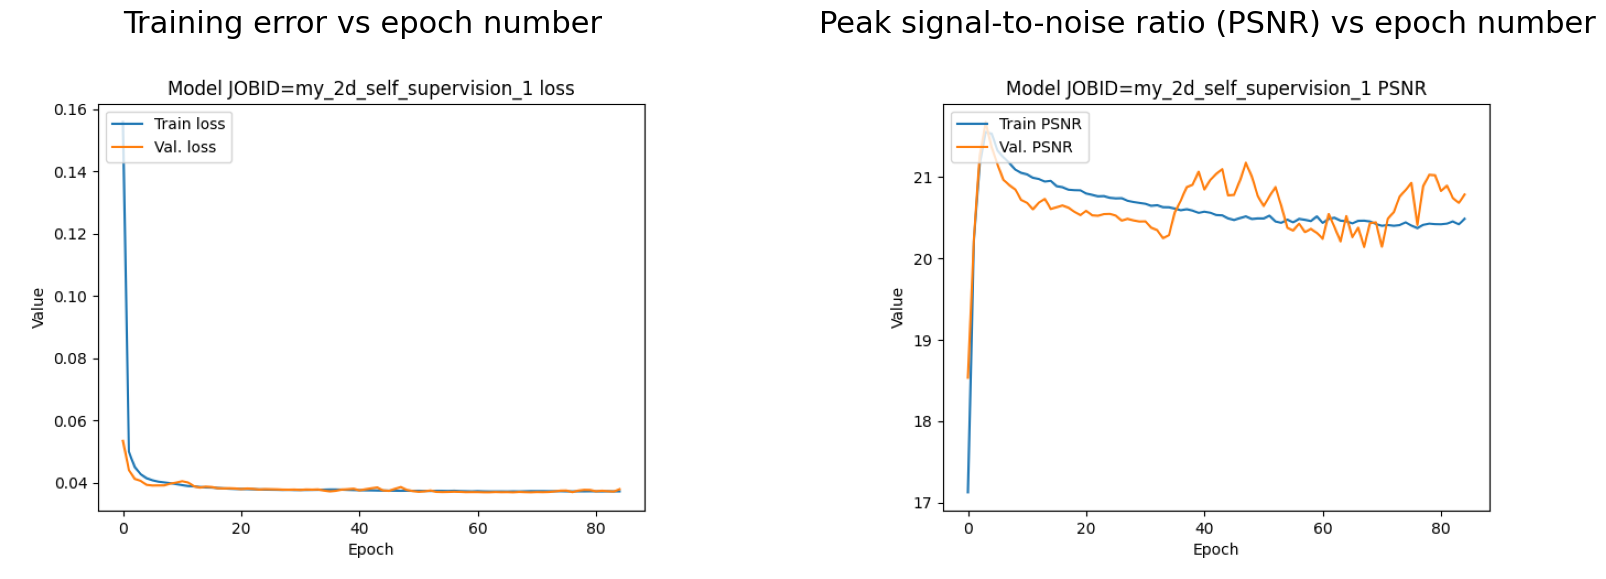

In [ ]:
#@markdown ##Play the cell to show a plot of training error vs. epoch number and PSNR vs epoch number
import matplotlib.pyplot as plt

loss_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_loss.png' )

psnr_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_PSNR.png' )

fig = plt.figure( figsize = (20,10))
ax1 = plt.subplot( 1, 2, 1 )
_ = plt.imshow( loss_plot )
_ = plt.axis('off')
ax1.set_title( 'Training error vs epoch number', fontdict = {'fontsize':22})

ax2 = plt.subplot( 1, 2, 2 )
_ = plt.imshow( psnr_plot )
_ = plt.axis('off')
_= ax2.set_title( 'Peak signal-to-noise ratio (PSNR) vs epoch number', fontdict = {'fontsize':22})

## **Visualize self-supervision reconstruction results**
___

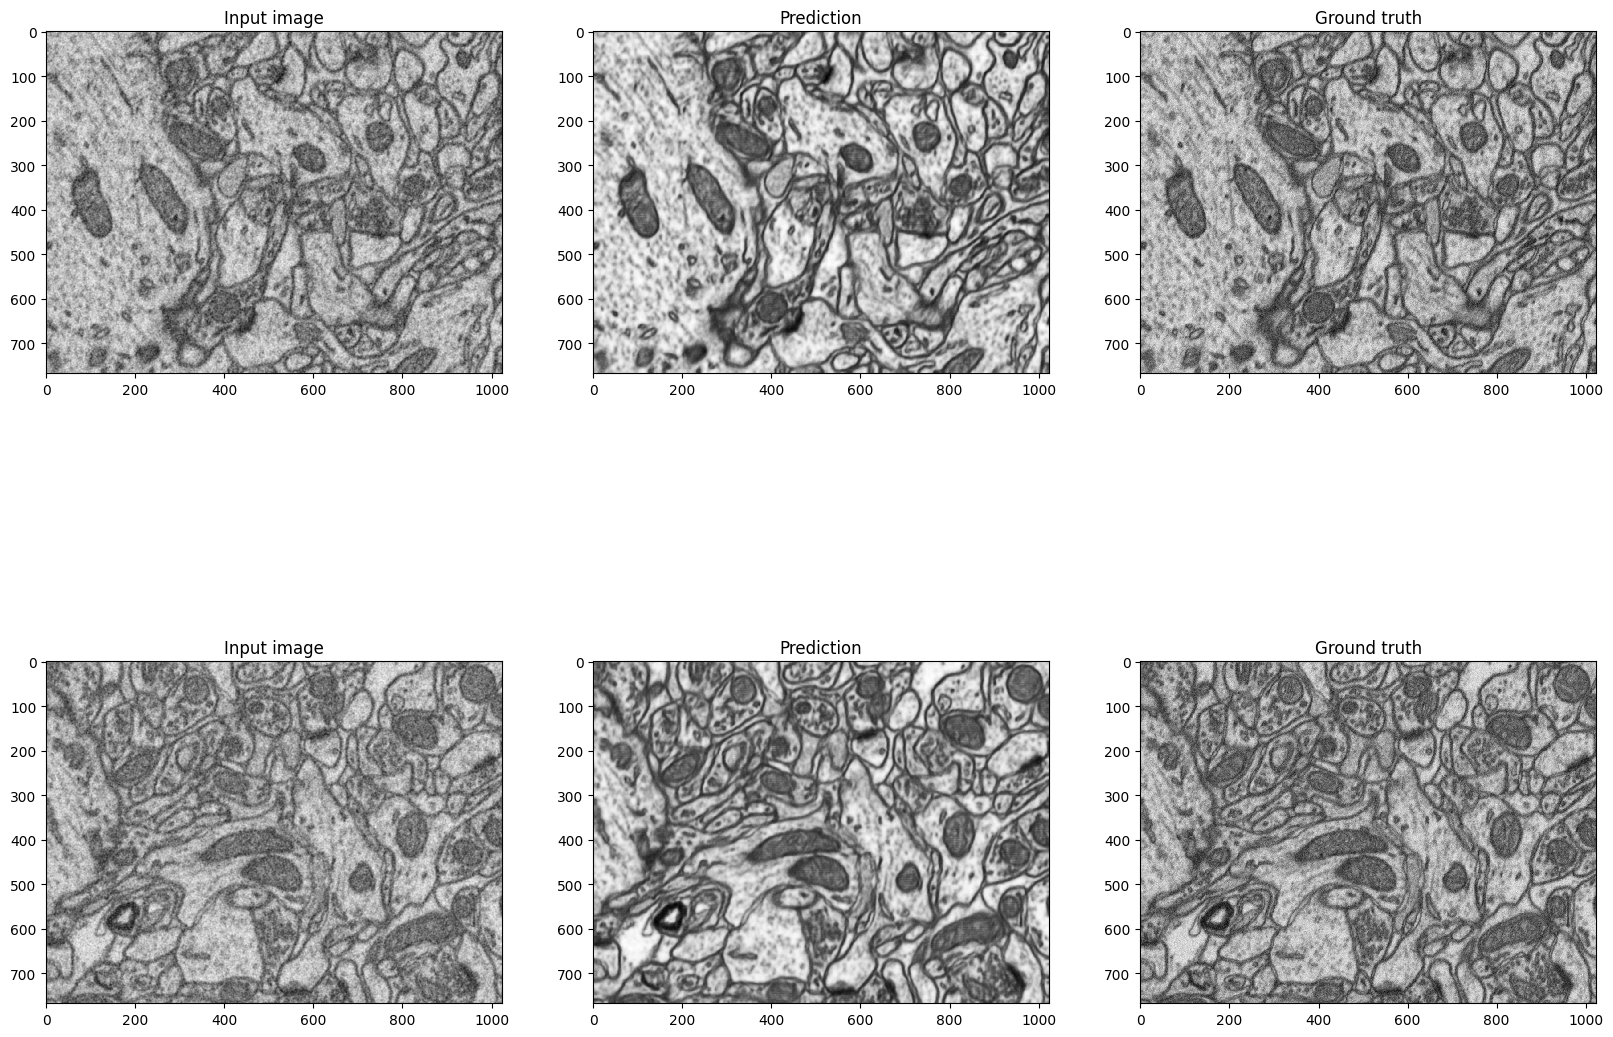

In [ ]:
final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")
ssl_results = os.path.join(final_results, "per_image")
gt_data_path = train_data_path+"_ssl_source"

#@markdown ###Play to visualize some results
from IPython.display import Markdown as md
md("After this last step, the resulting images should be placed in {}".format(final_results))
# Show a few examples to check that they have been stored correctly
%matplotlib inline
import matplotlib
import numpy as np
from numpy.random import randint, seed
from matplotlib import pyplot as plt

ids_pred = sorted(next(os.walk(ssl_results))[2])
ids_input = sorted(next(os.walk(train_data_path))[2])
ids_gt = sorted(next(os.walk(gt_data_path))[2])

samples_to_show = min(len(ids_input), 2)
chosen_images = np.random.choice(len(ids_input), samples_to_show, replace=False)
seed(1)

test_samples = []
test_sample_preds = []
test_sample_gt  = []

for i in range(len(chosen_images)):
    aux = imread(os.path.join(gt_data_path, ids_input[chosen_images[i]]))
    test_samples.append(aux)

    aux = imread(os.path.join(ssl_results, ids_pred[chosen_images[i]]))
    test_sample_preds.append(aux)

    aux = imread(os.path.join(train_data_path, ids_gt[chosen_images[i]]))
    test_sample_gt.append(aux)

# Show predicted images
plt.figure(figsize=(20,15))
index = 1
for j in range(samples_to_show):
    plt.subplot(samples_to_show, 3, index)
    plt.title("Input image")
    plt.imshow(test_samples[j], cmap='gray')
    index = index + 1

    plt.subplot(samples_to_show, 3, index)
    plt.title("Prediction")
    plt.imshow(test_sample_preds[j], cmap='gray', interpolation='nearest')
    index = index + 1

    plt.subplot(samples_to_show, 3, index)
    plt.title("Ground truth")
    plt.imshow(test_sample_gt[j], cmap='gray', interpolation='nearest')
    index = index + 1
plt.show()


In [ ]:
#@markdown ###Play to display the paths to the output files (one 2D TIFF image for each input image).

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

prob_results = os.path.join(final_results, "per_image")

print("Output paths:")
print("    Self-supervision output files are in {}".format(prob_results))

[09:56:04.886849] Output paths:
[09:56:04.892949]     Self-supervision output files are in /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image


## **Download  results**
___

In [ ]:
#@markdown ###Play to download a zip file with all self-supervision results in test.

from google.colab import files

!zip -q -j /content/self-supervision_results.zip $ssl_results/*.tif

files.download("/content/self-supervision_results.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Download train model (weights and configuration file)**
___
The main purpose of this workflow is to **reuse the trained model in the future** . For that reason, you can download both the model weights and its configuration file (.YAML) by running the following cells.

In [ ]:
from google.colab import files

#@markdown ###Play to download the model weights

checkpoints_path = os.path.join(output_path, job_name, 'checkpoints')

weights_filename = str( job_name ) + '_1-checkpoint-best.pth'

files.download( os.path.join( checkpoints_path, weights_filename))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown ###Play to download the model configuration file (.YAML)

config_path = os.path.join(output_path, job_name, 'config_files')

files.download( os.path.join( config_path, yaml_file))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Export your model to BioImage Model Zoo format:**
___
If you want to export the model into the [BioImage Model Zoo](https://bioimage.io/#/) format, fill the metadata and run the following cell. After the cell is run a `trained_model_name.bmz.zip` file will be downloaded.

In [ ]:

#@markdown ##Construct model's metadata to export it to the BioImage Model Zoo format. Choose just one option:

#@markdown **Option 1: Reuse previous BioImage Model Zoo model configuration**

#@markdown With this option, if you were using a model from BioImage Model Zoo you can select this option to reuse its configuration instead of provide all fields manually. If that's not the case and you try to use this option an error will be thrown.
reuse_previous_BMZ_model_config = False #@param {type:"boolean"}

#@markdown ---

#@markdown **Option 2: Manual export fields**

#@markdown With this option you need to introduce manually the metadata of the model.

# ------------- User input ------------
# information about the model
trained_model_name    = "" #@param {type:"string"}
trained_model_authors =  "[First Author, Second Author, Third Author]" #@param {type:"string"}
trained_model_authors_github_user =  "[First Author Github User, Second Author Github User, Third Author Github User]" #@param {type:"string"}
trained_model_description = "" #@param {type:"string"}
trained_model_license = 'CC-BY-4.0'#@param {type:"string"}
trained_model_references = ["Ronneberger et al. arXiv in 2015", "Franco-Barranco, Daniel, et al. ISBI in 2023"] #@param {type:"string"}
trained_model_references_DOI = ["10.1007/978-3-319-24574-4_28","10.1109/ISBI53787.2023.10230593"] #@param {type:"string"}
trained_model_tags = "electron-microscopy, mitochondria" #@param {type:"string"}
trained_model_documentation = "/content/README.md" #@param {type:"string"}


In [ ]:
# @markdown ###Play to download a zip file with your [BioImage Model Zoo](https://bioimage.io/#/) exported model
# update BMZ export parameters

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")
bmz_results = os.path.join(final_results, "bmz_model")

if not reuse_previous_BMZ_model_config:
    from google.colab import files

    # create the author spec input
    auth_names = trained_model_authors[1:-1].split(",")
    auth_githubusers = trained_model_authors_github_user[1:-1].split(",")
    assert len(auth_names) == len(auth_githubusers)
    authors = [{"name": auth_name, "github_user": auth_guser} for auth_name, auth_guser in zip(auth_names, auth_githubusers)]

    # create the citation input spec
    assert len(trained_model_references_DOI) == len(trained_model_references)
    citations = [{'text': text, 'doi': doi} for text, doi in zip(trained_model_references, trained_model_references_DOI)]

    tags = [t for t in trained_model_tags.split(",")]

    with open(trained_model_documentation, "w") as f:
        f.write("### **Description**\n")
        f.write(f"{trained_model_description}\n\n")
        f.write("This model was created using the [BiaPy library](https://biapyx.github.io/).\n")

    bmz_cfg = {}
    # Description of the model
    bmz_cfg['description'] = trained_model_description
    # Authors of the model. Need to be a list of dicts, e.g. authors=[{"name": "Daniel", "github_user": "danifranco"}]
    bmz_cfg['authors'] = authors
    # License of the model. E.g. "CC-BY-4.0"
    bmz_cfg['license'] = trained_model_license
    # List of dictionaries of citations associated, e.g. [{"text": "Gizmo et al.", "doi": "doi:10.1002/xyzacab123"}]
    bmz_cfg['tags'] = tags
    # Tags to make models more findable on the website, e.g. tags=["electron-microscopy", "mitochondria"]
    bmz_cfg['cite'] = citations
    # Path to a file with a documentation of the model in markdown, e.g. "my-model/doc.md"
    bmz_cfg['doc'] = trained_model_documentation
    # Name of the model
    bmz_cfg["model_name"] = trained_model_name
    biapy.export_model_to_bmz(bmz_results, bmz_cfg)
else:
    try:
        biapy.export_model_to_bmz(bmz_results, reuse_original_bmz_config=True)

        bmz_zip_path = f"/content/{trained_model_name}.bmz.zip"
        if os.path.isdir(bmz_results):
            !zip -r $bmz_zip_path $bmz_results
        else:
            print("The model was not exported to this format")

        files.download(bmz_zip_path)
    except:
        print("Seems that the was a problem reusing BMZ model specs. Please uncheck 'reuse_previous_BMZ_model_config' and do it manually")



## **How to use the trained model with new data**
---
To directly infer new data to the trained model, you can use [this notebook](https://github.com/BiaPyX/BiaPy/blob/master/notebooks/BiaPy_Inference.ipynb). It will be necessary to upload the downloaded YAML configuration file and model weights to that notebook.

## **Acknowledgments**
___
We would like to acknowledge the inspiration provided by the excellent [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki). In particular, we have reused some of their descriptions of metrics and parameters.